This is the implementation of DCGAN with normalize input and one-sided label smoothing:
- Number of epochs: 100
- lr: 0.0002
- Add results dir for images and loss
- Add weight_decay: 1e-4

- input: normalize (0.5, 0.5, 0.5)
- sided_label real: 0.9 ```torch.from_numpy(np.full(batch_size, 0.9, np.float32))```
- fake label: 0.3
- Freezing: stop update D when loss D < 0.7 loss G

# Import

In [18]:
import argparse
import os
import time
import pickle
import numpy as np

In [19]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchnet.meter import AverageValueMeter

# Define Arguments

In [36]:
parser = {
    'data_path': './data/pandora/',
    'epochs': 10000,
    'batch_size': 64,
    'lr': 0.0002,
    'image_size': 340,
    'scale_size': 64,
    'z_dim': 100,
    'G_features': 64,
    'D_features': 64,
    'image_channels': 3,
    'beta1': 0.5,
    'cuda': True,
    'seed': 7,
    'workers': 2,
    'results': './resultsDCGAN4_pandora_0611/'
}
args = argparse.Namespace(**parser)
args.image_results = args.results + 'images/'
args.loss_results = args.results + 'loss/'
args.cuda = args.cuda and torch.cuda.is_available()

if not os.path.isdir(args.data_path):
    os.makedirs(args.data_path)
if not os.path.isdir(args.results):
    os.makedirs(args.results)
if not os.path.isdir(args.image_results):
    os.makedirs(args.image_results)
if not os.path.isdir(args.loss_results):
    os.makedirs(args.loss_results)
    
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Prepare Data

**Note: all iamges have size 136x102**

In [37]:
from folder import ImageFolder

In [38]:
from torchvision.transforms import ToPILImage
to_image = ToPILImage()

In [39]:
def get_loader(image_root, batch_size, scale_size, num_workers=2, shuffle=True):
    #image_root = os.path.join(root, 'splits', split)
    dataset = ImageFolder(root=image_root, transform=transforms.Compose([
            transforms.Scale(scale_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=int(num_workers))
    #data_loader.shape = [int(num) for num in dataset[0][0].size()]

    return data_loader

In [40]:
dataloader = get_loader(args.data_path, args.batch_size, args.scale_size)

Found 662 images in subfolders of: ./data/pandora/


## Test One Image

In [41]:
test_image = 0
for data, _ in dataloader:
    print(data[0])
    test_image = data[0]
    break


(0 ,.,.) = 
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000

(1 ,.,.) = 
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000

(2 ,.,.) = 
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
           ...            

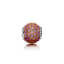

In [42]:
to_image(test_image)

# Define Model

## Define G

In [27]:
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(args.z_dim, args.G_features * 8,
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(args.G_features * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(args.G_features * 8, args.G_features * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features * 4),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(args.G_features * 4, args.G_features * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features * 2),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(args.G_features * 2, args.G_features,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(args.G_features, args.image_channels,
                               4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )
        self._initialize_weights()
        
    # custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)

    def forward(self, x):
        return self.main(x)

## Define D

In [28]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(args.image_channels, args.D_features,
                      4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(args.D_features, args.D_features * 2,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(args.D_features * 2, args.D_features * 4,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(args.D_features * 4, args.D_features * 8,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(args.D_features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self._initialize_weights()
        
    # custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1)

## Save losses

In [29]:
class Results():
    def __init__(self, results_path):
        self.D_losses = []
        self.G_losses = []
        self.D_reals = []
        self.D_fakes = []
        self.G_reals = []
        self.results_path = results_path
    
    def save_losses(self, D_loss, G_loss, D_real, D_fake, G_real):
        self.D_losses.append(D_loss)
        self.G_losses.append(G_loss)
        self.D_reals.append(D_real)
        self.D_fakes.append(D_fake)
        self.G_reals.append(G_real)
        
    def save_to_disk(self):
        f = open(self.results_path + "D_losses.pkl", "wb")
        pickle.dump(self.D_losses, f)
        f= open(self.results_path + "G_losses.pkl", "wb")
        pickle.dump(self.G_losses, f)
        f = open(self.results_path + "D_reals.pkl", "wb")
        pickle.dump(self.D_reals, f)
        f = open(self.results_path + "D_fakes.pkl", "wb")
        pickle.dump(self.D_fakes, f)
        f = open(self.results_path + "G_reals.pkl", "wb")
        pickle.dump(self.G_reals, f)
        

## Define Train and Generate

In [30]:
def train(args, data_loader, netG, netD, G_optimizer, D_optimizer,
          criterion, epoch, result_losses):
    D_losses = AverageValueMeter()
    G_losses = AverageValueMeter()
    D_reals = AverageValueMeter()
    D_fakes = AverageValueMeter()
    G_reals = AverageValueMeter()
    
    start = time.time()
    # call Variable after .cuda()
    for i, (real, _) in enumerate(data_loader):
        batch_size = real.size(0)
        real_label = torch.from_numpy(np.full(batch_size, 0.9, np.float32)) #modify here
        fake_label = torch.from_numpy(np.full(batch_size, 0.3, np.float32))
        z = torch.randn(batch_size, args.z_dim, 1, 1)
        
        if args.cuda:
            real_label = real_label.cuda()
            fake_label = fake_label.cuda()
            real = real.cuda()
            z = z.cuda()
        real_label = Variable(real_label)
        fake_label = Variable(fake_label)
        real = Variable(real)
        z = Variable(z)
        
        if D_losses.value()[0] < 0.7*G_losses.value()[0]:
            # Stop training D
            #----------TRAIN D---------------
            # train with real
            real_output = netD(real)
            D_real_loss = criterion(real_output, real_label)
            D_real = real_output.data.mean()
        
            # train with fake
            fake = netG(z)
            fake_output = netD(fake.detach())
            D_fake_loss = criterion(fake_output, fake_label)
            D_fake = fake_output.data.mean()
        
            # loss D
            D_loss = D_real_loss + D_fake_loss
            #netD.zero_grad()
            #D_loss.backward()
            #D_optimizer.step()
            
            #----------TRAIN G---------------
            output = netD(fake)
            G_loss = criterion(output, real_label)
            G_real = output.data.mean()
            netG.zero_grad()
            G_loss.backward()
            G_optimizer.step()    
        else:
            #----------TRAIN D---------------
            # train with real
            real_output = netD(real)
            D_real_loss = criterion(real_output, real_label)
            D_real = real_output.data.mean()
        
            # train with fake
            fake = netG(z)
            fake_output = netD(fake.detach())
            D_fake_loss = criterion(fake_output, fake_label)
            D_fake = fake_output.data.mean()
        
            # loss D
            D_loss = D_real_loss + D_fake_loss
            netD.zero_grad()
            D_loss.backward()
            D_optimizer.step()
            
            #----------TRAIN G---------------
            output = netD(fake)
            G_loss = criterion(output, real_label)
            G_real = output.data.mean()
            netG.zero_grad()
            G_loss.backward()
            G_optimizer.step()
        
        
        # update loss
        D_losses.add(D_loss.data.cpu()[0] * batch_size, batch_size)
        G_losses.add(G_loss.data.cpu()[0] * batch_size, batch_size)
        D_reals.add(D_real * batch_size, batch_size)
        D_fakes.add(D_fake * batch_size, batch_size)
        G_reals.add(G_real * batch_size, batch_size)
        
    print("=> EPOCH {} | Time: {}s | D_loss: {:.4f} | G_loss: {:.4f}"
          " | D_real: {:.4f} | D_fake: {:.4f} | G_real: {:.4f}"
          .format(epoch, round(time.time()-start), D_losses.value()[0],
                  G_losses.value()[0], D_reals.value()[0],
                  D_fakes.value()[0], G_reals.value()[0]))
    result_losses.save_losses(D_losses.value()[0],
                  G_losses.value()[0], D_reals.value()[0],
                  D_fakes.value()[0], G_reals.value()[0])

In [31]:
def generate(args, netG, epoch):
    z = torch.randn(args.batch_size, args.z_dim, 1, 1)
    if args.cuda:
        z = z.cuda()
    fake = netG(Variable(z, volatile=True))
    save_image(fake.data.cpu(), os.path.join(args.image_results,
        "fake_sample_epoch_{:02d}.png".format(epoch)), normalize=True)

## Create Model, Define Loss and Optimizer

In [43]:
netG = _netG()
netD = _netD()
criterion = nn.BCELoss()
if args.cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()

In [44]:
D_optimizer = optim.Adam(netD.parameters(), lr=args.lr,
                         betas=(args.beta1, 0.999), weight_decay=1e-4)
G_optimizer = optim.Adam(netG.parameters(), lr=args.lr,
                         betas=(args.beta1, 0.999), weight_decay=1e-4)

## Run Train

In [45]:
result_losses = Results(args.loss_results)
for epoch in range(0, args.epochs):
    train(args, dataloader, netG, netD, G_optimizer, D_optimizer,
          criterion, epoch, result_losses)
    if epoch % 500 == 0:
        generate(args, netG, epoch)

=> EPOCH 0 | Time: 2s | D_loss: 2.1791 | G_loss: 3.3082 | D_real: 0.8987 | D_fake: 0.5340 | G_real: 0.1363
=> EPOCH 1 | Time: 2s | D_loss: 2.5979 | G_loss: 3.6606 | D_real: 0.6534 | D_fake: 0.5292 | G_real: 0.3249
=> EPOCH 2 | Time: 2s | D_loss: 2.4978 | G_loss: 3.6664 | D_real: 0.8431 | D_fake: 0.4936 | G_real: 0.3665
=> EPOCH 3 | Time: 2s | D_loss: 2.6924 | G_loss: 4.0514 | D_real: 0.9240 | D_fake: 0.4285 | G_real: 0.3344
=> EPOCH 4 | Time: 2s | D_loss: 2.8040 | G_loss: 4.0953 | D_real: 0.9353 | D_fake: 0.6361 | G_real: 0.5143
=> EPOCH 5 | Time: 2s | D_loss: 2.6466 | G_loss: 4.7475 | D_real: 0.8296 | D_fake: 0.4229 | G_real: 0.3301
=> EPOCH 6 | Time: 2s | D_loss: 2.4999 | G_loss: 5.7112 | D_real: 0.7706 | D_fake: 0.4175 | G_real: 0.2827
=> EPOCH 7 | Time: 2s | D_loss: 2.4546 | G_loss: 3.6169 | D_real: 0.8124 | D_fake: 0.6326 | G_real: 0.5579
=> EPOCH 8 | Time: 2s | D_loss: 2.6754 | G_loss: 4.8492 | D_real: 0.8052 | D_fake: 0.5618 | G_real: 0.4734
=> EPOCH 9 | Time: 2s | D_loss: 2.714

=> EPOCH 76 | Time: 2s | D_loss: 1.2941 | G_loss: 1.5099 | D_real: 0.6755 | D_fake: 0.4216 | G_real: 0.2574
=> EPOCH 77 | Time: 3s | D_loss: 1.0643 | G_loss: 1.2300 | D_real: 0.7878 | D_fake: 0.4014 | G_real: 0.2871
=> EPOCH 78 | Time: 3s | D_loss: 1.1114 | G_loss: 1.2895 | D_real: 0.7804 | D_fake: 0.4281 | G_real: 0.2935
=> EPOCH 79 | Time: 3s | D_loss: 1.1136 | G_loss: 1.2901 | D_real: 0.7858 | D_fake: 0.4249 | G_real: 0.2957
=> EPOCH 80 | Time: 3s | D_loss: 1.0773 | G_loss: 1.2335 | D_real: 0.7932 | D_fake: 0.4194 | G_real: 0.2983
=> EPOCH 81 | Time: 3s | D_loss: 1.1347 | G_loss: 1.2154 | D_real: 0.7631 | D_fake: 0.4171 | G_real: 0.3201
=> EPOCH 82 | Time: 3s | D_loss: 1.2348 | G_loss: 1.4246 | D_real: 0.7477 | D_fake: 0.4209 | G_real: 0.2799
=> EPOCH 83 | Time: 3s | D_loss: 1.0257 | G_loss: 1.1891 | D_real: 0.8008 | D_fake: 0.3974 | G_real: 0.2919
=> EPOCH 84 | Time: 3s | D_loss: 1.0997 | G_loss: 1.2936 | D_real: 0.7949 | D_fake: 0.4058 | G_real: 0.2945
=> EPOCH 85 | Time: 2s | D_l

=> EPOCH 152 | Time: 3s | D_loss: 1.0736 | G_loss: 1.2199 | D_real: 0.7862 | D_fake: 0.4143 | G_real: 0.2965
=> EPOCH 153 | Time: 3s | D_loss: 1.0454 | G_loss: 1.2739 | D_real: 0.8015 | D_fake: 0.4041 | G_real: 0.2763
=> EPOCH 154 | Time: 2s | D_loss: 1.0783 | G_loss: 1.3350 | D_real: 0.7746 | D_fake: 0.3931 | G_real: 0.2662
=> EPOCH 155 | Time: 2s | D_loss: 1.2946 | G_loss: 1.4937 | D_real: 0.6815 | D_fake: 0.3707 | G_real: 0.2804
=> EPOCH 156 | Time: 2s | D_loss: 1.2469 | G_loss: 1.4206 | D_real: 0.7530 | D_fake: 0.3929 | G_real: 0.2980
=> EPOCH 157 | Time: 3s | D_loss: 1.0603 | G_loss: 1.2769 | D_real: 0.7960 | D_fake: 0.3892 | G_real: 0.2788
=> EPOCH 158 | Time: 3s | D_loss: 1.0602 | G_loss: 1.2763 | D_real: 0.8001 | D_fake: 0.3818 | G_real: 0.2962
=> EPOCH 159 | Time: 2s | D_loss: 1.0746 | G_loss: 1.3243 | D_real: 0.8033 | D_fake: 0.3687 | G_real: 0.2803
=> EPOCH 160 | Time: 3s | D_loss: 1.0831 | G_loss: 1.2927 | D_real: 0.8188 | D_fake: 0.4026 | G_real: 0.2861
=> EPOCH 161 | Time

=> EPOCH 228 | Time: 3s | D_loss: 1.0454 | G_loss: 1.2245 | D_real: 0.8295 | D_fake: 0.3809 | G_real: 0.3054
=> EPOCH 229 | Time: 2s | D_loss: 1.1458 | G_loss: 1.4410 | D_real: 0.7316 | D_fake: 0.3337 | G_real: 0.2510
=> EPOCH 230 | Time: 2s | D_loss: 1.2127 | G_loss: 1.5663 | D_real: 0.6930 | D_fake: 0.3348 | G_real: 0.2509
=> EPOCH 231 | Time: 2s | D_loss: 1.0720 | G_loss: 1.3185 | D_real: 0.7814 | D_fake: 0.3621 | G_real: 0.2632
=> EPOCH 232 | Time: 2s | D_loss: 1.0941 | G_loss: 1.3783 | D_real: 0.7853 | D_fake: 0.3613 | G_real: 0.2602
=> EPOCH 233 | Time: 3s | D_loss: 1.0129 | G_loss: 1.2540 | D_real: 0.8245 | D_fake: 0.3583 | G_real: 0.2816
=> EPOCH 234 | Time: 3s | D_loss: 1.0145 | G_loss: 1.2195 | D_real: 0.8292 | D_fake: 0.3700 | G_real: 0.2916
=> EPOCH 235 | Time: 3s | D_loss: 1.0030 | G_loss: 1.1514 | D_real: 0.8434 | D_fake: 0.3495 | G_real: 0.3086
=> EPOCH 236 | Time: 2s | D_loss: 1.0306 | G_loss: 1.2813 | D_real: 0.8034 | D_fake: 0.3603 | G_real: 0.2789
=> EPOCH 237 | Time

=> EPOCH 304 | Time: 3s | D_loss: 1.0016 | G_loss: 1.2310 | D_real: 0.8550 | D_fake: 0.3402 | G_real: 0.2969
=> EPOCH 305 | Time: 2s | D_loss: 1.0509 | G_loss: 1.3818 | D_real: 0.8336 | D_fake: 0.3393 | G_real: 0.2691
=> EPOCH 306 | Time: 3s | D_loss: 0.9817 | G_loss: 1.2403 | D_real: 0.8493 | D_fake: 0.3409 | G_real: 0.2786
=> EPOCH 307 | Time: 3s | D_loss: 1.0011 | G_loss: 1.2458 | D_real: 0.8467 | D_fake: 0.3425 | G_real: 0.2943
=> EPOCH 308 | Time: 3s | D_loss: 0.9993 | G_loss: 1.2109 | D_real: 0.8586 | D_fake: 0.3303 | G_real: 0.2904
=> EPOCH 309 | Time: 3s | D_loss: 0.9955 | G_loss: 1.2201 | D_real: 0.8608 | D_fake: 0.3341 | G_real: 0.2927
=> EPOCH 310 | Time: 3s | D_loss: 0.9829 | G_loss: 1.1690 | D_real: 0.8573 | D_fake: 0.3411 | G_real: 0.3004
=> EPOCH 311 | Time: 3s | D_loss: 0.9937 | G_loss: 1.2411 | D_real: 0.8537 | D_fake: 0.3388 | G_real: 0.2869
=> EPOCH 312 | Time: 3s | D_loss: 1.0089 | G_loss: 1.2515 | D_real: 0.8583 | D_fake: 0.3407 | G_real: 0.2918
=> EPOCH 313 | Time

=> EPOCH 380 | Time: 2s | D_loss: 1.0083 | G_loss: 1.3331 | D_real: 0.8141 | D_fake: 0.3206 | G_real: 0.2602
=> EPOCH 381 | Time: 2s | D_loss: 1.1873 | G_loss: 1.7568 | D_real: 0.7457 | D_fake: 0.3434 | G_real: 0.2323
=> EPOCH 382 | Time: 3s | D_loss: 1.0862 | G_loss: 1.3432 | D_real: 0.8431 | D_fake: 0.3277 | G_real: 0.2787
=> EPOCH 383 | Time: 2s | D_loss: 1.0141 | G_loss: 1.3860 | D_real: 0.8348 | D_fake: 0.3272 | G_real: 0.2494
=> EPOCH 384 | Time: 2s | D_loss: 1.0551 | G_loss: 1.5928 | D_real: 0.7860 | D_fake: 0.2747 | G_real: 0.2062
=> EPOCH 385 | Time: 3s | D_loss: 1.0297 | G_loss: 1.3155 | D_real: 0.8521 | D_fake: 0.3318 | G_real: 0.2820
=> EPOCH 386 | Time: 2s | D_loss: 1.0745 | G_loss: 1.6856 | D_real: 0.8127 | D_fake: 0.2701 | G_real: 0.1887
=> EPOCH 387 | Time: 3s | D_loss: 1.0054 | G_loss: 1.2467 | D_real: 0.8529 | D_fake: 0.3219 | G_real: 0.2831
=> EPOCH 388 | Time: 3s | D_loss: 0.9608 | G_loss: 1.2135 | D_real: 0.8762 | D_fake: 0.3173 | G_real: 0.2767
=> EPOCH 389 | Time

=> EPOCH 456 | Time: 3s | D_loss: 1.0243 | G_loss: 1.3222 | D_real: 0.8620 | D_fake: 0.3334 | G_real: 0.2619
=> EPOCH 457 | Time: 2s | D_loss: 1.0051 | G_loss: 1.3907 | D_real: 0.8189 | D_fake: 0.2988 | G_real: 0.2365
=> EPOCH 458 | Time: 2s | D_loss: 1.0744 | G_loss: 1.4277 | D_real: 0.7985 | D_fake: 0.3377 | G_real: 0.2618
=> EPOCH 459 | Time: 3s | D_loss: 0.9847 | G_loss: 1.3242 | D_real: 0.8609 | D_fake: 0.3536 | G_real: 0.2516
=> EPOCH 460 | Time: 2s | D_loss: 1.0537 | G_loss: 1.4349 | D_real: 0.7637 | D_fake: 0.2980 | G_real: 0.2382
=> EPOCH 461 | Time: 2s | D_loss: 1.1242 | G_loss: 1.7857 | D_real: 0.7610 | D_fake: 0.2975 | G_real: 0.2065
=> EPOCH 462 | Time: 2s | D_loss: 1.3300 | G_loss: 1.8214 | D_real: 0.6396 | D_fake: 0.2453 | G_real: 0.2263
=> EPOCH 463 | Time: 2s | D_loss: 1.2256 | G_loss: 1.8875 | D_real: 0.7453 | D_fake: 0.3120 | G_real: 0.2061
=> EPOCH 464 | Time: 2s | D_loss: 1.4124 | G_loss: 1.8634 | D_real: 0.6660 | D_fake: 0.3041 | G_real: 0.2611
=> EPOCH 465 | Time

=> EPOCH 532 | Time: 2s | D_loss: 0.9930 | G_loss: 1.3365 | D_real: 0.8291 | D_fake: 0.2966 | G_real: 0.2584
=> EPOCH 533 | Time: 2s | D_loss: 1.0684 | G_loss: 1.6567 | D_real: 0.8234 | D_fake: 0.2581 | G_real: 0.2060
=> EPOCH 534 | Time: 2s | D_loss: 1.3489 | G_loss: 1.8567 | D_real: 0.5787 | D_fake: 0.2229 | G_real: 0.1757
=> EPOCH 535 | Time: 2s | D_loss: 1.0942 | G_loss: 1.6803 | D_real: 0.8401 | D_fake: 0.3113 | G_real: 0.2504
=> EPOCH 536 | Time: 3s | D_loss: 0.9998 | G_loss: 1.2869 | D_real: 0.8537 | D_fake: 0.3266 | G_real: 0.2673
=> EPOCH 537 | Time: 2s | D_loss: 1.0800 | G_loss: 1.7673 | D_real: 0.8113 | D_fake: 0.2656 | G_real: 0.1905
=> EPOCH 538 | Time: 2s | D_loss: 1.0398 | G_loss: 1.4482 | D_real: 0.8023 | D_fake: 0.3065 | G_real: 0.2501
=> EPOCH 539 | Time: 2s | D_loss: 1.0157 | G_loss: 1.4464 | D_real: 0.8371 | D_fake: 0.2792 | G_real: 0.2403
=> EPOCH 540 | Time: 3s | D_loss: 1.0320 | G_loss: 1.3970 | D_real: 0.8548 | D_fake: 0.3308 | G_real: 0.2568
=> EPOCH 541 | Time

=> EPOCH 608 | Time: 2s | D_loss: 1.0758 | G_loss: 1.4068 | D_real: 0.7512 | D_fake: 0.3102 | G_real: 0.2500
=> EPOCH 609 | Time: 2s | D_loss: 0.9968 | G_loss: 1.3920 | D_real: 0.8255 | D_fake: 0.3043 | G_real: 0.2381
=> EPOCH 610 | Time: 2s | D_loss: 0.9829 | G_loss: 1.4217 | D_real: 0.8609 | D_fake: 0.3016 | G_real: 0.2424
=> EPOCH 611 | Time: 2s | D_loss: 1.0169 | G_loss: 1.5398 | D_real: 0.8455 | D_fake: 0.2702 | G_real: 0.2167
=> EPOCH 612 | Time: 3s | D_loss: 0.9747 | G_loss: 1.2365 | D_real: 0.8692 | D_fake: 0.3127 | G_real: 0.2832
=> EPOCH 613 | Time: 2s | D_loss: 0.9609 | G_loss: 1.2522 | D_real: 0.8795 | D_fake: 0.3115 | G_real: 0.2653
=> EPOCH 614 | Time: 3s | D_loss: 0.9739 | G_loss: 1.2301 | D_real: 0.8802 | D_fake: 0.3148 | G_real: 0.2868
=> EPOCH 615 | Time: 2s | D_loss: 1.0468 | G_loss: 1.4249 | D_real: 0.8227 | D_fake: 0.3142 | G_real: 0.2630
=> EPOCH 616 | Time: 2s | D_loss: 1.3342 | G_loss: 1.8332 | D_real: 0.6341 | D_fake: 0.2905 | G_real: 0.1845
=> EPOCH 617 | Time

=> EPOCH 684 | Time: 2s | D_loss: 1.0221 | G_loss: 1.3777 | D_real: 0.8095 | D_fake: 0.2951 | G_real: 0.2485
=> EPOCH 685 | Time: 2s | D_loss: 1.1244 | G_loss: 1.5648 | D_real: 0.7411 | D_fake: 0.3144 | G_real: 0.2387
=> EPOCH 686 | Time: 3s | D_loss: 0.9957 | G_loss: 1.2438 | D_real: 0.8931 | D_fake: 0.3006 | G_real: 0.2749
=> EPOCH 687 | Time: 3s | D_loss: 0.9735 | G_loss: 1.1944 | D_real: 0.8776 | D_fake: 0.3079 | G_real: 0.2875
=> EPOCH 688 | Time: 2s | D_loss: 1.0062 | G_loss: 1.5427 | D_real: 0.8796 | D_fake: 0.2925 | G_real: 0.2198
=> EPOCH 689 | Time: 3s | D_loss: 0.9883 | G_loss: 1.2717 | D_real: 0.8645 | D_fake: 0.3133 | G_real: 0.2734
=> EPOCH 690 | Time: 2s | D_loss: 1.0485 | G_loss: 1.4786 | D_real: 0.8148 | D_fake: 0.2976 | G_real: 0.2369
=> EPOCH 691 | Time: 3s | D_loss: 1.0184 | G_loss: 1.3496 | D_real: 0.8687 | D_fake: 0.3188 | G_real: 0.2803
=> EPOCH 692 | Time: 2s | D_loss: 0.9642 | G_loss: 1.2270 | D_real: 0.8700 | D_fake: 0.3067 | G_real: 0.2745
=> EPOCH 693 | Time

=> EPOCH 760 | Time: 3s | D_loss: 1.0008 | G_loss: 1.2494 | D_real: 0.8764 | D_fake: 0.3212 | G_real: 0.2939
=> EPOCH 761 | Time: 2s | D_loss: 0.9891 | G_loss: 1.2754 | D_real: 0.8417 | D_fake: 0.3246 | G_real: 0.2671
=> EPOCH 762 | Time: 3s | D_loss: 1.0021 | G_loss: 1.3426 | D_real: 0.8891 | D_fake: 0.3036 | G_real: 0.2692
=> EPOCH 763 | Time: 3s | D_loss: 0.9928 | G_loss: 1.2336 | D_real: 0.8705 | D_fake: 0.3465 | G_real: 0.2731
=> EPOCH 764 | Time: 3s | D_loss: 0.9789 | G_loss: 1.2564 | D_real: 0.8834 | D_fake: 0.3150 | G_real: 0.2735
=> EPOCH 765 | Time: 2s | D_loss: 1.0023 | G_loss: 1.4297 | D_real: 0.8438 | D_fake: 0.2810 | G_real: 0.2206
=> EPOCH 766 | Time: 3s | D_loss: 0.9759 | G_loss: 1.1752 | D_real: 0.8563 | D_fake: 0.3205 | G_real: 0.2955
=> EPOCH 767 | Time: 2s | D_loss: 0.9660 | G_loss: 1.2598 | D_real: 0.8686 | D_fake: 0.3138 | G_real: 0.2683
=> EPOCH 768 | Time: 3s | D_loss: 0.9517 | G_loss: 1.2064 | D_real: 0.8884 | D_fake: 0.3217 | G_real: 0.2777
=> EPOCH 769 | Time

=> EPOCH 836 | Time: 3s | D_loss: 0.9893 | G_loss: 1.3031 | D_real: 0.8734 | D_fake: 0.3233 | G_real: 0.2806
=> EPOCH 837 | Time: 3s | D_loss: 0.9574 | G_loss: 1.2207 | D_real: 0.8723 | D_fake: 0.3099 | G_real: 0.2770
=> EPOCH 838 | Time: 2s | D_loss: 0.9807 | G_loss: 1.3459 | D_real: 0.8404 | D_fake: 0.2951 | G_real: 0.2473
=> EPOCH 839 | Time: 3s | D_loss: 1.0030 | G_loss: 1.3124 | D_real: 0.8744 | D_fake: 0.3123 | G_real: 0.2816
=> EPOCH 840 | Time: 3s | D_loss: 0.9542 | G_loss: 1.2070 | D_real: 0.8900 | D_fake: 0.3102 | G_real: 0.2804
=> EPOCH 841 | Time: 2s | D_loss: 1.0043 | G_loss: 1.4490 | D_real: 0.8571 | D_fake: 0.2706 | G_real: 0.2320
=> EPOCH 842 | Time: 2s | D_loss: 1.0321 | G_loss: 1.4100 | D_real: 0.7762 | D_fake: 0.2682 | G_real: 0.2356
=> EPOCH 843 | Time: 2s | D_loss: 1.0459 | G_loss: 1.5672 | D_real: 0.8711 | D_fake: 0.3040 | G_real: 0.2598
=> EPOCH 844 | Time: 3s | D_loss: 1.0232 | G_loss: 1.3052 | D_real: 0.8630 | D_fake: 0.3060 | G_real: 0.2882
=> EPOCH 845 | Time

=> EPOCH 912 | Time: 2s | D_loss: 1.1188 | G_loss: 1.5209 | D_real: 0.7258 | D_fake: 0.2707 | G_real: 0.2370
=> EPOCH 913 | Time: 2s | D_loss: 1.2270 | G_loss: 1.7709 | D_real: 0.6941 | D_fake: 0.2813 | G_real: 0.2173
=> EPOCH 914 | Time: 2s | D_loss: 1.4027 | G_loss: 1.8693 | D_real: 0.6519 | D_fake: 0.2627 | G_real: 0.2437
=> EPOCH 915 | Time: 2s | D_loss: 0.9754 | G_loss: 1.2716 | D_real: 0.8645 | D_fake: 0.3093 | G_real: 0.2651
=> EPOCH 916 | Time: 2s | D_loss: 1.0546 | G_loss: 1.6331 | D_real: 0.8125 | D_fake: 0.2694 | G_real: 0.1960
=> EPOCH 917 | Time: 3s | D_loss: 1.0074 | G_loss: 1.2766 | D_real: 0.8595 | D_fake: 0.3197 | G_real: 0.2869
=> EPOCH 918 | Time: 2s | D_loss: 0.9627 | G_loss: 1.2270 | D_real: 0.8584 | D_fake: 0.3042 | G_real: 0.2708
=> EPOCH 919 | Time: 3s | D_loss: 0.9676 | G_loss: 1.2379 | D_real: 0.8756 | D_fake: 0.3183 | G_real: 0.2797
=> EPOCH 920 | Time: 2s | D_loss: 0.9960 | G_loss: 1.3347 | D_real: 0.8394 | D_fake: 0.3241 | G_real: 0.2578
=> EPOCH 921 | Time

=> EPOCH 988 | Time: 2s | D_loss: 0.9858 | G_loss: 1.4228 | D_real: 0.8459 | D_fake: 0.2729 | G_real: 0.2287
=> EPOCH 989 | Time: 3s | D_loss: 0.9744 | G_loss: 1.2391 | D_real: 0.8755 | D_fake: 0.3146 | G_real: 0.2940
=> EPOCH 990 | Time: 3s | D_loss: 0.9594 | G_loss: 1.2138 | D_real: 0.8835 | D_fake: 0.3141 | G_real: 0.2805
=> EPOCH 991 | Time: 3s | D_loss: 0.9639 | G_loss: 1.2222 | D_real: 0.8878 | D_fake: 0.3178 | G_real: 0.2842
=> EPOCH 992 | Time: 2s | D_loss: 0.9680 | G_loss: 1.2675 | D_real: 0.8805 | D_fake: 0.3048 | G_real: 0.2701
=> EPOCH 993 | Time: 2s | D_loss: 1.0450 | G_loss: 1.5476 | D_real: 0.7918 | D_fake: 0.2453 | G_real: 0.2078
=> EPOCH 994 | Time: 2s | D_loss: 1.1871 | G_loss: 1.5883 | D_real: 0.6502 | D_fake: 0.2159 | G_real: 0.2036
=> EPOCH 995 | Time: 2s | D_loss: 1.0831 | G_loss: 1.6573 | D_real: 0.8593 | D_fake: 0.2906 | G_real: 0.2268
=> EPOCH 996 | Time: 2s | D_loss: 1.4317 | G_loss: 1.8823 | D_real: 0.5551 | D_fake: 0.2236 | G_real: 0.1856
=> EPOCH 997 | Time

=> EPOCH 1063 | Time: 2s | D_loss: 1.0623 | G_loss: 1.5800 | D_real: 0.8741 | D_fake: 0.3015 | G_real: 0.2805
=> EPOCH 1064 | Time: 2s | D_loss: 1.0671 | G_loss: 1.5307 | D_real: 0.8051 | D_fake: 0.2426 | G_real: 0.2341
=> EPOCH 1065 | Time: 2s | D_loss: 1.0029 | G_loss: 1.3831 | D_real: 0.8365 | D_fake: 0.3002 | G_real: 0.2551
=> EPOCH 1066 | Time: 2s | D_loss: 0.9954 | G_loss: 1.3693 | D_real: 0.8405 | D_fake: 0.2809 | G_real: 0.2436
=> EPOCH 1067 | Time: 2s | D_loss: 1.9099 | G_loss: 2.5658 | D_real: 0.4055 | D_fake: 0.1788 | G_real: 0.1173
=> EPOCH 1068 | Time: 2s | D_loss: 1.3270 | G_loss: 1.7462 | D_real: 0.6412 | D_fake: 0.2826 | G_real: 0.2114
=> EPOCH 1069 | Time: 2s | D_loss: 1.2133 | G_loss: 1.7547 | D_real: 0.7743 | D_fake: 0.2975 | G_real: 0.2284
=> EPOCH 1070 | Time: 2s | D_loss: 1.8511 | G_loss: 2.6352 | D_real: 0.4367 | D_fake: 0.1598 | G_real: 0.1031
=> EPOCH 1071 | Time: 3s | D_loss: 1.1076 | G_loss: 1.4335 | D_real: 0.8343 | D_fake: 0.3304 | G_real: 0.2698
=> EPOCH 1

=> EPOCH 1138 | Time: 2s | D_loss: 0.9787 | G_loss: 1.3267 | D_real: 0.8669 | D_fake: 0.3165 | G_real: 0.2647
=> EPOCH 1139 | Time: 2s | D_loss: 0.9589 | G_loss: 1.2586 | D_real: 0.8955 | D_fake: 0.3166 | G_real: 0.2682
=> EPOCH 1140 | Time: 2s | D_loss: 0.9621 | G_loss: 1.2896 | D_real: 0.8866 | D_fake: 0.2993 | G_real: 0.2576
=> EPOCH 1141 | Time: 2s | D_loss: 0.9787 | G_loss: 1.2851 | D_real: 0.8481 | D_fake: 0.3014 | G_real: 0.2679
=> EPOCH 1142 | Time: 2s | D_loss: 1.0036 | G_loss: 1.6087 | D_real: 0.9076 | D_fake: 0.2506 | G_real: 0.1953
=> EPOCH 1143 | Time: 2s | D_loss: 0.9926 | G_loss: 1.3271 | D_real: 0.8570 | D_fake: 0.3013 | G_real: 0.2740
=> EPOCH 1144 | Time: 3s | D_loss: 0.9688 | G_loss: 1.2710 | D_real: 0.8830 | D_fake: 0.3115 | G_real: 0.2808
=> EPOCH 1145 | Time: 2s | D_loss: 1.0421 | G_loss: 1.5240 | D_real: 0.8672 | D_fake: 0.2726 | G_real: 0.2485
=> EPOCH 1146 | Time: 3s | D_loss: 0.9777 | G_loss: 1.2181 | D_real: 0.8702 | D_fake: 0.3119 | G_real: 0.2821
=> EPOCH 1

=> EPOCH 1213 | Time: 2s | D_loss: 1.0837 | G_loss: 1.6713 | D_real: 0.7666 | D_fake: 0.2348 | G_real: 0.1847
=> EPOCH 1214 | Time: 2s | D_loss: 1.0160 | G_loss: 1.3782 | D_real: 0.7862 | D_fake: 0.2672 | G_real: 0.2397
=> EPOCH 1215 | Time: 2s | D_loss: 1.0048 | G_loss: 1.4890 | D_real: 0.8641 | D_fake: 0.2630 | G_real: 0.2231
=> EPOCH 1216 | Time: 2s | D_loss: 1.1754 | G_loss: 1.7375 | D_real: 0.6754 | D_fake: 0.1947 | G_real: 0.1608
=> EPOCH 1217 | Time: 3s | D_loss: 0.9941 | G_loss: 1.2489 | D_real: 0.8556 | D_fake: 0.3180 | G_real: 0.2808
=> EPOCH 1218 | Time: 2s | D_loss: 0.9845 | G_loss: 1.4786 | D_real: 0.8979 | D_fake: 0.2705 | G_real: 0.2157
=> EPOCH 1219 | Time: 3s | D_loss: 0.9649 | G_loss: 1.1990 | D_real: 0.8800 | D_fake: 0.3080 | G_real: 0.2879
=> EPOCH 1220 | Time: 2s | D_loss: 0.9583 | G_loss: 1.3321 | D_real: 0.9103 | D_fake: 0.2830 | G_real: 0.2441
=> EPOCH 1221 | Time: 3s | D_loss: 0.9698 | G_loss: 1.1769 | D_real: 0.8892 | D_fake: 0.3000 | G_real: 0.2995
=> EPOCH 1

=> EPOCH 1288 | Time: 2s | D_loss: 0.9664 | G_loss: 1.2332 | D_real: 0.8820 | D_fake: 0.3123 | G_real: 0.2711
=> EPOCH 1289 | Time: 3s | D_loss: 0.9603 | G_loss: 1.2019 | D_real: 0.8853 | D_fake: 0.3143 | G_real: 0.2823
=> EPOCH 1290 | Time: 3s | D_loss: 0.9501 | G_loss: 1.1764 | D_real: 0.8902 | D_fake: 0.3137 | G_real: 0.2867
=> EPOCH 1291 | Time: 3s | D_loss: 0.9491 | G_loss: 1.1642 | D_real: 0.8833 | D_fake: 0.3128 | G_real: 0.2902
=> EPOCH 1292 | Time: 2s | D_loss: 0.9737 | G_loss: 1.3083 | D_real: 0.8837 | D_fake: 0.3256 | G_real: 0.2647
=> EPOCH 1293 | Time: 2s | D_loss: 0.9823 | G_loss: 1.2845 | D_real: 0.8552 | D_fake: 0.3071 | G_real: 0.2617
=> EPOCH 1294 | Time: 2s | D_loss: 1.0151 | G_loss: 1.5445 | D_real: 0.8490 | D_fake: 0.3135 | G_real: 0.2319
=> EPOCH 1295 | Time: 3s | D_loss: 1.0080 | G_loss: 1.2192 | D_real: 0.8602 | D_fake: 0.3221 | G_real: 0.2852
=> EPOCH 1296 | Time: 3s | D_loss: 0.9550 | G_loss: 1.1823 | D_real: 0.8821 | D_fake: 0.3192 | G_real: 0.2868
=> EPOCH 1

=> EPOCH 1363 | Time: 3s | D_loss: 0.9609 | G_loss: 1.2073 | D_real: 0.8812 | D_fake: 0.3161 | G_real: 0.2813
=> EPOCH 1364 | Time: 3s | D_loss: 0.9556 | G_loss: 1.1835 | D_real: 0.8856 | D_fake: 0.3112 | G_real: 0.2882
=> EPOCH 1365 | Time: 3s | D_loss: 0.9561 | G_loss: 1.2101 | D_real: 0.8852 | D_fake: 0.3222 | G_real: 0.2797
=> EPOCH 1366 | Time: 3s | D_loss: 0.9561 | G_loss: 1.2051 | D_real: 0.8879 | D_fake: 0.3189 | G_real: 0.2836
=> EPOCH 1367 | Time: 2s | D_loss: 1.0010 | G_loss: 1.4454 | D_real: 0.8523 | D_fake: 0.2784 | G_real: 0.2434
=> EPOCH 1368 | Time: 3s | D_loss: 0.9707 | G_loss: 1.1943 | D_real: 0.8759 | D_fake: 0.3084 | G_real: 0.2945
=> EPOCH 1369 | Time: 2s | D_loss: 0.9925 | G_loss: 1.4209 | D_real: 0.8447 | D_fake: 0.2752 | G_real: 0.2253
=> EPOCH 1370 | Time: 3s | D_loss: 0.9582 | G_loss: 1.1498 | D_real: 0.8724 | D_fake: 0.3138 | G_real: 0.2961
=> EPOCH 1371 | Time: 3s | D_loss: 0.9539 | G_loss: 1.2125 | D_real: 0.8943 | D_fake: 0.3083 | G_real: 0.2764
=> EPOCH 1

=> EPOCH 1438 | Time: 3s | D_loss: 0.9841 | G_loss: 1.2200 | D_real: 0.8817 | D_fake: 0.3045 | G_real: 0.3060
=> EPOCH 1439 | Time: 2s | D_loss: 0.9537 | G_loss: 1.2293 | D_real: 0.8807 | D_fake: 0.2909 | G_real: 0.2698
=> EPOCH 1440 | Time: 2s | D_loss: 0.9690 | G_loss: 1.2985 | D_real: 0.8911 | D_fake: 0.3013 | G_real: 0.2675
=> EPOCH 1441 | Time: 3s | D_loss: 0.9684 | G_loss: 1.2197 | D_real: 0.8833 | D_fake: 0.3078 | G_real: 0.2826
=> EPOCH 1442 | Time: 2s | D_loss: 0.9803 | G_loss: 1.4216 | D_real: 0.8789 | D_fake: 0.2617 | G_real: 0.2244
=> EPOCH 1443 | Time: 2s | D_loss: 0.9852 | G_loss: 1.3482 | D_real: 0.8254 | D_fake: 0.2696 | G_real: 0.2414
=> EPOCH 1444 | Time: 3s | D_loss: 0.9561 | G_loss: 1.2083 | D_real: 0.8957 | D_fake: 0.3101 | G_real: 0.2808
=> EPOCH 1445 | Time: 2s | D_loss: 0.9594 | G_loss: 1.2240 | D_real: 0.8831 | D_fake: 0.3073 | G_real: 0.2772
=> EPOCH 1446 | Time: 2s | D_loss: 1.0069 | G_loss: 1.5933 | D_real: 0.8523 | D_fake: 0.2380 | G_real: 0.1898
=> EPOCH 1

=> EPOCH 1513 | Time: 3s | D_loss: 0.9690 | G_loss: 1.2171 | D_real: 0.8970 | D_fake: 0.3160 | G_real: 0.2790
=> EPOCH 1514 | Time: 2s | D_loss: 0.9623 | G_loss: 1.2271 | D_real: 0.8892 | D_fake: 0.3110 | G_real: 0.2722
=> EPOCH 1515 | Time: 3s | D_loss: 0.9444 | G_loss: 1.1910 | D_real: 0.8987 | D_fake: 0.3139 | G_real: 0.2809
=> EPOCH 1516 | Time: 3s | D_loss: 0.9588 | G_loss: 1.1754 | D_real: 0.8865 | D_fake: 0.3067 | G_real: 0.2940
=> EPOCH 1517 | Time: 2s | D_loss: 0.9836 | G_loss: 1.4839 | D_real: 0.8798 | D_fake: 0.2709 | G_real: 0.2139
=> EPOCH 1518 | Time: 3s | D_loss: 0.9669 | G_loss: 1.1826 | D_real: 0.8786 | D_fake: 0.3015 | G_real: 0.2926
=> EPOCH 1519 | Time: 2s | D_loss: 0.9891 | G_loss: 1.4489 | D_real: 0.8489 | D_fake: 0.2528 | G_real: 0.2122
=> EPOCH 1520 | Time: 3s | D_loss: 0.9666 | G_loss: 1.2678 | D_real: 0.8763 | D_fake: 0.3121 | G_real: 0.2912
=> EPOCH 1521 | Time: 3s | D_loss: 0.9592 | G_loss: 1.2579 | D_real: 0.8927 | D_fake: 0.3062 | G_real: 0.2780
=> EPOCH 1

=> EPOCH 1588 | Time: 3s | D_loss: 0.9726 | G_loss: 1.2539 | D_real: 0.8756 | D_fake: 0.3057 | G_real: 0.2852
=> EPOCH 1589 | Time: 2s | D_loss: 0.9729 | G_loss: 1.2980 | D_real: 0.8545 | D_fake: 0.2797 | G_real: 0.2626
=> EPOCH 1590 | Time: 2s | D_loss: 0.9670 | G_loss: 1.4145 | D_real: 0.8806 | D_fake: 0.2597 | G_real: 0.2221
=> EPOCH 1591 | Time: 3s | D_loss: 0.9597 | G_loss: 1.2194 | D_real: 0.8826 | D_fake: 0.3088 | G_real: 0.2815
=> EPOCH 1592 | Time: 2s | D_loss: 0.9799 | G_loss: 1.3216 | D_real: 0.8570 | D_fake: 0.2994 | G_real: 0.2704
=> EPOCH 1593 | Time: 2s | D_loss: 1.0076 | G_loss: 1.5505 | D_real: 0.8408 | D_fake: 0.2528 | G_real: 0.2003
=> EPOCH 1594 | Time: 2s | D_loss: 0.9877 | G_loss: 1.3589 | D_real: 0.8303 | D_fake: 0.2635 | G_real: 0.2557
=> EPOCH 1595 | Time: 2s | D_loss: 1.4323 | G_loss: 2.8046 | D_real: 0.7098 | D_fake: 0.1520 | G_real: 0.0762
=> EPOCH 1596 | Time: 3s | D_loss: 1.0391 | G_loss: 1.2974 | D_real: 0.8473 | D_fake: 0.3211 | G_real: 0.2899
=> EPOCH 1

=> EPOCH 1663 | Time: 2s | D_loss: 0.9874 | G_loss: 1.4912 | D_real: 0.8588 | D_fake: 0.2593 | G_real: 0.2162
=> EPOCH 1664 | Time: 2s | D_loss: 1.0311 | G_loss: 1.4295 | D_real: 0.7722 | D_fake: 0.2618 | G_real: 0.2328
=> EPOCH 1665 | Time: 2s | D_loss: 1.2346 | G_loss: 2.4032 | D_real: 0.7897 | D_fake: 0.1649 | G_real: 0.0991
=> EPOCH 1666 | Time: 3s | D_loss: 0.9793 | G_loss: 1.2369 | D_real: 0.8707 | D_fake: 0.3067 | G_real: 0.2845
=> EPOCH 1667 | Time: 3s | D_loss: 0.9973 | G_loss: 1.3084 | D_real: 0.8887 | D_fake: 0.3031 | G_real: 0.2836
=> EPOCH 1668 | Time: 3s | D_loss: 0.9744 | G_loss: 1.2697 | D_real: 0.8949 | D_fake: 0.3160 | G_real: 0.2730
=> EPOCH 1669 | Time: 2s | D_loss: 0.9714 | G_loss: 1.3234 | D_real: 0.8968 | D_fake: 0.3015 | G_real: 0.2635
=> EPOCH 1670 | Time: 3s | D_loss: 0.9584 | G_loss: 1.2016 | D_real: 0.8894 | D_fake: 0.3136 | G_real: 0.2831
=> EPOCH 1671 | Time: 2s | D_loss: 0.9529 | G_loss: 1.2651 | D_real: 0.8895 | D_fake: 0.2945 | G_real: 0.2631
=> EPOCH 1

=> EPOCH 1738 | Time: 2s | D_loss: 1.0390 | G_loss: 1.6144 | D_real: 0.8069 | D_fake: 0.2233 | G_real: 0.1978
=> EPOCH 1739 | Time: 3s | D_loss: 0.9692 | G_loss: 1.2164 | D_real: 0.8771 | D_fake: 0.3062 | G_real: 0.2905
=> EPOCH 1740 | Time: 2s | D_loss: 0.9752 | G_loss: 1.4445 | D_real: 0.8876 | D_fake: 0.2507 | G_real: 0.2191
=> EPOCH 1741 | Time: 2s | D_loss: 0.9694 | G_loss: 1.3827 | D_real: 0.8581 | D_fake: 0.2664 | G_real: 0.2324
=> EPOCH 1742 | Time: 2s | D_loss: 1.0086 | G_loss: 1.5343 | D_real: 0.8332 | D_fake: 0.2448 | G_real: 0.2104
=> EPOCH 1743 | Time: 2s | D_loss: 0.9769 | G_loss: 1.3172 | D_real: 0.8465 | D_fake: 0.2832 | G_real: 0.2774
=> EPOCH 1744 | Time: 2s | D_loss: 0.9935 | G_loss: 1.4991 | D_real: 0.8549 | D_fake: 0.2636 | G_real: 0.2206
=> EPOCH 1745 | Time: 3s | D_loss: 0.9788 | G_loss: 1.2655 | D_real: 0.8827 | D_fake: 0.3033 | G_real: 0.3166
=> EPOCH 1746 | Time: 2s | D_loss: 0.9893 | G_loss: 1.3357 | D_real: 0.9011 | D_fake: 0.3148 | G_real: 0.2693
=> EPOCH 1

=> EPOCH 1813 | Time: 2s | D_loss: 0.9848 | G_loss: 1.3086 | D_real: 0.8609 | D_fake: 0.2957 | G_real: 0.2736
=> EPOCH 1814 | Time: 3s | D_loss: 0.9612 | G_loss: 1.2072 | D_real: 0.8907 | D_fake: 0.3164 | G_real: 0.2843
=> EPOCH 1815 | Time: 2s | D_loss: 0.9707 | G_loss: 1.4446 | D_real: 0.9043 | D_fake: 0.2575 | G_real: 0.2158
=> EPOCH 1816 | Time: 3s | D_loss: 0.9605 | G_loss: 1.2101 | D_real: 0.8855 | D_fake: 0.3034 | G_real: 0.2885
=> EPOCH 1817 | Time: 3s | D_loss: 0.9547 | G_loss: 1.2106 | D_real: 0.8893 | D_fake: 0.3068 | G_real: 0.2921
=> EPOCH 1818 | Time: 3s | D_loss: 0.9518 | G_loss: 1.1755 | D_real: 0.8920 | D_fake: 0.3116 | G_real: 0.2922
=> EPOCH 1819 | Time: 3s | D_loss: 0.9590 | G_loss: 1.2067 | D_real: 0.8944 | D_fake: 0.3114 | G_real: 0.2852
=> EPOCH 1820 | Time: 3s | D_loss: 0.9524 | G_loss: 1.1862 | D_real: 0.8907 | D_fake: 0.3197 | G_real: 0.2843
=> EPOCH 1821 | Time: 3s | D_loss: 0.9560 | G_loss: 1.1908 | D_real: 0.8973 | D_fake: 0.3042 | G_real: 0.2883
=> EPOCH 1

=> EPOCH 1888 | Time: 2s | D_loss: 1.0050 | G_loss: 1.3833 | D_real: 0.8197 | D_fake: 0.2953 | G_real: 0.2452
=> EPOCH 1889 | Time: 3s | D_loss: 0.9848 | G_loss: 1.2727 | D_real: 0.8818 | D_fake: 0.3035 | G_real: 0.2830
=> EPOCH 1890 | Time: 2s | D_loss: 0.9699 | G_loss: 1.2720 | D_real: 0.8749 | D_fake: 0.3007 | G_real: 0.2659
=> EPOCH 1891 | Time: 2s | D_loss: 0.9800 | G_loss: 1.3221 | D_real: 0.8545 | D_fake: 0.2996 | G_real: 0.2508
=> EPOCH 1892 | Time: 3s | D_loss: 0.9537 | G_loss: 1.2181 | D_real: 0.8874 | D_fake: 0.3075 | G_real: 0.2890
=> EPOCH 1893 | Time: 2s | D_loss: 0.9516 | G_loss: 1.2417 | D_real: 0.8906 | D_fake: 0.2920 | G_real: 0.2723
=> EPOCH 1894 | Time: 3s | D_loss: 0.9650 | G_loss: 1.2651 | D_real: 0.8856 | D_fake: 0.3088 | G_real: 0.2900
=> EPOCH 1895 | Time: 2s | D_loss: 0.9743 | G_loss: 1.3338 | D_real: 0.8619 | D_fake: 0.2769 | G_real: 0.2512
=> EPOCH 1896 | Time: 3s | D_loss: 0.9797 | G_loss: 1.2202 | D_real: 0.8873 | D_fake: 0.3017 | G_real: 0.2993
=> EPOCH 1

=> EPOCH 1963 | Time: 3s | D_loss: 0.9652 | G_loss: 1.1994 | D_real: 0.8953 | D_fake: 0.3044 | G_real: 0.2879
=> EPOCH 1964 | Time: 2s | D_loss: 0.9570 | G_loss: 1.2225 | D_real: 0.8769 | D_fake: 0.2943 | G_real: 0.2759
=> EPOCH 1965 | Time: 2s | D_loss: 0.9952 | G_loss: 1.5038 | D_real: 0.8731 | D_fake: 0.2664 | G_real: 0.2229
=> EPOCH 1966 | Time: 2s | D_loss: 1.1238 | G_loss: 1.6118 | D_real: 0.7077 | D_fake: 0.2346 | G_real: 0.1986
=> EPOCH 1967 | Time: 2s | D_loss: 1.0106 | G_loss: 1.4790 | D_real: 0.8291 | D_fake: 0.2766 | G_real: 0.2350
=> EPOCH 1968 | Time: 2s | D_loss: 0.9755 | G_loss: 1.3323 | D_real: 0.8746 | D_fake: 0.2956 | G_real: 0.2728
=> EPOCH 1969 | Time: 3s | D_loss: 0.9761 | G_loss: 1.2331 | D_real: 0.8826 | D_fake: 0.3036 | G_real: 0.2895
=> EPOCH 1970 | Time: 3s | D_loss: 0.9556 | G_loss: 1.1899 | D_real: 0.8945 | D_fake: 0.3068 | G_real: 0.2839
=> EPOCH 1971 | Time: 3s | D_loss: 0.9490 | G_loss: 1.1783 | D_real: 0.8899 | D_fake: 0.3130 | G_real: 0.2857
=> EPOCH 1

=> EPOCH 2038 | Time: 3s | D_loss: 0.9676 | G_loss: 1.2213 | D_real: 0.8613 | D_fake: 0.3010 | G_real: 0.2817
=> EPOCH 2039 | Time: 3s | D_loss: 0.9536 | G_loss: 1.1806 | D_real: 0.8886 | D_fake: 0.3044 | G_real: 0.2886
=> EPOCH 2040 | Time: 2s | D_loss: 0.9619 | G_loss: 1.3463 | D_real: 0.8908 | D_fake: 0.2696 | G_real: 0.2425
=> EPOCH 2041 | Time: 2s | D_loss: 1.0217 | G_loss: 1.6081 | D_real: 0.8553 | D_fake: 0.2871 | G_real: 0.2465
=> EPOCH 2042 | Time: 3s | D_loss: 0.9797 | G_loss: 1.1895 | D_real: 0.8757 | D_fake: 0.3064 | G_real: 0.2950
=> EPOCH 2043 | Time: 2s | D_loss: 0.9718 | G_loss: 1.3475 | D_real: 0.8576 | D_fake: 0.2599 | G_real: 0.2382
=> EPOCH 2044 | Time: 2s | D_loss: 1.0128 | G_loss: 1.5198 | D_real: 0.8384 | D_fake: 0.2534 | G_real: 0.2048
=> EPOCH 2045 | Time: 2s | D_loss: 0.9744 | G_loss: 1.2762 | D_real: 0.8333 | D_fake: 0.2881 | G_real: 0.2615
=> EPOCH 2046 | Time: 2s | D_loss: 0.9767 | G_loss: 1.3465 | D_real: 0.8644 | D_fake: 0.2717 | G_real: 0.2498
=> EPOCH 2

=> EPOCH 2113 | Time: 3s | D_loss: 0.9513 | G_loss: 1.1893 | D_real: 0.8867 | D_fake: 0.3085 | G_real: 0.2825
=> EPOCH 2114 | Time: 3s | D_loss: 0.9477 | G_loss: 1.1927 | D_real: 0.9018 | D_fake: 0.3064 | G_real: 0.2817
=> EPOCH 2115 | Time: 3s | D_loss: 0.9601 | G_loss: 1.1881 | D_real: 0.8833 | D_fake: 0.3130 | G_real: 0.2920
=> EPOCH 2116 | Time: 3s | D_loss: 0.9465 | G_loss: 1.1682 | D_real: 0.9013 | D_fake: 0.3043 | G_real: 0.2912
=> EPOCH 2117 | Time: 2s | D_loss: 0.9648 | G_loss: 1.2915 | D_real: 0.8711 | D_fake: 0.2787 | G_real: 0.2606
=> EPOCH 2118 | Time: 2s | D_loss: 0.9862 | G_loss: 1.5338 | D_real: 0.8622 | D_fake: 0.2558 | G_real: 0.2072
=> EPOCH 2119 | Time: 3s | D_loss: 0.9898 | G_loss: 1.2499 | D_real: 0.8802 | D_fake: 0.3029 | G_real: 0.2986
=> EPOCH 2120 | Time: 3s | D_loss: 0.9501 | G_loss: 1.1417 | D_real: 0.8930 | D_fake: 0.2990 | G_real: 0.2969
=> EPOCH 2121 | Time: 3s | D_loss: 0.9532 | G_loss: 1.1926 | D_real: 0.8994 | D_fake: 0.3041 | G_real: 0.2815
=> EPOCH 2

=> EPOCH 2188 | Time: 3s | D_loss: 0.9590 | G_loss: 1.2198 | D_real: 0.8908 | D_fake: 0.3141 | G_real: 0.2952
=> EPOCH 2189 | Time: 3s | D_loss: 0.9609 | G_loss: 1.2086 | D_real: 0.8917 | D_fake: 0.3134 | G_real: 0.2960
=> EPOCH 2190 | Time: 3s | D_loss: 0.9529 | G_loss: 1.1716 | D_real: 0.8900 | D_fake: 0.3123 | G_real: 0.2908
=> EPOCH 2191 | Time: 2s | D_loss: 0.9522 | G_loss: 1.2386 | D_real: 0.8954 | D_fake: 0.2930 | G_real: 0.2662
=> EPOCH 2192 | Time: 3s | D_loss: 0.9509 | G_loss: 1.1933 | D_real: 0.8946 | D_fake: 0.3127 | G_real: 0.2891
=> EPOCH 2193 | Time: 3s | D_loss: 0.9586 | G_loss: 1.2230 | D_real: 0.8892 | D_fake: 0.3106 | G_real: 0.3000
=> EPOCH 2194 | Time: 3s | D_loss: 0.9448 | G_loss: 1.1648 | D_real: 0.8956 | D_fake: 0.3016 | G_real: 0.2903
=> EPOCH 2195 | Time: 2s | D_loss: 0.9618 | G_loss: 1.2996 | D_real: 0.8589 | D_fake: 0.2828 | G_real: 0.2551
=> EPOCH 2196 | Time: 2s | D_loss: 0.9955 | G_loss: 1.2974 | D_real: 0.8721 | D_fake: 0.3167 | G_real: 0.2822
=> EPOCH 2

=> EPOCH 2263 | Time: 3s | D_loss: 0.9563 | G_loss: 1.1582 | D_real: 0.8888 | D_fake: 0.3053 | G_real: 0.2969
=> EPOCH 2264 | Time: 2s | D_loss: 0.9631 | G_loss: 1.2576 | D_real: 0.8918 | D_fake: 0.3054 | G_real: 0.2675
=> EPOCH 2265 | Time: 3s | D_loss: 0.9511 | G_loss: 1.1874 | D_real: 0.9010 | D_fake: 0.3082 | G_real: 0.2857
=> EPOCH 2266 | Time: 3s | D_loss: 0.9569 | G_loss: 1.1853 | D_real: 0.8914 | D_fake: 0.3050 | G_real: 0.2919
=> EPOCH 2267 | Time: 2s | D_loss: 0.9681 | G_loss: 1.3930 | D_real: 0.8720 | D_fake: 0.2635 | G_real: 0.2268
=> EPOCH 2268 | Time: 3s | D_loss: 0.9536 | G_loss: 1.1849 | D_real: 0.8887 | D_fake: 0.3045 | G_real: 0.2888
=> EPOCH 2269 | Time: 3s | D_loss: 0.9527 | G_loss: 1.2107 | D_real: 0.8821 | D_fake: 0.3066 | G_real: 0.2895
=> EPOCH 2270 | Time: 3s | D_loss: 0.9696 | G_loss: 1.2780 | D_real: 0.8910 | D_fake: 0.3120 | G_real: 0.3007
=> EPOCH 2271 | Time: 3s | D_loss: 0.9693 | G_loss: 1.2416 | D_real: 0.8841 | D_fake: 0.3048 | G_real: 0.3060
=> EPOCH 2

=> EPOCH 2338 | Time: 3s | D_loss: 0.9603 | G_loss: 1.2165 | D_real: 0.8882 | D_fake: 0.3125 | G_real: 0.2857
=> EPOCH 2339 | Time: 3s | D_loss: 0.9595 | G_loss: 1.2220 | D_real: 0.8968 | D_fake: 0.3101 | G_real: 0.2952
=> EPOCH 2340 | Time: 3s | D_loss: 0.9651 | G_loss: 1.2877 | D_real: 0.8866 | D_fake: 0.3153 | G_real: 0.2676
=> EPOCH 2341 | Time: 3s | D_loss: 0.9790 | G_loss: 1.2114 | D_real: 0.8879 | D_fake: 0.3097 | G_real: 0.2948
=> EPOCH 2342 | Time: 3s | D_loss: 0.9517 | G_loss: 1.1750 | D_real: 0.8924 | D_fake: 0.3112 | G_real: 0.2889
=> EPOCH 2343 | Time: 3s | D_loss: 0.9530 | G_loss: 1.1884 | D_real: 0.8893 | D_fake: 0.3158 | G_real: 0.2832
=> EPOCH 2344 | Time: 2s | D_loss: 1.0370 | G_loss: 1.6503 | D_real: 0.8105 | D_fake: 0.2319 | G_real: 0.1845
=> EPOCH 2345 | Time: 3s | D_loss: 1.0005 | G_loss: 1.2960 | D_real: 0.8532 | D_fake: 0.3070 | G_real: 0.2879
=> EPOCH 2346 | Time: 3s | D_loss: 0.9515 | G_loss: 1.1824 | D_real: 0.8877 | D_fake: 0.3102 | G_real: 0.2937
=> EPOCH 2

=> EPOCH 2413 | Time: 2s | D_loss: 0.9774 | G_loss: 1.4293 | D_real: 0.8825 | D_fake: 0.2534 | G_real: 0.2209
=> EPOCH 2414 | Time: 2s | D_loss: 0.9970 | G_loss: 1.3728 | D_real: 0.8142 | D_fake: 0.2597 | G_real: 0.2429
=> EPOCH 2415 | Time: 2s | D_loss: 1.1591 | G_loss: 2.0082 | D_real: 0.7546 | D_fake: 0.1905 | G_real: 0.1450
=> EPOCH 2416 | Time: 3s | D_loss: 0.9715 | G_loss: 1.1904 | D_real: 0.8684 | D_fake: 0.3068 | G_real: 0.3088
=> EPOCH 2417 | Time: 2s | D_loss: 0.9533 | G_loss: 1.2216 | D_real: 0.8900 | D_fake: 0.3030 | G_real: 0.2819
=> EPOCH 2418 | Time: 3s | D_loss: 0.9656 | G_loss: 1.2515 | D_real: 0.8867 | D_fake: 0.3069 | G_real: 0.3155
=> EPOCH 2419 | Time: 2s | D_loss: 1.0428 | G_loss: 1.4957 | D_real: 0.8296 | D_fake: 0.2674 | G_real: 0.2333
=> EPOCH 2420 | Time: 2s | D_loss: 0.9805 | G_loss: 1.2940 | D_real: 0.8573 | D_fake: 0.3003 | G_real: 0.2682
=> EPOCH 2421 | Time: 2s | D_loss: 0.9671 | G_loss: 1.3072 | D_real: 0.8792 | D_fake: 0.2759 | G_real: 0.2552
=> EPOCH 2

=> EPOCH 2488 | Time: 3s | D_loss: 0.9446 | G_loss: 1.1895 | D_real: 0.8960 | D_fake: 0.3110 | G_real: 0.2808
=> EPOCH 2489 | Time: 3s | D_loss: 0.9490 | G_loss: 1.1499 | D_real: 0.8957 | D_fake: 0.3002 | G_real: 0.2958
=> EPOCH 2490 | Time: 3s | D_loss: 0.9490 | G_loss: 1.1931 | D_real: 0.8932 | D_fake: 0.3073 | G_real: 0.2845
=> EPOCH 2491 | Time: 2s | D_loss: 0.9526 | G_loss: 1.2509 | D_real: 0.9001 | D_fake: 0.3028 | G_real: 0.2639
=> EPOCH 2492 | Time: 3s | D_loss: 0.9693 | G_loss: 1.1699 | D_real: 0.8897 | D_fake: 0.3033 | G_real: 0.2973
=> EPOCH 2493 | Time: 2s | D_loss: 0.9934 | G_loss: 1.5501 | D_real: 0.8867 | D_fake: 0.2394 | G_real: 0.1921
=> EPOCH 2494 | Time: 2s | D_loss: 0.9626 | G_loss: 1.2941 | D_real: 0.8538 | D_fake: 0.2756 | G_real: 0.2536
=> EPOCH 2495 | Time: 3s | D_loss: 0.9621 | G_loss: 1.2166 | D_real: 0.8876 | D_fake: 0.3096 | G_real: 0.2939
=> EPOCH 2496 | Time: 3s | D_loss: 0.9589 | G_loss: 1.2464 | D_real: 0.8989 | D_fake: 0.3036 | G_real: 0.2739
=> EPOCH 2

=> EPOCH 2563 | Time: 3s | D_loss: 0.9450 | G_loss: 1.1685 | D_real: 0.8895 | D_fake: 0.3099 | G_real: 0.2881
=> EPOCH 2564 | Time: 3s | D_loss: 0.9548 | G_loss: 1.1844 | D_real: 0.8945 | D_fake: 0.3064 | G_real: 0.2876
=> EPOCH 2565 | Time: 3s | D_loss: 0.9528 | G_loss: 1.2105 | D_real: 0.8966 | D_fake: 0.3118 | G_real: 0.2792
=> EPOCH 2566 | Time: 3s | D_loss: 0.9506 | G_loss: 1.1623 | D_real: 0.8880 | D_fake: 0.3108 | G_real: 0.2929
=> EPOCH 2567 | Time: 2s | D_loss: 0.9683 | G_loss: 1.3700 | D_real: 0.8833 | D_fake: 0.2577 | G_real: 0.2309
=> EPOCH 2568 | Time: 3s | D_loss: 0.9515 | G_loss: 1.2034 | D_real: 0.8926 | D_fake: 0.3076 | G_real: 0.2907
=> EPOCH 2569 | Time: 2s | D_loss: 0.9677 | G_loss: 1.2930 | D_real: 0.8791 | D_fake: 0.2868 | G_real: 0.2631
=> EPOCH 2570 | Time: 2s | D_loss: 0.9728 | G_loss: 1.3125 | D_real: 0.8755 | D_fake: 0.2880 | G_real: 0.2671
=> EPOCH 2571 | Time: 3s | D_loss: 0.9658 | G_loss: 1.2436 | D_real: 0.8932 | D_fake: 0.3090 | G_real: 0.3042
=> EPOCH 2

=> EPOCH 2638 | Time: 3s | D_loss: 0.9919 | G_loss: 1.2086 | D_real: 0.8644 | D_fake: 0.3076 | G_real: 0.2976
=> EPOCH 2639 | Time: 3s | D_loss: 0.9548 | G_loss: 1.2334 | D_real: 0.8926 | D_fake: 0.3106 | G_real: 0.2757
=> EPOCH 2640 | Time: 2s | D_loss: 0.9635 | G_loss: 1.2613 | D_real: 0.8944 | D_fake: 0.3074 | G_real: 0.2664
=> EPOCH 2641 | Time: 3s | D_loss: 0.9518 | G_loss: 1.2024 | D_real: 0.8885 | D_fake: 0.3095 | G_real: 0.2882
=> EPOCH 2642 | Time: 2s | D_loss: 0.9619 | G_loss: 1.2619 | D_real: 0.8900 | D_fake: 0.3057 | G_real: 0.2780
=> EPOCH 2643 | Time: 2s | D_loss: 0.9828 | G_loss: 1.4813 | D_real: 0.8604 | D_fake: 0.2598 | G_real: 0.2112
=> EPOCH 2644 | Time: 3s | D_loss: 0.9896 | G_loss: 1.2946 | D_real: 0.8792 | D_fake: 0.3054 | G_real: 0.3059
=> EPOCH 2645 | Time: 3s | D_loss: 0.9574 | G_loss: 1.2083 | D_real: 0.8870 | D_fake: 0.3089 | G_real: 0.3011
=> EPOCH 2646 | Time: 3s | D_loss: 0.9716 | G_loss: 1.2476 | D_real: 0.8883 | D_fake: 0.3120 | G_real: 0.2894
=> EPOCH 2

=> EPOCH 2713 | Time: 3s | D_loss: 0.9697 | G_loss: 1.2942 | D_real: 0.8845 | D_fake: 0.2993 | G_real: 0.2874
=> EPOCH 2714 | Time: 2s | D_loss: 0.9546 | G_loss: 1.2499 | D_real: 0.8963 | D_fake: 0.2931 | G_real: 0.2676
=> EPOCH 2715 | Time: 3s | D_loss: 0.9460 | G_loss: 1.1796 | D_real: 0.8938 | D_fake: 0.3066 | G_real: 0.2849
=> EPOCH 2716 | Time: 2s | D_loss: 0.9490 | G_loss: 1.2129 | D_real: 0.8930 | D_fake: 0.3019 | G_real: 0.2782
=> EPOCH 2717 | Time: 3s | D_loss: 0.9544 | G_loss: 1.1838 | D_real: 0.8922 | D_fake: 0.3003 | G_real: 0.2913
=> EPOCH 2718 | Time: 2s | D_loss: 0.9563 | G_loss: 1.2386 | D_real: 0.8828 | D_fake: 0.3083 | G_real: 0.2713
=> EPOCH 2719 | Time: 2s | D_loss: 0.9612 | G_loss: 1.2515 | D_real: 0.8772 | D_fake: 0.2948 | G_real: 0.2688
=> EPOCH 2720 | Time: 2s | D_loss: 0.9708 | G_loss: 1.3060 | D_real: 0.8681 | D_fake: 0.2941 | G_real: 0.2574
=> EPOCH 2721 | Time: 3s | D_loss: 0.9505 | G_loss: 1.2038 | D_real: 0.8901 | D_fake: 0.3126 | G_real: 0.2830
=> EPOCH 2

=> EPOCH 2788 | Time: 3s | D_loss: 0.9464 | G_loss: 1.1830 | D_real: 0.8936 | D_fake: 0.3008 | G_real: 0.2876
=> EPOCH 2789 | Time: 2s | D_loss: 0.9943 | G_loss: 1.5312 | D_real: 0.8513 | D_fake: 0.2363 | G_real: 0.1988
=> EPOCH 2790 | Time: 2s | D_loss: 0.9966 | G_loss: 1.5094 | D_real: 0.8337 | D_fake: 0.2415 | G_real: 0.2150
=> EPOCH 2791 | Time: 3s | D_loss: 0.9578 | G_loss: 1.1953 | D_real: 0.8783 | D_fake: 0.3033 | G_real: 0.2904
=> EPOCH 2792 | Time: 2s | D_loss: 0.9610 | G_loss: 1.2902 | D_real: 0.8935 | D_fake: 0.3039 | G_real: 0.2621
=> EPOCH 2793 | Time: 3s | D_loss: 0.9569 | G_loss: 1.1755 | D_real: 0.8933 | D_fake: 0.2977 | G_real: 0.2974
=> EPOCH 2794 | Time: 2s | D_loss: 1.0626 | G_loss: 1.7312 | D_real: 0.7993 | D_fake: 0.2097 | G_real: 0.1618
=> EPOCH 2795 | Time: 2s | D_loss: 0.9999 | G_loss: 1.4561 | D_real: 0.8441 | D_fake: 0.2566 | G_real: 0.2408
=> EPOCH 2796 | Time: 2s | D_loss: 0.9793 | G_loss: 1.3637 | D_real: 0.8322 | D_fake: 0.2567 | G_real: 0.2396
=> EPOCH 2

=> EPOCH 2863 | Time: 2s | D_loss: 1.0161 | G_loss: 1.5843 | D_real: 0.8762 | D_fake: 0.2703 | G_real: 0.2125
=> EPOCH 2864 | Time: 3s | D_loss: 0.9626 | G_loss: 1.1913 | D_real: 0.8810 | D_fake: 0.3010 | G_real: 0.2898
=> EPOCH 2865 | Time: 3s | D_loss: 0.9467 | G_loss: 1.1635 | D_real: 0.8917 | D_fake: 0.3046 | G_real: 0.2909
=> EPOCH 2866 | Time: 2s | D_loss: 1.0036 | G_loss: 1.5523 | D_real: 0.8546 | D_fake: 0.2496 | G_real: 0.2100
=> EPOCH 2867 | Time: 2s | D_loss: 1.0858 | G_loss: 1.6170 | D_real: 0.7401 | D_fake: 0.2094 | G_real: 0.1818
=> EPOCH 2868 | Time: 2s | D_loss: 1.0310 | G_loss: 1.5131 | D_real: 0.7870 | D_fake: 0.2336 | G_real: 0.2094
=> EPOCH 2869 | Time: 2s | D_loss: 0.9997 | G_loss: 1.5294 | D_real: 0.8466 | D_fake: 0.2464 | G_real: 0.2151
=> EPOCH 2870 | Time: 3s | D_loss: 0.9715 | G_loss: 1.3029 | D_real: 0.8631 | D_fake: 0.3056 | G_real: 0.2754
=> EPOCH 2871 | Time: 3s | D_loss: 0.9812 | G_loss: 1.1728 | D_real: 0.8822 | D_fake: 0.2934 | G_real: 0.2958
=> EPOCH 2

=> EPOCH 2938 | Time: 2s | D_loss: 1.0083 | G_loss: 1.6478 | D_real: 0.8565 | D_fake: 0.2207 | G_real: 0.1741
=> EPOCH 2939 | Time: 3s | D_loss: 0.9591 | G_loss: 1.1945 | D_real: 0.8831 | D_fake: 0.3008 | G_real: 0.2878
=> EPOCH 2940 | Time: 3s | D_loss: 0.9442 | G_loss: 1.1611 | D_real: 0.9027 | D_fake: 0.3063 | G_real: 0.2879
=> EPOCH 2941 | Time: 3s | D_loss: 0.9410 | G_loss: 1.1425 | D_real: 0.8944 | D_fake: 0.3042 | G_real: 0.2943
=> EPOCH 2942 | Time: 2s | D_loss: 0.9604 | G_loss: 1.3431 | D_real: 0.8841 | D_fake: 0.2700 | G_real: 0.2411
=> EPOCH 2943 | Time: 2s | D_loss: 0.9736 | G_loss: 1.4482 | D_real: 0.8831 | D_fake: 0.2564 | G_real: 0.2230
=> EPOCH 2944 | Time: 3s | D_loss: 0.9610 | G_loss: 1.1968 | D_real: 0.8868 | D_fake: 0.3012 | G_real: 0.2905
=> EPOCH 2945 | Time: 3s | D_loss: 0.9497 | G_loss: 1.1612 | D_real: 0.8852 | D_fake: 0.3008 | G_real: 0.2926
=> EPOCH 2946 | Time: 2s | D_loss: 0.9921 | G_loss: 1.5157 | D_real: 0.8598 | D_fake: 0.2415 | G_real: 0.2013
=> EPOCH 2

=> EPOCH 3013 | Time: 3s | D_loss: 0.9651 | G_loss: 1.1979 | D_real: 0.8835 | D_fake: 0.3004 | G_real: 0.2963
=> EPOCH 3014 | Time: 3s | D_loss: 0.9438 | G_loss: 1.1660 | D_real: 0.9010 | D_fake: 0.3008 | G_real: 0.2875
=> EPOCH 3015 | Time: 3s | D_loss: 0.9472 | G_loss: 1.1928 | D_real: 0.8906 | D_fake: 0.3073 | G_real: 0.2842
=> EPOCH 3016 | Time: 3s | D_loss: 0.9546 | G_loss: 1.1996 | D_real: 0.8953 | D_fake: 0.3021 | G_real: 0.2857
=> EPOCH 3017 | Time: 2s | D_loss: 0.9710 | G_loss: 1.3377 | D_real: 0.8557 | D_fake: 0.2757 | G_real: 0.2429
=> EPOCH 3018 | Time: 2s | D_loss: 0.9501 | G_loss: 1.2895 | D_real: 0.8872 | D_fake: 0.2923 | G_real: 0.2533
=> EPOCH 3019 | Time: 2s | D_loss: 1.0437 | G_loss: 1.7826 | D_real: 0.8317 | D_fake: 0.1926 | G_real: 0.1604
=> EPOCH 3020 | Time: 3s | D_loss: 0.9736 | G_loss: 1.2104 | D_real: 0.8766 | D_fake: 0.3024 | G_real: 0.2947
=> EPOCH 3021 | Time: 2s | D_loss: 0.9601 | G_loss: 1.3709 | D_real: 0.8918 | D_fake: 0.2528 | G_real: 0.2293
=> EPOCH 3

=> EPOCH 3088 | Time: 3s | D_loss: 0.9512 | G_loss: 1.2125 | D_real: 0.8971 | D_fake: 0.3111 | G_real: 0.2899
=> EPOCH 3089 | Time: 3s | D_loss: 0.9496 | G_loss: 1.2102 | D_real: 0.8890 | D_fake: 0.3070 | G_real: 0.2933
=> EPOCH 3090 | Time: 2s | D_loss: 0.9762 | G_loss: 1.3812 | D_real: 0.8870 | D_fake: 0.2753 | G_real: 0.2512
=> EPOCH 3091 | Time: 2s | D_loss: 1.0748 | G_loss: 1.7598 | D_real: 0.7733 | D_fake: 0.1857 | G_real: 0.1540
=> EPOCH 3092 | Time: 3s | D_loss: 0.9646 | G_loss: 1.2270 | D_real: 0.8753 | D_fake: 0.3020 | G_real: 0.3136
=> EPOCH 3093 | Time: 2s | D_loss: 0.9646 | G_loss: 1.2790 | D_real: 0.8980 | D_fake: 0.2990 | G_real: 0.2842
=> EPOCH 3094 | Time: 3s | D_loss: 0.9784 | G_loss: 1.2839 | D_real: 0.8901 | D_fake: 0.3118 | G_real: 0.3044
=> EPOCH 3095 | Time: 3s | D_loss: 0.9504 | G_loss: 1.1655 | D_real: 0.8960 | D_fake: 0.3106 | G_real: 0.2919
=> EPOCH 3096 | Time: 3s | D_loss: 0.9451 | G_loss: 1.1528 | D_real: 0.8946 | D_fake: 0.3071 | G_real: 0.2917
=> EPOCH 3

=> EPOCH 3163 | Time: 2s | D_loss: 0.9687 | G_loss: 1.3085 | D_real: 0.8841 | D_fake: 0.2938 | G_real: 0.2642
=> EPOCH 3164 | Time: 3s | D_loss: 0.9561 | G_loss: 1.2165 | D_real: 0.8937 | D_fake: 0.3055 | G_real: 0.2986
=> EPOCH 3165 | Time: 3s | D_loss: 0.9529 | G_loss: 1.2107 | D_real: 0.8900 | D_fake: 0.3132 | G_real: 0.2962
=> EPOCH 3166 | Time: 3s | D_loss: 0.9668 | G_loss: 1.2416 | D_real: 0.8889 | D_fake: 0.3072 | G_real: 0.2923
=> EPOCH 3167 | Time: 3s | D_loss: 0.9495 | G_loss: 1.1781 | D_real: 0.8904 | D_fake: 0.3050 | G_real: 0.2851
=> EPOCH 3168 | Time: 3s | D_loss: 0.9493 | G_loss: 1.1861 | D_real: 0.8877 | D_fake: 0.3044 | G_real: 0.2874
=> EPOCH 3169 | Time: 2s | D_loss: 0.9630 | G_loss: 1.3890 | D_real: 0.8774 | D_fake: 0.2662 | G_real: 0.2244
=> EPOCH 3170 | Time: 2s | D_loss: 1.0049 | G_loss: 1.5784 | D_real: 0.8476 | D_fake: 0.2160 | G_real: 0.2005
=> EPOCH 3171 | Time: 3s | D_loss: 0.9519 | G_loss: 1.1829 | D_real: 0.8879 | D_fake: 0.3020 | G_real: 0.2898
=> EPOCH 3

=> EPOCH 3238 | Time: 3s | D_loss: 0.9474 | G_loss: 1.1328 | D_real: 0.8933 | D_fake: 0.2979 | G_real: 0.3054
=> EPOCH 3239 | Time: 2s | D_loss: 0.9569 | G_loss: 1.2316 | D_real: 0.9035 | D_fake: 0.2952 | G_real: 0.2720
=> EPOCH 3240 | Time: 3s | D_loss: 0.9457 | G_loss: 1.1435 | D_real: 0.8938 | D_fake: 0.3126 | G_real: 0.2945
=> EPOCH 3241 | Time: 3s | D_loss: 0.9434 | G_loss: 1.1631 | D_real: 0.9002 | D_fake: 0.3076 | G_real: 0.2872
=> EPOCH 3242 | Time: 3s | D_loss: 0.9564 | G_loss: 1.2121 | D_real: 0.8889 | D_fake: 0.3040 | G_real: 0.2899
=> EPOCH 3243 | Time: 2s | D_loss: 0.9598 | G_loss: 1.3824 | D_real: 0.9010 | D_fake: 0.2719 | G_real: 0.2292
=> EPOCH 3244 | Time: 3s | D_loss: 0.9583 | G_loss: 1.1839 | D_real: 0.8883 | D_fake: 0.2998 | G_real: 0.2881
=> EPOCH 3245 | Time: 2s | D_loss: 0.9543 | G_loss: 1.2880 | D_real: 0.8868 | D_fake: 0.2812 | G_real: 0.2554
=> EPOCH 3246 | Time: 3s | D_loss: 0.9468 | G_loss: 1.1938 | D_real: 0.8885 | D_fake: 0.3074 | G_real: 0.2849
=> EPOCH 3

=> EPOCH 3313 | Time: 2s | D_loss: 0.9710 | G_loss: 1.4325 | D_real: 0.8731 | D_fake: 0.2525 | G_real: 0.2186
=> EPOCH 3314 | Time: 2s | D_loss: 0.9806 | G_loss: 1.4097 | D_real: 0.8301 | D_fake: 0.2310 | G_real: 0.2190
=> EPOCH 3315 | Time: 2s | D_loss: 0.9880 | G_loss: 1.4794 | D_real: 0.8459 | D_fake: 0.2416 | G_real: 0.2145
=> EPOCH 3316 | Time: 2s | D_loss: 1.1656 | G_loss: 2.0374 | D_real: 0.7690 | D_fake: 0.2419 | G_real: 0.1853
=> EPOCH 3317 | Time: 3s | D_loss: 0.9935 | G_loss: 1.1289 | D_real: 0.8641 | D_fake: 0.2982 | G_real: 0.3050
=> EPOCH 3318 | Time: 3s | D_loss: 0.9456 | G_loss: 1.1291 | D_real: 0.8987 | D_fake: 0.3020 | G_real: 0.2978
=> EPOCH 3319 | Time: 3s | D_loss: 0.9423 | G_loss: 1.1458 | D_real: 0.9034 | D_fake: 0.2996 | G_real: 0.2921
=> EPOCH 3320 | Time: 3s | D_loss: 0.9416 | G_loss: 1.1444 | D_real: 0.8995 | D_fake: 0.3037 | G_real: 0.2922
=> EPOCH 3321 | Time: 3s | D_loss: 0.9421 | G_loss: 1.1328 | D_real: 0.8959 | D_fake: 0.3030 | G_real: 0.2973
=> EPOCH 3

=> EPOCH 3388 | Time: 2s | D_loss: 0.9623 | G_loss: 1.3897 | D_real: 0.8800 | D_fake: 0.2728 | G_real: 0.2309
=> EPOCH 3389 | Time: 3s | D_loss: 0.9537 | G_loss: 1.1695 | D_real: 0.8952 | D_fake: 0.2989 | G_real: 0.2964
=> EPOCH 3390 | Time: 3s | D_loss: 0.9513 | G_loss: 1.1798 | D_real: 0.8923 | D_fake: 0.3036 | G_real: 0.3027
=> EPOCH 3391 | Time: 2s | D_loss: 1.0145 | G_loss: 1.5052 | D_real: 0.8946 | D_fake: 0.2627 | G_real: 0.2312
=> EPOCH 3392 | Time: 2s | D_loss: 0.9878 | G_loss: 1.4703 | D_real: 0.8351 | D_fake: 0.2344 | G_real: 0.2257
=> EPOCH 3393 | Time: 3s | D_loss: 0.9581 | G_loss: 1.2033 | D_real: 0.8831 | D_fake: 0.3005 | G_real: 0.2911
=> EPOCH 3394 | Time: 2s | D_loss: 0.9911 | G_loss: 1.5370 | D_real: 0.8732 | D_fake: 0.2438 | G_real: 0.2052
=> EPOCH 3395 | Time: 3s | D_loss: 0.9489 | G_loss: 1.1309 | D_real: 0.8910 | D_fake: 0.2941 | G_real: 0.2983
=> EPOCH 3396 | Time: 3s | D_loss: 0.9434 | G_loss: 1.1867 | D_real: 0.8991 | D_fake: 0.3071 | G_real: 0.2829
=> EPOCH 3

=> EPOCH 3463 | Time: 3s | D_loss: 0.9562 | G_loss: 1.2383 | D_real: 0.8948 | D_fake: 0.3030 | G_real: 0.3037
=> EPOCH 3464 | Time: 2s | D_loss: 0.9581 | G_loss: 1.2606 | D_real: 0.8863 | D_fake: 0.2955 | G_real: 0.2795
=> EPOCH 3465 | Time: 2s | D_loss: 0.9727 | G_loss: 1.3878 | D_real: 0.8833 | D_fake: 0.2685 | G_real: 0.2383
=> EPOCH 3466 | Time: 2s | D_loss: 0.9753 | G_loss: 1.4189 | D_real: 0.8618 | D_fake: 0.2514 | G_real: 0.2289
=> EPOCH 3467 | Time: 3s | D_loss: 0.9464 | G_loss: 1.2074 | D_real: 0.8877 | D_fake: 0.3051 | G_real: 0.2830
=> EPOCH 3468 | Time: 2s | D_loss: 0.9942 | G_loss: 1.5477 | D_real: 0.8679 | D_fake: 0.2224 | G_real: 0.2055
=> EPOCH 3469 | Time: 3s | D_loss: 0.9575 | G_loss: 1.2602 | D_real: 0.8850 | D_fake: 0.3050 | G_real: 0.2808
=> EPOCH 3470 | Time: 3s | D_loss: 0.9531 | G_loss: 1.1461 | D_real: 0.8911 | D_fake: 0.2992 | G_real: 0.2975
=> EPOCH 3471 | Time: 3s | D_loss: 0.9425 | G_loss: 1.1692 | D_real: 0.8930 | D_fake: 0.3037 | G_real: 0.2871
=> EPOCH 3

=> EPOCH 3538 | Time: 3s | D_loss: 0.9407 | G_loss: 1.1192 | D_real: 0.8968 | D_fake: 0.3015 | G_real: 0.3022
=> EPOCH 3539 | Time: 3s | D_loss: 0.9482 | G_loss: 1.1268 | D_real: 0.9050 | D_fake: 0.2954 | G_real: 0.3162
=> EPOCH 3540 | Time: 3s | D_loss: 1.5406 | G_loss: 1.8251 | D_real: 0.8220 | D_fake: 0.4077 | G_real: 0.2938
=> EPOCH 3541 | Time: 3s | D_loss: 1.2674 | G_loss: 1.4904 | D_real: 0.8259 | D_fake: 0.3704 | G_real: 0.2721
=> EPOCH 3542 | Time: 2s | D_loss: 1.5192 | G_loss: 2.0100 | D_real: 0.6543 | D_fake: 0.3546 | G_real: 0.2076
=> EPOCH 3543 | Time: 2s | D_loss: 1.2717 | G_loss: 1.5430 | D_real: 0.7840 | D_fake: 0.4119 | G_real: 0.2673
=> EPOCH 3544 | Time: 3s | D_loss: 1.1376 | G_loss: 1.2427 | D_real: 0.7888 | D_fake: 0.4187 | G_real: 0.3058
=> EPOCH 3545 | Time: 3s | D_loss: 1.2425 | G_loss: 1.3499 | D_real: 0.7133 | D_fake: 0.4165 | G_real: 0.2812
=> EPOCH 3546 | Time: 3s | D_loss: 1.0829 | G_loss: 1.2842 | D_real: 0.7976 | D_fake: 0.3956 | G_real: 0.2811
=> EPOCH 3

=> EPOCH 3613 | Time: 2s | D_loss: 0.9822 | G_loss: 1.3704 | D_real: 0.8412 | D_fake: 0.2779 | G_real: 0.2427
=> EPOCH 3614 | Time: 3s | D_loss: 0.9593 | G_loss: 1.2036 | D_real: 0.8892 | D_fake: 0.3091 | G_real: 0.2811
=> EPOCH 3615 | Time: 3s | D_loss: 0.9465 | G_loss: 1.2148 | D_real: 0.8954 | D_fake: 0.3148 | G_real: 0.2737
=> EPOCH 3616 | Time: 3s | D_loss: 0.9564 | G_loss: 1.1865 | D_real: 0.8902 | D_fake: 0.3033 | G_real: 0.2905
=> EPOCH 3617 | Time: 3s | D_loss: 0.9550 | G_loss: 1.2166 | D_real: 0.8883 | D_fake: 0.3132 | G_real: 0.2797
=> EPOCH 3618 | Time: 2s | D_loss: 0.9740 | G_loss: 1.4486 | D_real: 0.8754 | D_fake: 0.2597 | G_real: 0.2169
=> EPOCH 3619 | Time: 3s | D_loss: 0.9525 | G_loss: 1.1811 | D_real: 0.8792 | D_fake: 0.3079 | G_real: 0.2899
=> EPOCH 3620 | Time: 2s | D_loss: 0.9777 | G_loss: 1.4104 | D_real: 0.8753 | D_fake: 0.2912 | G_real: 0.2342
=> EPOCH 3621 | Time: 2s | D_loss: 1.0483 | G_loss: 1.6527 | D_real: 0.8127 | D_fake: 0.2219 | G_real: 0.1866
=> EPOCH 3

=> EPOCH 3688 | Time: 3s | D_loss: 0.9441 | G_loss: 1.1843 | D_real: 0.8970 | D_fake: 0.3030 | G_real: 0.2839
=> EPOCH 3689 | Time: 2s | D_loss: 0.9488 | G_loss: 1.2677 | D_real: 0.8894 | D_fake: 0.2895 | G_real: 0.2578
=> EPOCH 3690 | Time: 3s | D_loss: 0.9604 | G_loss: 1.2002 | D_real: 0.8890 | D_fake: 0.3072 | G_real: 0.2855
=> EPOCH 3691 | Time: 3s | D_loss: 0.9482 | G_loss: 1.1802 | D_real: 0.8986 | D_fake: 0.3076 | G_real: 0.2834
=> EPOCH 3692 | Time: 3s | D_loss: 0.9538 | G_loss: 1.1828 | D_real: 0.8928 | D_fake: 0.3090 | G_real: 0.2864
=> EPOCH 3693 | Time: 3s | D_loss: 0.9484 | G_loss: 1.2100 | D_real: 0.8977 | D_fake: 0.3080 | G_real: 0.2766
=> EPOCH 3694 | Time: 3s | D_loss: 0.9471 | G_loss: 1.1859 | D_real: 0.8909 | D_fake: 0.3091 | G_real: 0.2836
=> EPOCH 3695 | Time: 3s | D_loss: 0.9483 | G_loss: 1.1744 | D_real: 0.8986 | D_fake: 0.3071 | G_real: 0.2871
=> EPOCH 3696 | Time: 2s | D_loss: 0.9873 | G_loss: 1.5156 | D_real: 0.8647 | D_fake: 0.2349 | G_real: 0.1994
=> EPOCH 3

=> EPOCH 3763 | Time: 3s | D_loss: 0.9483 | G_loss: 1.1922 | D_real: 0.8905 | D_fake: 0.3160 | G_real: 0.2810
=> EPOCH 3764 | Time: 3s | D_loss: 0.9487 | G_loss: 1.1676 | D_real: 0.8904 | D_fake: 0.3088 | G_real: 0.2886
=> EPOCH 3765 | Time: 3s | D_loss: 0.9578 | G_loss: 1.2327 | D_real: 0.9016 | D_fake: 0.3115 | G_real: 0.2779
=> EPOCH 3766 | Time: 3s | D_loss: 0.9654 | G_loss: 1.1986 | D_real: 0.8924 | D_fake: 0.3132 | G_real: 0.2900
=> EPOCH 3767 | Time: 3s | D_loss: 0.9434 | G_loss: 1.1448 | D_real: 0.8979 | D_fake: 0.3058 | G_real: 0.2932
=> EPOCH 3768 | Time: 3s | D_loss: 0.9470 | G_loss: 1.1585 | D_real: 0.8928 | D_fake: 0.3116 | G_real: 0.2906
=> EPOCH 3769 | Time: 3s | D_loss: 0.9543 | G_loss: 1.2378 | D_real: 0.9038 | D_fake: 0.3057 | G_real: 0.2773
=> EPOCH 3770 | Time: 3s | D_loss: 0.9477 | G_loss: 1.2317 | D_real: 0.8908 | D_fake: 0.3114 | G_real: 0.2707
=> EPOCH 3771 | Time: 2s | D_loss: 0.9479 | G_loss: 1.2174 | D_real: 0.8910 | D_fake: 0.3019 | G_real: 0.2734
=> EPOCH 3

=> EPOCH 3838 | Time: 3s | D_loss: 0.9432 | G_loss: 1.1807 | D_real: 0.8936 | D_fake: 0.3081 | G_real: 0.2849
=> EPOCH 3839 | Time: 3s | D_loss: 0.9580 | G_loss: 1.1822 | D_real: 0.8895 | D_fake: 0.3034 | G_real: 0.2873
=> EPOCH 3840 | Time: 3s | D_loss: 0.9459 | G_loss: 1.1872 | D_real: 0.9014 | D_fake: 0.3054 | G_real: 0.2808
=> EPOCH 3841 | Time: 3s | D_loss: 0.9495 | G_loss: 1.1967 | D_real: 0.8932 | D_fake: 0.3034 | G_real: 0.2813
=> EPOCH 3842 | Time: 3s | D_loss: 0.9451 | G_loss: 1.1657 | D_real: 0.8914 | D_fake: 0.3096 | G_real: 0.2900
=> EPOCH 3843 | Time: 2s | D_loss: 0.9602 | G_loss: 1.3784 | D_real: 0.8879 | D_fake: 0.2610 | G_real: 0.2310
=> EPOCH 3844 | Time: 2s | D_loss: 0.9807 | G_loss: 1.3399 | D_real: 0.8321 | D_fake: 0.2618 | G_real: 0.2443
=> EPOCH 3845 | Time: 2s | D_loss: 1.0345 | G_loss: 1.6556 | D_real: 0.8155 | D_fake: 0.2279 | G_real: 0.1839
=> EPOCH 3846 | Time: 2s | D_loss: 0.9803 | G_loss: 1.3119 | D_real: 0.8556 | D_fake: 0.2952 | G_real: 0.2651
=> EPOCH 3

=> EPOCH 3913 | Time: 3s | D_loss: 0.9471 | G_loss: 1.1601 | D_real: 0.8965 | D_fake: 0.2945 | G_real: 0.3055
=> EPOCH 3914 | Time: 2s | D_loss: 0.9801 | G_loss: 1.4327 | D_real: 0.8704 | D_fake: 0.2558 | G_real: 0.2201
=> EPOCH 3915 | Time: 3s | D_loss: 0.9534 | G_loss: 1.2157 | D_real: 0.8847 | D_fake: 0.2925 | G_real: 0.2914
=> EPOCH 3916 | Time: 2s | D_loss: 0.9521 | G_loss: 1.2214 | D_real: 0.8896 | D_fake: 0.3002 | G_real: 0.2756
=> EPOCH 3917 | Time: 3s | D_loss: 0.9466 | G_loss: 1.1879 | D_real: 0.8991 | D_fake: 0.2995 | G_real: 0.2909
=> EPOCH 3918 | Time: 3s | D_loss: 0.9517 | G_loss: 1.1997 | D_real: 0.8920 | D_fake: 0.3069 | G_real: 0.3000
=> EPOCH 3919 | Time: 3s | D_loss: 0.9508 | G_loss: 1.2040 | D_real: 0.8981 | D_fake: 0.3096 | G_real: 0.2855
=> EPOCH 3920 | Time: 2s | D_loss: 0.9630 | G_loss: 1.2788 | D_real: 0.8768 | D_fake: 0.2992 | G_real: 0.2680
=> EPOCH 3921 | Time: 2s | D_loss: 0.9439 | G_loss: 1.1902 | D_real: 0.8895 | D_fake: 0.2951 | G_real: 0.2820
=> EPOCH 3

=> EPOCH 3988 | Time: 2s | D_loss: 0.9455 | G_loss: 1.2026 | D_real: 0.8929 | D_fake: 0.2979 | G_real: 0.2759
=> EPOCH 3989 | Time: 3s | D_loss: 0.9437 | G_loss: 1.1560 | D_real: 0.8960 | D_fake: 0.3032 | G_real: 0.2930
=> EPOCH 3990 | Time: 2s | D_loss: 1.1832 | G_loss: 1.9419 | D_real: 0.6963 | D_fake: 0.1931 | G_real: 0.1335
=> EPOCH 3991 | Time: 3s | D_loss: 0.9651 | G_loss: 1.1287 | D_real: 0.8648 | D_fake: 0.3037 | G_real: 0.2999
=> EPOCH 3992 | Time: 3s | D_loss: 0.9421 | G_loss: 1.1517 | D_real: 0.9016 | D_fake: 0.3061 | G_real: 0.2907
=> EPOCH 3993 | Time: 3s | D_loss: 0.9407 | G_loss: 1.1182 | D_real: 0.8934 | D_fake: 0.3046 | G_real: 0.3014
=> EPOCH 3994 | Time: 3s | D_loss: 0.9468 | G_loss: 1.1719 | D_real: 0.9048 | D_fake: 0.3040 | G_real: 0.2849
=> EPOCH 3995 | Time: 3s | D_loss: 0.9475 | G_loss: 1.1922 | D_real: 0.8974 | D_fake: 0.3107 | G_real: 0.2818
=> EPOCH 3996 | Time: 3s | D_loss: 0.9559 | G_loss: 1.1744 | D_real: 0.8986 | D_fake: 0.3073 | G_real: 0.2900
=> EPOCH 3

=> EPOCH 4063 | Time: 3s | D_loss: 0.9512 | G_loss: 1.1724 | D_real: 0.8902 | D_fake: 0.3012 | G_real: 0.2886
=> EPOCH 4064 | Time: 3s | D_loss: 0.9495 | G_loss: 1.1616 | D_real: 0.8943 | D_fake: 0.2997 | G_real: 0.2926
=> EPOCH 4065 | Time: 3s | D_loss: 0.9480 | G_loss: 1.1576 | D_real: 0.8899 | D_fake: 0.3025 | G_real: 0.2908
=> EPOCH 4066 | Time: 3s | D_loss: 0.9441 | G_loss: 1.1599 | D_real: 0.9001 | D_fake: 0.3075 | G_real: 0.2881
=> EPOCH 4067 | Time: 3s | D_loss: 0.9476 | G_loss: 1.1885 | D_real: 0.8965 | D_fake: 0.3138 | G_real: 0.2811
=> EPOCH 4068 | Time: 3s | D_loss: 0.9418 | G_loss: 1.1428 | D_real: 0.8935 | D_fake: 0.3079 | G_real: 0.2935
=> EPOCH 4069 | Time: 2s | D_loss: 0.9524 | G_loss: 1.2579 | D_real: 0.9068 | D_fake: 0.2819 | G_real: 0.2638
=> EPOCH 4070 | Time: 2s | D_loss: 0.9783 | G_loss: 1.3975 | D_real: 0.8406 | D_fake: 0.2476 | G_real: 0.2245
=> EPOCH 4071 | Time: 3s | D_loss: 0.9619 | G_loss: 1.2005 | D_real: 0.8809 | D_fake: 0.3052 | G_real: 0.2883
=> EPOCH 4

=> EPOCH 4138 | Time: 3s | D_loss: 0.9541 | G_loss: 1.2435 | D_real: 0.8930 | D_fake: 0.3146 | G_real: 0.2896
=> EPOCH 4139 | Time: 3s | D_loss: 0.9452 | G_loss: 1.1415 | D_real: 0.8962 | D_fake: 0.3059 | G_real: 0.2967
=> EPOCH 4140 | Time: 2s | D_loss: 0.9726 | G_loss: 1.4065 | D_real: 0.8522 | D_fake: 0.2525 | G_real: 0.2230
=> EPOCH 4141 | Time: 3s | D_loss: 0.9652 | G_loss: 1.2716 | D_real: 0.8862 | D_fake: 0.3068 | G_real: 0.2770
=> EPOCH 4142 | Time: 3s | D_loss: 0.9403 | G_loss: 1.1264 | D_real: 0.8986 | D_fake: 0.2983 | G_real: 0.2990
=> EPOCH 4143 | Time: 3s | D_loss: 0.9448 | G_loss: 1.1518 | D_real: 0.8948 | D_fake: 0.3088 | G_real: 0.2915
=> EPOCH 4144 | Time: 2s | D_loss: 0.9495 | G_loss: 1.2592 | D_real: 0.9014 | D_fake: 0.2843 | G_real: 0.2611
=> EPOCH 4145 | Time: 3s | D_loss: 0.9514 | G_loss: 1.1965 | D_real: 0.8940 | D_fake: 0.3055 | G_real: 0.2896
=> EPOCH 4146 | Time: 3s | D_loss: 0.9419 | G_loss: 1.1466 | D_real: 0.8997 | D_fake: 0.3031 | G_real: 0.2926
=> EPOCH 4

=> EPOCH 4213 | Time: 3s | D_loss: 0.9418 | G_loss: 1.2057 | D_real: 0.8991 | D_fake: 0.3029 | G_real: 0.2762
=> EPOCH 4214 | Time: 3s | D_loss: 0.9650 | G_loss: 1.2384 | D_real: 0.8901 | D_fake: 0.3122 | G_real: 0.2763
=> EPOCH 4215 | Time: 3s | D_loss: 0.9495 | G_loss: 1.1590 | D_real: 0.8934 | D_fake: 0.3062 | G_real: 0.2929
=> EPOCH 4216 | Time: 3s | D_loss: 0.9420 | G_loss: 1.1853 | D_real: 0.8929 | D_fake: 0.3093 | G_real: 0.2822
=> EPOCH 4217 | Time: 2s | D_loss: 0.9582 | G_loss: 1.3863 | D_real: 0.8767 | D_fake: 0.2680 | G_real: 0.2291
=> EPOCH 4218 | Time: 3s | D_loss: 0.9607 | G_loss: 1.1775 | D_real: 0.8829 | D_fake: 0.2994 | G_real: 0.2999
=> EPOCH 4219 | Time: 3s | D_loss: 0.9468 | G_loss: 1.1742 | D_real: 0.8940 | D_fake: 0.3092 | G_real: 0.2850
=> EPOCH 4220 | Time: 3s | D_loss: 0.9542 | G_loss: 1.2624 | D_real: 0.8949 | D_fake: 0.3076 | G_real: 0.2757
=> EPOCH 4221 | Time: 2s | D_loss: 0.9663 | G_loss: 1.2811 | D_real: 0.8774 | D_fake: 0.3022 | G_real: 0.2630
=> EPOCH 4

=> EPOCH 4288 | Time: 3s | D_loss: 0.9402 | G_loss: 1.1350 | D_real: 0.8994 | D_fake: 0.3009 | G_real: 0.2993
=> EPOCH 4289 | Time: 3s | D_loss: 0.9397 | G_loss: 1.1304 | D_real: 0.9004 | D_fake: 0.2988 | G_real: 0.2970
=> EPOCH 4290 | Time: 3s | D_loss: 0.9432 | G_loss: 1.1065 | D_real: 0.9007 | D_fake: 0.2970 | G_real: 0.3164
=> EPOCH 4291 | Time: 2s | D_loss: 1.8259 | G_loss: 2.2657 | D_real: 0.5129 | D_fake: 0.2837 | G_real: 0.1857
=> EPOCH 4292 | Time: 3s | D_loss: 1.0104 | G_loss: 1.3803 | D_real: 0.8811 | D_fake: 0.3490 | G_real: 0.2547
=> EPOCH 4293 | Time: 3s | D_loss: 1.0007 | G_loss: 1.2754 | D_real: 0.8735 | D_fake: 0.3089 | G_real: 0.2718
=> EPOCH 4294 | Time: 3s | D_loss: 0.9506 | G_loss: 1.2253 | D_real: 0.8923 | D_fake: 0.3214 | G_real: 0.2682
=> EPOCH 4295 | Time: 2s | D_loss: 1.0716 | G_loss: 1.5811 | D_real: 0.7676 | D_fake: 0.2522 | G_real: 0.2071
=> EPOCH 4296 | Time: 2s | D_loss: 1.0251 | G_loss: 1.4974 | D_real: 0.7843 | D_fake: 0.3008 | G_real: 0.2200
=> EPOCH 4

=> EPOCH 4363 | Time: 3s | D_loss: 0.9558 | G_loss: 1.1522 | D_real: 0.8852 | D_fake: 0.2988 | G_real: 0.2964
=> EPOCH 4364 | Time: 2s | D_loss: 0.9433 | G_loss: 1.2164 | D_real: 0.9048 | D_fake: 0.2941 | G_real: 0.2718
=> EPOCH 4365 | Time: 3s | D_loss: 0.9454 | G_loss: 1.1544 | D_real: 0.8886 | D_fake: 0.3015 | G_real: 0.2911
=> EPOCH 4366 | Time: 2s | D_loss: 0.9439 | G_loss: 1.2039 | D_real: 0.8934 | D_fake: 0.2943 | G_real: 0.2774
=> EPOCH 4367 | Time: 2s | D_loss: 0.9686 | G_loss: 1.4454 | D_real: 0.8789 | D_fake: 0.2413 | G_real: 0.2129
=> EPOCH 4368 | Time: 3s | D_loss: 0.9483 | G_loss: 1.1808 | D_real: 0.8826 | D_fake: 0.3062 | G_real: 0.2878
=> EPOCH 4369 | Time: 2s | D_loss: 0.9533 | G_loss: 1.2778 | D_real: 0.9001 | D_fake: 0.2877 | G_real: 0.2600
=> EPOCH 4370 | Time: 3s | D_loss: 0.9501 | G_loss: 1.1921 | D_real: 0.8998 | D_fake: 0.3050 | G_real: 0.2819
=> EPOCH 4371 | Time: 2s | D_loss: 0.9475 | G_loss: 1.2091 | D_real: 0.8920 | D_fake: 0.3027 | G_real: 0.2801
=> EPOCH 4

=> EPOCH 4438 | Time: 3s | D_loss: 0.9425 | G_loss: 1.1664 | D_real: 0.9019 | D_fake: 0.3087 | G_real: 0.2856
=> EPOCH 4439 | Time: 3s | D_loss: 0.9513 | G_loss: 1.1728 | D_real: 0.8905 | D_fake: 0.2996 | G_real: 0.2902
=> EPOCH 4440 | Time: 2s | D_loss: 0.9457 | G_loss: 1.2249 | D_real: 0.9034 | D_fake: 0.2933 | G_real: 0.2695
=> EPOCH 4441 | Time: 3s | D_loss: 0.9450 | G_loss: 1.1908 | D_real: 0.9005 | D_fake: 0.2981 | G_real: 0.2795
=> EPOCH 4442 | Time: 2s | D_loss: 0.9580 | G_loss: 1.3217 | D_real: 0.8748 | D_fake: 0.2637 | G_real: 0.2420
=> EPOCH 4443 | Time: 3s | D_loss: 0.9412 | G_loss: 1.1588 | D_real: 0.8972 | D_fake: 0.3056 | G_real: 0.2890
=> EPOCH 4444 | Time: 2s | D_loss: 0.9451 | G_loss: 1.2067 | D_real: 0.8978 | D_fake: 0.3045 | G_real: 0.2758
=> EPOCH 4445 | Time: 3s | D_loss: 0.9439 | G_loss: 1.1595 | D_real: 0.8951 | D_fake: 0.3049 | G_real: 0.2908
=> EPOCH 4446 | Time: 2s | D_loss: 0.9467 | G_loss: 1.2073 | D_real: 0.8922 | D_fake: 0.3006 | G_real: 0.2770
=> EPOCH 4

=> EPOCH 4513 | Time: 2s | D_loss: 0.9561 | G_loss: 1.3573 | D_real: 0.8909 | D_fake: 0.2577 | G_real: 0.2339
=> EPOCH 4514 | Time: 2s | D_loss: 0.9511 | G_loss: 1.3128 | D_real: 0.8980 | D_fake: 0.2654 | G_real: 0.2495
=> EPOCH 4515 | Time: 2s | D_loss: 1.1999 | G_loss: 2.2052 | D_real: 0.7250 | D_fake: 0.1486 | G_real: 0.0986
=> EPOCH 4516 | Time: 3s | D_loss: 0.9706 | G_loss: 1.1073 | D_real: 0.8678 | D_fake: 0.2982 | G_real: 0.3097
=> EPOCH 4517 | Time: 3s | D_loss: 0.9448 | G_loss: 1.1549 | D_real: 0.9035 | D_fake: 0.3068 | G_real: 0.2897
=> EPOCH 4518 | Time: 3s | D_loss: 0.9413 | G_loss: 1.1333 | D_real: 0.8966 | D_fake: 0.3059 | G_real: 0.2966
=> EPOCH 4519 | Time: 3s | D_loss: 0.9399 | G_loss: 1.1505 | D_real: 0.9008 | D_fake: 0.3050 | G_real: 0.2902
=> EPOCH 4520 | Time: 3s | D_loss: 0.9443 | G_loss: 1.1672 | D_real: 0.8922 | D_fake: 0.3049 | G_real: 0.2887
=> EPOCH 4521 | Time: 2s | D_loss: 0.9543 | G_loss: 1.3521 | D_real: 0.8877 | D_fake: 0.2644 | G_real: 0.2368
=> EPOCH 4

=> EPOCH 4588 | Time: 2s | D_loss: 0.9786 | G_loss: 1.3637 | D_real: 0.8366 | D_fake: 0.2591 | G_real: 0.2406
=> EPOCH 4589 | Time: 2s | D_loss: 0.9620 | G_loss: 1.3543 | D_real: 0.8954 | D_fake: 0.2714 | G_real: 0.2458
=> EPOCH 4590 | Time: 2s | D_loss: 1.0339 | G_loss: 1.6750 | D_real: 0.8433 | D_fake: 0.2072 | G_real: 0.1918
=> EPOCH 4591 | Time: 2s | D_loss: 1.0487 | G_loss: 1.7639 | D_real: 0.8208 | D_fake: 0.1942 | G_real: 0.1714
=> EPOCH 4592 | Time: 3s | D_loss: 0.9501 | G_loss: 1.1245 | D_real: 0.8894 | D_fake: 0.2947 | G_real: 0.3002
=> EPOCH 4593 | Time: 3s | D_loss: 0.9453 | G_loss: 1.1469 | D_real: 0.9014 | D_fake: 0.3044 | G_real: 0.2920
=> EPOCH 4594 | Time: 3s | D_loss: 0.9474 | G_loss: 1.1588 | D_real: 0.9067 | D_fake: 0.3033 | G_real: 0.2891
=> EPOCH 4595 | Time: 3s | D_loss: 0.9418 | G_loss: 1.1581 | D_real: 0.9019 | D_fake: 0.3032 | G_real: 0.2885
=> EPOCH 4596 | Time: 3s | D_loss: 0.9401 | G_loss: 1.1702 | D_real: 0.8938 | D_fake: 0.3098 | G_real: 0.2846
=> EPOCH 4

=> EPOCH 4663 | Time: 3s | D_loss: 0.9393 | G_loss: 1.1179 | D_real: 0.8997 | D_fake: 0.3025 | G_real: 0.3007
=> EPOCH 4664 | Time: 3s | D_loss: 0.9377 | G_loss: 1.1174 | D_real: 0.9039 | D_fake: 0.3037 | G_real: 0.3009
=> EPOCH 4665 | Time: 3s | D_loss: 0.9385 | G_loss: 1.1228 | D_real: 0.8979 | D_fake: 0.2979 | G_real: 0.2992
=> EPOCH 4666 | Time: 3s | D_loss: 0.9382 | G_loss: 1.1164 | D_real: 0.8996 | D_fake: 0.3035 | G_real: 0.3012
=> EPOCH 4667 | Time: 3s | D_loss: 0.9384 | G_loss: 1.1193 | D_real: 0.8978 | D_fake: 0.3006 | G_real: 0.3005
=> EPOCH 4668 | Time: 3s | D_loss: 0.9388 | G_loss: 1.1174 | D_real: 0.9033 | D_fake: 0.3036 | G_real: 0.3010
=> EPOCH 4669 | Time: 3s | D_loss: 0.9575 | G_loss: 1.0889 | D_real: 0.9018 | D_fake: 0.2957 | G_real: 0.3227
=> EPOCH 4670 | Time: 3s | D_loss: 1.3012 | G_loss: 1.4014 | D_real: 0.7911 | D_fake: 0.3949 | G_real: 0.2886
=> EPOCH 4671 | Time: 2s | D_loss: 1.5514 | G_loss: 1.8938 | D_real: 0.7835 | D_fake: 0.5107 | G_real: 0.3519
=> EPOCH 4

=> EPOCH 4738 | Time: 2s | D_loss: 0.9901 | G_loss: 1.5130 | D_real: 0.8615 | D_fake: 0.2475 | G_real: 0.2086
=> EPOCH 4739 | Time: 2s | D_loss: 0.9740 | G_loss: 1.3069 | D_real: 0.8295 | D_fake: 0.2755 | G_real: 0.2494
=> EPOCH 4740 | Time: 3s | D_loss: 0.9537 | G_loss: 1.2160 | D_real: 0.8861 | D_fake: 0.3154 | G_real: 0.2781
=> EPOCH 4741 | Time: 3s | D_loss: 0.9589 | G_loss: 1.2079 | D_real: 0.8928 | D_fake: 0.3105 | G_real: 0.2802
=> EPOCH 4742 | Time: 3s | D_loss: 0.9470 | G_loss: 1.1486 | D_real: 0.8867 | D_fake: 0.3096 | G_real: 0.2942
=> EPOCH 4743 | Time: 2s | D_loss: 0.9865 | G_loss: 1.3909 | D_real: 0.8667 | D_fake: 0.2895 | G_real: 0.2315
=> EPOCH 4744 | Time: 2s | D_loss: 0.9847 | G_loss: 1.4592 | D_real: 0.8541 | D_fake: 0.2644 | G_real: 0.2259
=> EPOCH 4745 | Time: 2s | D_loss: 0.9614 | G_loss: 1.2522 | D_real: 0.8681 | D_fake: 0.2982 | G_real: 0.2672
=> EPOCH 4746 | Time: 3s | D_loss: 0.9604 | G_loss: 1.2220 | D_real: 0.8897 | D_fake: 0.3070 | G_real: 0.2846
=> EPOCH 4

=> EPOCH 4813 | Time: 2s | D_loss: 0.9698 | G_loss: 1.4006 | D_real: 0.8940 | D_fake: 0.2766 | G_real: 0.2248
=> EPOCH 4814 | Time: 3s | D_loss: 0.9465 | G_loss: 1.1580 | D_real: 0.8887 | D_fake: 0.3042 | G_real: 0.2891
=> EPOCH 4815 | Time: 3s | D_loss: 0.9512 | G_loss: 1.1751 | D_real: 0.8882 | D_fake: 0.3000 | G_real: 0.2919
=> EPOCH 4816 | Time: 2s | D_loss: 0.9554 | G_loss: 1.3127 | D_real: 0.8818 | D_fake: 0.2686 | G_real: 0.2457
=> EPOCH 4817 | Time: 2s | D_loss: 0.9491 | G_loss: 1.2198 | D_real: 0.8907 | D_fake: 0.2982 | G_real: 0.2751
=> EPOCH 4818 | Time: 2s | D_loss: 0.9572 | G_loss: 1.3759 | D_real: 0.8878 | D_fake: 0.2659 | G_real: 0.2321
=> EPOCH 4819 | Time: 3s | D_loss: 0.9537 | G_loss: 1.1881 | D_real: 0.8864 | D_fake: 0.3028 | G_real: 0.2893
=> EPOCH 4820 | Time: 2s | D_loss: 0.9572 | G_loss: 1.2266 | D_real: 0.8866 | D_fake: 0.3041 | G_real: 0.2758
=> EPOCH 4821 | Time: 2s | D_loss: 0.9559 | G_loss: 1.2460 | D_real: 0.8779 | D_fake: 0.2995 | G_real: 0.2662
=> EPOCH 4

=> EPOCH 4888 | Time: 3s | D_loss: 0.9479 | G_loss: 1.1595 | D_real: 0.9000 | D_fake: 0.3109 | G_real: 0.2888
=> EPOCH 4889 | Time: 3s | D_loss: 0.9414 | G_loss: 1.1482 | D_real: 0.8972 | D_fake: 0.3045 | G_real: 0.2911
=> EPOCH 4890 | Time: 3s | D_loss: 0.9432 | G_loss: 1.1389 | D_real: 0.8956 | D_fake: 0.3025 | G_real: 0.2975
=> EPOCH 4891 | Time: 2s | D_loss: 0.9497 | G_loss: 1.2919 | D_real: 0.8963 | D_fake: 0.2836 | G_real: 0.2558
=> EPOCH 4892 | Time: 3s | D_loss: 0.9456 | G_loss: 1.1803 | D_real: 0.8934 | D_fake: 0.3021 | G_real: 0.2876
=> EPOCH 4893 | Time: 3s | D_loss: 0.9437 | G_loss: 1.1939 | D_real: 0.8949 | D_fake: 0.3047 | G_real: 0.2824
=> EPOCH 4894 | Time: 3s | D_loss: 0.9468 | G_loss: 1.1964 | D_real: 0.8944 | D_fake: 0.3048 | G_real: 0.2861
=> EPOCH 4895 | Time: 3s | D_loss: 0.9514 | G_loss: 1.2020 | D_real: 0.8970 | D_fake: 0.3061 | G_real: 0.2829
=> EPOCH 4896 | Time: 3s | D_loss: 0.9435 | G_loss: 1.1588 | D_real: 0.8993 | D_fake: 0.3067 | G_real: 0.2894
=> EPOCH 4

=> EPOCH 4963 | Time: 3s | D_loss: 0.9405 | G_loss: 1.1441 | D_real: 0.8957 | D_fake: 0.3040 | G_real: 0.2990
=> EPOCH 4964 | Time: 3s | D_loss: 0.9491 | G_loss: 1.1943 | D_real: 0.8958 | D_fake: 0.3040 | G_real: 0.2941
=> EPOCH 4965 | Time: 3s | D_loss: 0.9460 | G_loss: 1.1827 | D_real: 0.9038 | D_fake: 0.3050 | G_real: 0.2901
=> EPOCH 4966 | Time: 3s | D_loss: 0.9416 | G_loss: 1.1442 | D_real: 0.8992 | D_fake: 0.2992 | G_real: 0.2950
=> EPOCH 4967 | Time: 2s | D_loss: 1.0184 | G_loss: 1.7434 | D_real: 0.8433 | D_fake: 0.1954 | G_real: 0.1559
=> EPOCH 4968 | Time: 3s | D_loss: 0.9485 | G_loss: 1.1272 | D_real: 0.8887 | D_fake: 0.2941 | G_real: 0.2993
=> EPOCH 4969 | Time: 3s | D_loss: 0.9451 | G_loss: 1.1582 | D_real: 0.8995 | D_fake: 0.3119 | G_real: 0.2895
=> EPOCH 4970 | Time: 3s | D_loss: 0.9401 | G_loss: 1.1294 | D_real: 0.9009 | D_fake: 0.3017 | G_real: 0.2983
=> EPOCH 4971 | Time: 3s | D_loss: 0.9423 | G_loss: 1.1531 | D_real: 0.9002 | D_fake: 0.3049 | G_real: 0.2935
=> EPOCH 4

=> EPOCH 5038 | Time: 3s | D_loss: 0.9406 | G_loss: 1.1299 | D_real: 0.8961 | D_fake: 0.3031 | G_real: 0.2971
=> EPOCH 5039 | Time: 3s | D_loss: 0.9433 | G_loss: 1.1634 | D_real: 0.8987 | D_fake: 0.3047 | G_real: 0.2885
=> EPOCH 5040 | Time: 2s | D_loss: 0.9529 | G_loss: 1.3747 | D_real: 0.8961 | D_fake: 0.2720 | G_real: 0.2312
=> EPOCH 5041 | Time: 2s | D_loss: 0.9982 | G_loss: 1.6179 | D_real: 0.8550 | D_fake: 0.2194 | G_real: 0.1908
=> EPOCH 5042 | Time: 3s | D_loss: 0.9582 | G_loss: 1.2354 | D_real: 0.8817 | D_fake: 0.3047 | G_real: 0.2803
=> EPOCH 5043 | Time: 2s | D_loss: 0.9662 | G_loss: 1.4118 | D_real: 0.8930 | D_fake: 0.2682 | G_real: 0.2251
=> EPOCH 5044 | Time: 3s | D_loss: 0.9506 | G_loss: 1.1473 | D_real: 0.8883 | D_fake: 0.2983 | G_real: 0.2959
=> EPOCH 5045 | Time: 2s | D_loss: 0.9821 | G_loss: 1.5500 | D_real: 0.8781 | D_fake: 0.2220 | G_real: 0.1898
=> EPOCH 5046 | Time: 3s | D_loss: 0.9430 | G_loss: 1.1375 | D_real: 0.8903 | D_fake: 0.2968 | G_real: 0.2955
=> EPOCH 5

=> EPOCH 5113 | Time: 3s | D_loss: 0.9395 | G_loss: 1.1304 | D_real: 0.9042 | D_fake: 0.3022 | G_real: 0.2964
=> EPOCH 5114 | Time: 3s | D_loss: 0.9381 | G_loss: 1.1387 | D_real: 0.8999 | D_fake: 0.3039 | G_real: 0.2938
=> EPOCH 5115 | Time: 3s | D_loss: 0.9454 | G_loss: 1.1903 | D_real: 0.8953 | D_fake: 0.2978 | G_real: 0.2856
=> EPOCH 5116 | Time: 2s | D_loss: 0.9568 | G_loss: 1.3484 | D_real: 0.8845 | D_fake: 0.2636 | G_real: 0.2359
=> EPOCH 5117 | Time: 3s | D_loss: 0.9414 | G_loss: 1.1904 | D_real: 0.8963 | D_fake: 0.3091 | G_real: 0.2833
=> EPOCH 5118 | Time: 3s | D_loss: 0.9472 | G_loss: 1.1722 | D_real: 0.8944 | D_fake: 0.3048 | G_real: 0.2910
=> EPOCH 5119 | Time: 3s | D_loss: 0.9426 | G_loss: 1.1491 | D_real: 0.8991 | D_fake: 0.3055 | G_real: 0.2915
=> EPOCH 5120 | Time: 3s | D_loss: 0.9431 | G_loss: 1.1700 | D_real: 0.8995 | D_fake: 0.3017 | G_real: 0.2900
=> EPOCH 5121 | Time: 3s | D_loss: 0.9408 | G_loss: 1.1817 | D_real: 0.8949 | D_fake: 0.3071 | G_real: 0.2855
=> EPOCH 5

=> EPOCH 5188 | Time: 3s | D_loss: 0.9423 | G_loss: 1.1539 | D_real: 0.9046 | D_fake: 0.3061 | G_real: 0.2895
=> EPOCH 5189 | Time: 3s | D_loss: 0.9384 | G_loss: 1.1393 | D_real: 0.8934 | D_fake: 0.3056 | G_real: 0.2943
=> EPOCH 5190 | Time: 2s | D_loss: 0.9913 | G_loss: 1.5906 | D_real: 0.8595 | D_fake: 0.2118 | G_real: 0.1802
=> EPOCH 5191 | Time: 3s | D_loss: 0.9489 | G_loss: 1.1453 | D_real: 0.8885 | D_fake: 0.3003 | G_real: 0.2936
=> EPOCH 5192 | Time: 3s | D_loss: 0.9459 | G_loss: 1.2038 | D_real: 0.8963 | D_fake: 0.3054 | G_real: 0.2845
=> EPOCH 5193 | Time: 3s | D_loss: 0.9480 | G_loss: 1.1265 | D_real: 0.8941 | D_fake: 0.2975 | G_real: 0.2993
=> EPOCH 5194 | Time: 3s | D_loss: 0.9396 | G_loss: 1.1383 | D_real: 0.9013 | D_fake: 0.3025 | G_real: 0.2943
=> EPOCH 5195 | Time: 3s | D_loss: 0.9436 | G_loss: 1.1791 | D_real: 0.8976 | D_fake: 0.3060 | G_real: 0.2830
=> EPOCH 5196 | Time: 2s | D_loss: 0.9461 | G_loss: 1.2510 | D_real: 0.8820 | D_fake: 0.2851 | G_real: 0.2635
=> EPOCH 5

=> EPOCH 5263 | Time: 3s | D_loss: 0.9713 | G_loss: 1.3289 | D_real: 0.8743 | D_fake: 0.3348 | G_real: 0.2460
=> EPOCH 5264 | Time: 2s | D_loss: 1.1229 | G_loss: 1.6906 | D_real: 0.7583 | D_fake: 0.2623 | G_real: 0.1904
=> EPOCH 5265 | Time: 3s | D_loss: 0.9785 | G_loss: 1.2993 | D_real: 0.8521 | D_fake: 0.3284 | G_real: 0.2553
=> EPOCH 5266 | Time: 2s | D_loss: 0.9938 | G_loss: 1.4213 | D_real: 0.8631 | D_fake: 0.3057 | G_real: 0.2370
=> EPOCH 5267 | Time: 2s | D_loss: 1.0424 | G_loss: 1.4810 | D_real: 0.7755 | D_fake: 0.2894 | G_real: 0.2192
=> EPOCH 5268 | Time: 3s | D_loss: 0.9719 | G_loss: 1.2979 | D_real: 0.8519 | D_fake: 0.3341 | G_real: 0.2610
=> EPOCH 5269 | Time: 2s | D_loss: 0.9622 | G_loss: 1.3128 | D_real: 0.8470 | D_fake: 0.3108 | G_real: 0.2468
=> EPOCH 5270 | Time: 2s | D_loss: 1.0431 | G_loss: 1.5621 | D_real: 0.7921 | D_fake: 0.2762 | G_real: 0.2108
=> EPOCH 5271 | Time: 3s | D_loss: 0.9915 | G_loss: 1.1794 | D_real: 0.8514 | D_fake: 0.3243 | G_real: 0.2992
=> EPOCH 5

=> EPOCH 5338 | Time: 2s | D_loss: 0.9728 | G_loss: 1.3751 | D_real: 0.8547 | D_fake: 0.2608 | G_real: 0.2299
=> EPOCH 5339 | Time: 3s | D_loss: 0.9488 | G_loss: 1.2089 | D_real: 0.8941 | D_fake: 0.3090 | G_real: 0.2772
=> EPOCH 5340 | Time: 2s | D_loss: 0.9531 | G_loss: 1.2826 | D_real: 0.8865 | D_fake: 0.2988 | G_real: 0.2560
=> EPOCH 5341 | Time: 3s | D_loss: 0.9548 | G_loss: 1.2177 | D_real: 0.8894 | D_fake: 0.3121 | G_real: 0.2788
=> EPOCH 5342 | Time: 3s | D_loss: 0.9444 | G_loss: 1.1486 | D_real: 0.8964 | D_fake: 0.2974 | G_real: 0.2924
=> EPOCH 5343 | Time: 3s | D_loss: 0.9544 | G_loss: 1.2118 | D_real: 0.8914 | D_fake: 0.3018 | G_real: 0.2786
=> EPOCH 5344 | Time: 3s | D_loss: 0.9638 | G_loss: 1.2248 | D_real: 0.8983 | D_fake: 0.3126 | G_real: 0.2746
=> EPOCH 5345 | Time: 3s | D_loss: 0.9490 | G_loss: 1.1830 | D_real: 0.8947 | D_fake: 0.3156 | G_real: 0.2823
=> EPOCH 5346 | Time: 2s | D_loss: 0.9482 | G_loss: 1.2399 | D_real: 0.8982 | D_fake: 0.2986 | G_real: 0.2699
=> EPOCH 5

=> EPOCH 5413 | Time: 3s | D_loss: 0.9421 | G_loss: 1.1345 | D_real: 0.8933 | D_fake: 0.3020 | G_real: 0.2961
=> EPOCH 5414 | Time: 2s | D_loss: 0.9608 | G_loss: 1.3881 | D_real: 0.9013 | D_fake: 0.2543 | G_real: 0.2275
=> EPOCH 5415 | Time: 2s | D_loss: 0.9787 | G_loss: 1.5168 | D_real: 0.8621 | D_fake: 0.2504 | G_real: 0.2057
=> EPOCH 5416 | Time: 3s | D_loss: 0.9710 | G_loss: 1.2192 | D_real: 0.8748 | D_fake: 0.3027 | G_real: 0.3018
=> EPOCH 5417 | Time: 3s | D_loss: 0.9524 | G_loss: 1.2216 | D_real: 0.9069 | D_fake: 0.3031 | G_real: 0.2799
=> EPOCH 5418 | Time: 2s | D_loss: 0.9602 | G_loss: 1.2859 | D_real: 0.8787 | D_fake: 0.2969 | G_real: 0.2614
=> EPOCH 5419 | Time: 3s | D_loss: 0.9514 | G_loss: 1.1613 | D_real: 0.8895 | D_fake: 0.3003 | G_real: 0.2934
=> EPOCH 5420 | Time: 3s | D_loss: 0.9476 | G_loss: 1.2126 | D_real: 0.8953 | D_fake: 0.3106 | G_real: 0.2857
=> EPOCH 5421 | Time: 3s | D_loss: 0.9513 | G_loss: 1.1821 | D_real: 0.8934 | D_fake: 0.3068 | G_real: 0.2883
=> EPOCH 5

=> EPOCH 5488 | Time: 2s | D_loss: 0.9435 | G_loss: 1.2162 | D_real: 0.8965 | D_fake: 0.2974 | G_real: 0.2718
=> EPOCH 5489 | Time: 3s | D_loss: 0.9406 | G_loss: 1.1668 | D_real: 0.8950 | D_fake: 0.3031 | G_real: 0.2873
=> EPOCH 5490 | Time: 2s | D_loss: 0.9681 | G_loss: 1.4048 | D_real: 0.8512 | D_fake: 0.2734 | G_real: 0.2265
=> EPOCH 5491 | Time: 3s | D_loss: 0.9552 | G_loss: 1.2253 | D_real: 0.8898 | D_fake: 0.3047 | G_real: 0.2846
=> EPOCH 5492 | Time: 3s | D_loss: 0.9429 | G_loss: 1.1516 | D_real: 0.8957 | D_fake: 0.3045 | G_real: 0.2905
=> EPOCH 5493 | Time: 3s | D_loss: 0.9427 | G_loss: 1.1595 | D_real: 0.8995 | D_fake: 0.3065 | G_real: 0.2880
=> EPOCH 5494 | Time: 3s | D_loss: 0.9414 | G_loss: 1.1419 | D_real: 0.9051 | D_fake: 0.3023 | G_real: 0.2934
=> EPOCH 5495 | Time: 3s | D_loss: 0.9427 | G_loss: 1.1441 | D_real: 0.8966 | D_fake: 0.3031 | G_real: 0.2933
=> EPOCH 5496 | Time: 3s | D_loss: 0.9423 | G_loss: 1.1500 | D_real: 0.8933 | D_fake: 0.3012 | G_real: 0.2955
=> EPOCH 5

=> EPOCH 5563 | Time: 3s | D_loss: 0.9395 | G_loss: 1.1424 | D_real: 0.8976 | D_fake: 0.3018 | G_real: 0.2929
=> EPOCH 5564 | Time: 2s | D_loss: 0.9978 | G_loss: 1.6087 | D_real: 0.8742 | D_fake: 0.2350 | G_real: 0.1966
=> EPOCH 5565 | Time: 2s | D_loss: 0.9748 | G_loss: 1.4914 | D_real: 0.8752 | D_fake: 0.2622 | G_real: 0.2191
=> EPOCH 5566 | Time: 2s | D_loss: 1.1273 | G_loss: 2.0936 | D_real: 0.7983 | D_fake: 0.2200 | G_real: 0.1562
=> EPOCH 5567 | Time: 3s | D_loss: 0.9989 | G_loss: 1.2708 | D_real: 0.8769 | D_fake: 0.3077 | G_real: 0.2863
=> EPOCH 5568 | Time: 3s | D_loss: 0.9485 | G_loss: 1.1914 | D_real: 0.8943 | D_fake: 0.3074 | G_real: 0.2849
=> EPOCH 5569 | Time: 3s | D_loss: 0.9555 | G_loss: 1.2260 | D_real: 0.8922 | D_fake: 0.3077 | G_real: 0.2801
=> EPOCH 5570 | Time: 3s | D_loss: 0.9464 | G_loss: 1.2082 | D_real: 0.8940 | D_fake: 0.3042 | G_real: 0.2826
=> EPOCH 5571 | Time: 2s | D_loss: 0.9834 | G_loss: 1.5358 | D_real: 0.8598 | D_fake: 0.2298 | G_real: 0.1983
=> EPOCH 5

=> EPOCH 5638 | Time: 3s | D_loss: 0.9408 | G_loss: 1.1647 | D_real: 0.8946 | D_fake: 0.3031 | G_real: 0.2867
=> EPOCH 5639 | Time: 2s | D_loss: 0.9753 | G_loss: 1.4998 | D_real: 0.8693 | D_fake: 0.2295 | G_real: 0.2061
=> EPOCH 5640 | Time: 3s | D_loss: 0.9444 | G_loss: 1.1682 | D_real: 0.8862 | D_fake: 0.3029 | G_real: 0.2889
=> EPOCH 5641 | Time: 3s | D_loss: 0.9454 | G_loss: 1.1599 | D_real: 0.8993 | D_fake: 0.2990 | G_real: 0.2899
=> EPOCH 5642 | Time: 2s | D_loss: 0.9539 | G_loss: 1.3172 | D_real: 0.8970 | D_fake: 0.2739 | G_real: 0.2467
=> EPOCH 5643 | Time: 3s | D_loss: 0.9404 | G_loss: 1.1429 | D_real: 0.8950 | D_fake: 0.3064 | G_real: 0.2925
=> EPOCH 5644 | Time: 3s | D_loss: 0.9420 | G_loss: 1.1501 | D_real: 0.9003 | D_fake: 0.3019 | G_real: 0.2930
=> EPOCH 5645 | Time: 2s | D_loss: 1.0203 | G_loss: 1.7268 | D_real: 0.8408 | D_fake: 0.2076 | G_real: 0.1615
=> EPOCH 5646 | Time: 3s | D_loss: 0.9520 | G_loss: 1.1331 | D_real: 0.8830 | D_fake: 0.2993 | G_real: 0.2978
=> EPOCH 5

=> EPOCH 5713 | Time: 3s | D_loss: 0.9457 | G_loss: 1.1845 | D_real: 0.9011 | D_fake: 0.3063 | G_real: 0.2803
=> EPOCH 5714 | Time: 2s | D_loss: 0.9537 | G_loss: 1.3112 | D_real: 0.8847 | D_fake: 0.2880 | G_real: 0.2507
=> EPOCH 5715 | Time: 3s | D_loss: 0.9435 | G_loss: 1.1871 | D_real: 0.8955 | D_fake: 0.3084 | G_real: 0.2842
=> EPOCH 5716 | Time: 2s | D_loss: 1.0712 | G_loss: 1.8733 | D_real: 0.8072 | D_fake: 0.1839 | G_real: 0.1358
=> EPOCH 5717 | Time: 3s | D_loss: 0.9553 | G_loss: 1.1477 | D_real: 0.8726 | D_fake: 0.3028 | G_real: 0.2955
=> EPOCH 5718 | Time: 2s | D_loss: 0.9575 | G_loss: 1.3626 | D_real: 0.8981 | D_fake: 0.2705 | G_real: 0.2330
=> EPOCH 5719 | Time: 2s | D_loss: 0.9595 | G_loss: 1.3826 | D_real: 0.8736 | D_fake: 0.2712 | G_real: 0.2303
=> EPOCH 5720 | Time: 2s | D_loss: 0.9682 | G_loss: 1.4257 | D_real: 0.8650 | D_fake: 0.2828 | G_real: 0.2289
=> EPOCH 5721 | Time: 3s | D_loss: 0.9486 | G_loss: 1.1876 | D_real: 0.8875 | D_fake: 0.3035 | G_real: 0.2829
=> EPOCH 5

=> EPOCH 5788 | Time: 3s | D_loss: 0.9375 | G_loss: 1.1201 | D_real: 0.8965 | D_fake: 0.3007 | G_real: 0.2998
=> EPOCH 5789 | Time: 3s | D_loss: 0.9385 | G_loss: 1.1295 | D_real: 0.9015 | D_fake: 0.3031 | G_real: 0.2968
=> EPOCH 5790 | Time: 3s | D_loss: 0.9381 | G_loss: 1.1280 | D_real: 0.9014 | D_fake: 0.3007 | G_real: 0.2972
=> EPOCH 5791 | Time: 3s | D_loss: 0.9378 | G_loss: 1.1300 | D_real: 0.8980 | D_fake: 0.3016 | G_real: 0.2965
=> EPOCH 5792 | Time: 3s | D_loss: 0.9423 | G_loss: 1.1785 | D_real: 0.8949 | D_fake: 0.3057 | G_real: 0.2833
=> EPOCH 5793 | Time: 3s | D_loss: 0.9446 | G_loss: 1.1661 | D_real: 0.8937 | D_fake: 0.2996 | G_real: 0.2906
=> EPOCH 5794 | Time: 3s | D_loss: 0.9402 | G_loss: 1.1500 | D_real: 0.9037 | D_fake: 0.3031 | G_real: 0.2906
=> EPOCH 5795 | Time: 2s | D_loss: 0.9531 | G_loss: 1.3497 | D_real: 0.8726 | D_fake: 0.2698 | G_real: 0.2370
=> EPOCH 5796 | Time: 3s | D_loss: 0.9484 | G_loss: 1.2553 | D_real: 0.8929 | D_fake: 0.3030 | G_real: 0.2745
=> EPOCH 5

=> EPOCH 5863 | Time: 3s | D_loss: 0.9416 | G_loss: 1.1311 | D_real: 0.9053 | D_fake: 0.3032 | G_real: 0.2963
=> EPOCH 5864 | Time: 3s | D_loss: 0.9377 | G_loss: 1.1251 | D_real: 0.8999 | D_fake: 0.3001 | G_real: 0.2983
=> EPOCH 5865 | Time: 3s | D_loss: 0.9387 | G_loss: 1.1288 | D_real: 0.8989 | D_fake: 0.3029 | G_real: 0.2970
=> EPOCH 5866 | Time: 3s | D_loss: 0.9460 | G_loss: 1.1780 | D_real: 0.8992 | D_fake: 0.2993 | G_real: 0.2965
=> EPOCH 5867 | Time: 3s | D_loss: 0.9414 | G_loss: 1.1394 | D_real: 0.8969 | D_fake: 0.3028 | G_real: 0.2942
=> EPOCH 5868 | Time: 2s | D_loss: 0.9715 | G_loss: 1.5003 | D_real: 0.8867 | D_fake: 0.2446 | G_real: 0.2038
=> EPOCH 5869 | Time: 2s | D_loss: 1.0355 | G_loss: 1.7221 | D_real: 0.8126 | D_fake: 0.2360 | G_real: 0.1821
=> EPOCH 5870 | Time: 3s | D_loss: 0.9624 | G_loss: 1.1378 | D_real: 0.8848 | D_fake: 0.2954 | G_real: 0.2961
=> EPOCH 5871 | Time: 3s | D_loss: 0.9431 | G_loss: 1.1637 | D_real: 0.8986 | D_fake: 0.3111 | G_real: 0.2872
=> EPOCH 5

=> EPOCH 5938 | Time: 3s | D_loss: 0.9454 | G_loss: 1.1735 | D_real: 0.9005 | D_fake: 0.3120 | G_real: 0.2836
=> EPOCH 5939 | Time: 3s | D_loss: 0.9435 | G_loss: 1.2049 | D_real: 0.8911 | D_fake: 0.3085 | G_real: 0.2767
=> EPOCH 5940 | Time: 2s | D_loss: 0.9573 | G_loss: 1.3463 | D_real: 0.8683 | D_fake: 0.2857 | G_real: 0.2452
=> EPOCH 5941 | Time: 2s | D_loss: 0.9701 | G_loss: 1.2980 | D_real: 0.8760 | D_fake: 0.2903 | G_real: 0.2689
=> EPOCH 5942 | Time: 3s | D_loss: 0.9434 | G_loss: 1.1956 | D_real: 0.8990 | D_fake: 0.3024 | G_real: 0.2777
=> EPOCH 5943 | Time: 3s | D_loss: 0.9429 | G_loss: 1.1321 | D_real: 0.8913 | D_fake: 0.2983 | G_real: 0.2983
=> EPOCH 5944 | Time: 2s | D_loss: 0.9585 | G_loss: 1.3686 | D_real: 0.8744 | D_fake: 0.2615 | G_real: 0.2302
=> EPOCH 5945 | Time: 3s | D_loss: 0.9425 | G_loss: 1.1534 | D_real: 0.8881 | D_fake: 0.3012 | G_real: 0.2900
=> EPOCH 5946 | Time: 3s | D_loss: 0.9416 | G_loss: 1.1553 | D_real: 0.8977 | D_fake: 0.3046 | G_real: 0.2895
=> EPOCH 5

=> EPOCH 6013 | Time: 3s | D_loss: 0.9494 | G_loss: 1.1185 | D_real: 0.8868 | D_fake: 0.2950 | G_real: 0.3019
=> EPOCH 6014 | Time: 3s | D_loss: 0.9388 | G_loss: 1.1230 | D_real: 0.9015 | D_fake: 0.3024 | G_real: 0.2988
=> EPOCH 6015 | Time: 3s | D_loss: 0.9385 | G_loss: 1.1248 | D_real: 0.9016 | D_fake: 0.2996 | G_real: 0.2983
=> EPOCH 6016 | Time: 3s | D_loss: 0.9381 | G_loss: 1.1269 | D_real: 0.8989 | D_fake: 0.3031 | G_real: 0.2976
=> EPOCH 6017 | Time: 3s | D_loss: 0.9376 | G_loss: 1.1326 | D_real: 0.9023 | D_fake: 0.2997 | G_real: 0.2956
=> EPOCH 6018 | Time: 3s | D_loss: 0.9408 | G_loss: 1.1677 | D_real: 0.8967 | D_fake: 0.3054 | G_real: 0.2861
=> EPOCH 6019 | Time: 3s | D_loss: 0.9397 | G_loss: 1.1474 | D_real: 0.9013 | D_fake: 0.3040 | G_real: 0.2914
=> EPOCH 6020 | Time: 3s | D_loss: 0.9489 | G_loss: 1.2161 | D_real: 0.8893 | D_fake: 0.2987 | G_real: 0.2828
=> EPOCH 6021 | Time: 3s | D_loss: 0.9390 | G_loss: 1.1408 | D_real: 0.9004 | D_fake: 0.3047 | G_real: 0.2930
=> EPOCH 6

=> EPOCH 6088 | Time: 2s | D_loss: 0.9687 | G_loss: 1.3639 | D_real: 0.8546 | D_fake: 0.3006 | G_real: 0.2397
=> EPOCH 6089 | Time: 2s | D_loss: 1.1668 | G_loss: 1.6937 | D_real: 0.6663 | D_fake: 0.2561 | G_real: 0.1806
=> EPOCH 6090 | Time: 3s | D_loss: 0.9916 | G_loss: 1.2435 | D_real: 0.8482 | D_fake: 0.3274 | G_real: 0.2725
=> EPOCH 6091 | Time: 3s | D_loss: 0.9706 | G_loss: 1.3204 | D_real: 0.8591 | D_fake: 0.3309 | G_real: 0.2550
=> EPOCH 6092 | Time: 2s | D_loss: 1.0208 | G_loss: 1.5237 | D_real: 0.8322 | D_fake: 0.2912 | G_real: 0.2132
=> EPOCH 6093 | Time: 3s | D_loss: 0.9794 | G_loss: 1.2953 | D_real: 0.8500 | D_fake: 0.3317 | G_real: 0.2670
=> EPOCH 6094 | Time: 3s | D_loss: 0.9525 | G_loss: 1.2623 | D_real: 0.8775 | D_fake: 0.3240 | G_real: 0.2609
=> EPOCH 6095 | Time: 2s | D_loss: 0.9831 | G_loss: 1.3176 | D_real: 0.8432 | D_fake: 0.3149 | G_real: 0.2535
=> EPOCH 6096 | Time: 2s | D_loss: 0.9678 | G_loss: 1.3964 | D_real: 0.8633 | D_fake: 0.3062 | G_real: 0.2301
=> EPOCH 6

=> EPOCH 6163 | Time: 3s | D_loss: 0.9579 | G_loss: 1.2160 | D_real: 0.8950 | D_fake: 0.3076 | G_real: 0.2786
=> EPOCH 6164 | Time: 3s | D_loss: 0.9456 | G_loss: 1.1682 | D_real: 0.8886 | D_fake: 0.3068 | G_real: 0.2871
=> EPOCH 6165 | Time: 2s | D_loss: 0.9525 | G_loss: 1.2818 | D_real: 0.9026 | D_fake: 0.2882 | G_real: 0.2555
=> EPOCH 6166 | Time: 3s | D_loss: 0.9498 | G_loss: 1.1677 | D_real: 0.8919 | D_fake: 0.3032 | G_real: 0.2918
=> EPOCH 6167 | Time: 2s | D_loss: 0.9622 | G_loss: 1.4290 | D_real: 0.9030 | D_fake: 0.2637 | G_real: 0.2175
=> EPOCH 6168 | Time: 3s | D_loss: 0.9547 | G_loss: 1.2053 | D_real: 0.8838 | D_fake: 0.3050 | G_real: 0.2794
=> EPOCH 6169 | Time: 3s | D_loss: 0.9452 | G_loss: 1.1863 | D_real: 0.9005 | D_fake: 0.3036 | G_real: 0.2825
=> EPOCH 6170 | Time: 2s | D_loss: 0.9914 | G_loss: 1.5332 | D_real: 0.8477 | D_fake: 0.2328 | G_real: 0.1945
=> EPOCH 6171 | Time: 2s | D_loss: 0.9616 | G_loss: 1.2717 | D_real: 0.8509 | D_fake: 0.2717 | G_real: 0.2575
=> EPOCH 6

=> EPOCH 6238 | Time: 3s | D_loss: 0.9433 | G_loss: 1.1946 | D_real: 0.8979 | D_fake: 0.3073 | G_real: 0.2779
=> EPOCH 6239 | Time: 3s | D_loss: 0.9433 | G_loss: 1.1603 | D_real: 0.8970 | D_fake: 0.3038 | G_real: 0.2882
=> EPOCH 6240 | Time: 3s | D_loss: 0.9433 | G_loss: 1.1851 | D_real: 0.8953 | D_fake: 0.3019 | G_real: 0.2830
=> EPOCH 6241 | Time: 2s | D_loss: 0.9455 | G_loss: 1.2056 | D_real: 0.8925 | D_fake: 0.2989 | G_real: 0.2751
=> EPOCH 6242 | Time: 3s | D_loss: 0.9416 | G_loss: 1.1775 | D_real: 0.8963 | D_fake: 0.3085 | G_real: 0.2827
=> EPOCH 6243 | Time: 3s | D_loss: 0.9464 | G_loss: 1.1557 | D_real: 0.8966 | D_fake: 0.3044 | G_real: 0.2907
=> EPOCH 6244 | Time: 3s | D_loss: 0.9407 | G_loss: 1.1568 | D_real: 0.9051 | D_fake: 0.3053 | G_real: 0.2882
=> EPOCH 6245 | Time: 3s | D_loss: 0.9473 | G_loss: 1.1827 | D_real: 0.8909 | D_fake: 0.3064 | G_real: 0.2846
=> EPOCH 6246 | Time: 3s | D_loss: 0.9410 | G_loss: 1.1743 | D_real: 0.9026 | D_fake: 0.3027 | G_real: 0.2843
=> EPOCH 6

=> EPOCH 6313 | Time: 3s | D_loss: 0.9433 | G_loss: 1.1588 | D_real: 0.9013 | D_fake: 0.3084 | G_real: 0.2881
=> EPOCH 6314 | Time: 3s | D_loss: 0.9630 | G_loss: 1.2895 | D_real: 0.8952 | D_fake: 0.3076 | G_real: 0.2705
=> EPOCH 6315 | Time: 3s | D_loss: 0.9416 | G_loss: 1.1255 | D_real: 0.8952 | D_fake: 0.3032 | G_real: 0.2987
=> EPOCH 6316 | Time: 3s | D_loss: 0.9409 | G_loss: 1.1531 | D_real: 0.9016 | D_fake: 0.3049 | G_real: 0.2895
=> EPOCH 6317 | Time: 3s | D_loss: 0.9393 | G_loss: 1.1539 | D_real: 0.8959 | D_fake: 0.3079 | G_real: 0.2893
=> EPOCH 6318 | Time: 3s | D_loss: 0.9485 | G_loss: 1.2100 | D_real: 0.8934 | D_fake: 0.3017 | G_real: 0.2803
=> EPOCH 6319 | Time: 2s | D_loss: 0.9509 | G_loss: 1.3142 | D_real: 0.8920 | D_fake: 0.2628 | G_real: 0.2426
=> EPOCH 6320 | Time: 3s | D_loss: 0.9384 | G_loss: 1.1349 | D_real: 0.8989 | D_fake: 0.3039 | G_real: 0.2951
=> EPOCH 6321 | Time: 3s | D_loss: 0.9399 | G_loss: 1.1545 | D_real: 0.8980 | D_fake: 0.3051 | G_real: 0.2888
=> EPOCH 6

=> EPOCH 6388 | Time: 3s | D_loss: 0.9530 | G_loss: 1.2178 | D_real: 0.8931 | D_fake: 0.3015 | G_real: 0.2784
=> EPOCH 6389 | Time: 3s | D_loss: 0.9423 | G_loss: 1.1546 | D_real: 0.8972 | D_fake: 0.3117 | G_real: 0.2892
=> EPOCH 6390 | Time: 3s | D_loss: 0.9440 | G_loss: 1.1738 | D_real: 0.8950 | D_fake: 0.3072 | G_real: 0.2857
=> EPOCH 6391 | Time: 3s | D_loss: 0.9477 | G_loss: 1.1833 | D_real: 0.8949 | D_fake: 0.3072 | G_real: 0.2861
=> EPOCH 6392 | Time: 3s | D_loss: 0.9422 | G_loss: 1.1585 | D_real: 0.8967 | D_fake: 0.3033 | G_real: 0.2900
=> EPOCH 6393 | Time: 3s | D_loss: 0.9481 | G_loss: 1.2404 | D_real: 0.8941 | D_fake: 0.3039 | G_real: 0.2719
=> EPOCH 6394 | Time: 3s | D_loss: 0.9493 | G_loss: 1.1819 | D_real: 0.8886 | D_fake: 0.3150 | G_real: 0.2848
=> EPOCH 6395 | Time: 3s | D_loss: 0.9437 | G_loss: 1.1700 | D_real: 0.9003 | D_fake: 0.3046 | G_real: 0.2854
=> EPOCH 6396 | Time: 3s | D_loss: 0.9482 | G_loss: 1.1734 | D_real: 0.8976 | D_fake: 0.2980 | G_real: 0.2868
=> EPOCH 6

=> EPOCH 6463 | Time: 3s | D_loss: 0.9453 | G_loss: 1.1777 | D_real: 0.8944 | D_fake: 0.3064 | G_real: 0.2855
=> EPOCH 6464 | Time: 2s | D_loss: 0.9700 | G_loss: 1.5493 | D_real: 0.9102 | D_fake: 0.2177 | G_real: 0.1899
=> EPOCH 6465 | Time: 3s | D_loss: 0.9410 | G_loss: 1.1267 | D_real: 0.8970 | D_fake: 0.2962 | G_real: 0.2981
=> EPOCH 6466 | Time: 3s | D_loss: 0.9385 | G_loss: 1.1354 | D_real: 0.9033 | D_fake: 0.3013 | G_real: 0.2946
=> EPOCH 6467 | Time: 3s | D_loss: 0.9379 | G_loss: 1.1224 | D_real: 0.8980 | D_fake: 0.2990 | G_real: 0.2991
=> EPOCH 6468 | Time: 3s | D_loss: 0.9400 | G_loss: 1.1395 | D_real: 0.9037 | D_fake: 0.3043 | G_real: 0.2934
=> EPOCH 6469 | Time: 3s | D_loss: 0.9385 | G_loss: 1.1318 | D_real: 0.9022 | D_fake: 0.3009 | G_real: 0.2960
=> EPOCH 6470 | Time: 3s | D_loss: 0.9380 | G_loss: 1.1297 | D_real: 0.9015 | D_fake: 0.3011 | G_real: 0.2967
=> EPOCH 6471 | Time: 3s | D_loss: 0.9408 | G_loss: 1.1611 | D_real: 0.8972 | D_fake: 0.3022 | G_real: 0.2888
=> EPOCH 6

=> EPOCH 6538 | Time: 3s | D_loss: 0.9705 | G_loss: 1.3199 | D_real: 0.8624 | D_fake: 0.3326 | G_real: 0.2525
=> EPOCH 6539 | Time: 3s | D_loss: 0.9506 | G_loss: 1.2793 | D_real: 0.8763 | D_fake: 0.3231 | G_real: 0.2533
=> EPOCH 6540 | Time: 2s | D_loss: 0.9917 | G_loss: 1.4171 | D_real: 0.8346 | D_fake: 0.2838 | G_real: 0.2354
=> EPOCH 6541 | Time: 2s | D_loss: 1.1050 | G_loss: 1.4303 | D_real: 0.7045 | D_fake: 0.2973 | G_real: 0.2310
=> EPOCH 6542 | Time: 2s | D_loss: 0.9993 | G_loss: 1.3817 | D_real: 0.8233 | D_fake: 0.3136 | G_real: 0.2412
=> EPOCH 6543 | Time: 2s | D_loss: 1.0399 | G_loss: 1.3857 | D_real: 0.7978 | D_fake: 0.3308 | G_real: 0.2592
=> EPOCH 6544 | Time: 3s | D_loss: 0.9580 | G_loss: 1.2183 | D_real: 0.8734 | D_fake: 0.3194 | G_real: 0.2726
=> EPOCH 6545 | Time: 2s | D_loss: 0.9675 | G_loss: 1.3025 | D_real: 0.8612 | D_fake: 0.3213 | G_real: 0.2494
=> EPOCH 6546 | Time: 2s | D_loss: 1.0116 | G_loss: 1.4468 | D_real: 0.8089 | D_fake: 0.2734 | G_real: 0.2218
=> EPOCH 6

=> EPOCH 6613 | Time: 3s | D_loss: 0.9661 | G_loss: 1.1802 | D_real: 0.8937 | D_fake: 0.2987 | G_real: 0.2890
=> EPOCH 6614 | Time: 3s | D_loss: 0.9423 | G_loss: 1.1720 | D_real: 0.8971 | D_fake: 0.3044 | G_real: 0.2840
=> EPOCH 6615 | Time: 2s | D_loss: 0.9542 | G_loss: 1.3560 | D_real: 0.8888 | D_fake: 0.2739 | G_real: 0.2351
=> EPOCH 6616 | Time: 2s | D_loss: 0.9620 | G_loss: 1.2486 | D_real: 0.8702 | D_fake: 0.3008 | G_real: 0.2704
=> EPOCH 6617 | Time: 2s | D_loss: 0.9631 | G_loss: 1.2340 | D_real: 0.8868 | D_fake: 0.2983 | G_real: 0.2727
=> EPOCH 6618 | Time: 3s | D_loss: 0.9408 | G_loss: 1.1600 | D_real: 0.8982 | D_fake: 0.3092 | G_real: 0.2871
=> EPOCH 6619 | Time: 3s | D_loss: 0.9430 | G_loss: 1.1658 | D_real: 0.8918 | D_fake: 0.3117 | G_real: 0.2862
=> EPOCH 6620 | Time: 3s | D_loss: 0.9461 | G_loss: 1.1725 | D_real: 0.8892 | D_fake: 0.3115 | G_real: 0.2847
=> EPOCH 6621 | Time: 2s | D_loss: 0.9499 | G_loss: 1.2491 | D_real: 0.8907 | D_fake: 0.3020 | G_real: 0.2654
=> EPOCH 6

=> EPOCH 6688 | Time: 3s | D_loss: 0.9455 | G_loss: 1.1909 | D_real: 0.8972 | D_fake: 0.3101 | G_real: 0.2795
=> EPOCH 6689 | Time: 2s | D_loss: 0.9522 | G_loss: 1.2839 | D_real: 0.8992 | D_fake: 0.2884 | G_real: 0.2566
=> EPOCH 6690 | Time: 3s | D_loss: 0.9485 | G_loss: 1.2039 | D_real: 0.8907 | D_fake: 0.3122 | G_real: 0.2776
=> EPOCH 6691 | Time: 3s | D_loss: 0.9436 | G_loss: 1.2050 | D_real: 0.8909 | D_fake: 0.3036 | G_real: 0.2748
=> EPOCH 6692 | Time: 2s | D_loss: 0.9722 | G_loss: 1.4341 | D_real: 0.8729 | D_fake: 0.2503 | G_real: 0.2182
=> EPOCH 6693 | Time: 2s | D_loss: 0.9555 | G_loss: 1.2625 | D_real: 0.8586 | D_fake: 0.2843 | G_real: 0.2594
=> EPOCH 6694 | Time: 3s | D_loss: 0.9451 | G_loss: 1.1485 | D_real: 0.8942 | D_fake: 0.3007 | G_real: 0.2957
=> EPOCH 6695 | Time: 3s | D_loss: 0.9475 | G_loss: 1.1946 | D_real: 0.8997 | D_fake: 0.3056 | G_real: 0.2824
=> EPOCH 6696 | Time: 3s | D_loss: 0.9454 | G_loss: 1.1722 | D_real: 0.8968 | D_fake: 0.3059 | G_real: 0.2865
=> EPOCH 6

=> EPOCH 6763 | Time: 3s | D_loss: 0.9563 | G_loss: 1.1753 | D_real: 0.8891 | D_fake: 0.2937 | G_real: 0.2887
=> EPOCH 6764 | Time: 2s | D_loss: 0.9560 | G_loss: 1.3177 | D_real: 0.8898 | D_fake: 0.2865 | G_real: 0.2447
=> EPOCH 6765 | Time: 3s | D_loss: 0.9456 | G_loss: 1.1931 | D_real: 0.8966 | D_fake: 0.3082 | G_real: 0.2807
=> EPOCH 6766 | Time: 3s | D_loss: 0.9461 | G_loss: 1.2577 | D_real: 0.8932 | D_fake: 0.3073 | G_real: 0.2638
=> EPOCH 6767 | Time: 2s | D_loss: 0.9511 | G_loss: 1.2613 | D_real: 0.8824 | D_fake: 0.2929 | G_real: 0.2596
=> EPOCH 6768 | Time: 2s | D_loss: 0.9837 | G_loss: 1.4859 | D_real: 0.8640 | D_fake: 0.2308 | G_real: 0.2093
=> EPOCH 6769 | Time: 3s | D_loss: 0.9533 | G_loss: 1.1654 | D_real: 0.8852 | D_fake: 0.2998 | G_real: 0.2922
=> EPOCH 6770 | Time: 2s | D_loss: 0.9524 | G_loss: 1.2321 | D_real: 0.8955 | D_fake: 0.3020 | G_real: 0.2722
=> EPOCH 6771 | Time: 3s | D_loss: 0.9502 | G_loss: 1.2219 | D_real: 0.8998 | D_fake: 0.3012 | G_real: 0.2761
=> EPOCH 6

=> EPOCH 6838 | Time: 3s | D_loss: 0.9469 | G_loss: 1.1791 | D_real: 0.9007 | D_fake: 0.3071 | G_real: 0.2833
=> EPOCH 6839 | Time: 2s | D_loss: 0.9497 | G_loss: 1.3156 | D_real: 0.8936 | D_fake: 0.2832 | G_real: 0.2461
=> EPOCH 6840 | Time: 2s | D_loss: 0.9834 | G_loss: 1.5116 | D_real: 0.8851 | D_fake: 0.2701 | G_real: 0.2203
=> EPOCH 6841 | Time: 3s | D_loss: 0.9600 | G_loss: 1.1474 | D_real: 0.8834 | D_fake: 0.2967 | G_real: 0.2982
=> EPOCH 6842 | Time: 2s | D_loss: 0.9502 | G_loss: 1.2168 | D_real: 0.8984 | D_fake: 0.3017 | G_real: 0.2726
=> EPOCH 6843 | Time: 3s | D_loss: 0.9423 | G_loss: 1.1869 | D_real: 0.8947 | D_fake: 0.3020 | G_real: 0.2820
=> EPOCH 6844 | Time: 2s | D_loss: 0.9491 | G_loss: 1.2325 | D_real: 0.8873 | D_fake: 0.2983 | G_real: 0.2695
=> EPOCH 6845 | Time: 3s | D_loss: 0.9395 | G_loss: 1.1678 | D_real: 0.9022 | D_fake: 0.3052 | G_real: 0.2846
=> EPOCH 6846 | Time: 3s | D_loss: 0.9428 | G_loss: 1.1642 | D_real: 0.8917 | D_fake: 0.3056 | G_real: 0.2889
=> EPOCH 6

=> EPOCH 6913 | Time: 3s | D_loss: 0.9409 | G_loss: 1.1553 | D_real: 0.8969 | D_fake: 0.3048 | G_real: 0.2900
=> EPOCH 6914 | Time: 3s | D_loss: 0.9410 | G_loss: 1.1448 | D_real: 0.9029 | D_fake: 0.3046 | G_real: 0.2919
=> EPOCH 6915 | Time: 3s | D_loss: 0.9406 | G_loss: 1.1465 | D_real: 0.8953 | D_fake: 0.3070 | G_real: 0.2922
=> EPOCH 6916 | Time: 3s | D_loss: 0.9432 | G_loss: 1.1826 | D_real: 0.9042 | D_fake: 0.3047 | G_real: 0.2824
=> EPOCH 6917 | Time: 3s | D_loss: 0.9538 | G_loss: 1.2382 | D_real: 0.8888 | D_fake: 0.3080 | G_real: 0.2907
=> EPOCH 6918 | Time: 3s | D_loss: 0.9678 | G_loss: 1.1269 | D_real: 0.8805 | D_fake: 0.2945 | G_real: 0.3012
=> EPOCH 6919 | Time: 2s | D_loss: 0.9623 | G_loss: 1.4001 | D_real: 0.9156 | D_fake: 0.2675 | G_real: 0.2231
=> EPOCH 6920 | Time: 3s | D_loss: 0.9472 | G_loss: 1.1624 | D_real: 0.8895 | D_fake: 0.2983 | G_real: 0.2884
=> EPOCH 6921 | Time: 2s | D_loss: 0.9515 | G_loss: 1.2965 | D_real: 0.9035 | D_fake: 0.2968 | G_real: 0.2565
=> EPOCH 6

=> EPOCH 6988 | Time: 3s | D_loss: 0.9377 | G_loss: 1.1252 | D_real: 0.8996 | D_fake: 0.2998 | G_real: 0.2988
=> EPOCH 6989 | Time: 3s | D_loss: 0.9376 | G_loss: 1.1276 | D_real: 0.9001 | D_fake: 0.3017 | G_real: 0.2978
=> EPOCH 6990 | Time: 3s | D_loss: 0.9377 | G_loss: 1.1262 | D_real: 0.9034 | D_fake: 0.3043 | G_real: 0.2981
=> EPOCH 6991 | Time: 3s | D_loss: 0.9402 | G_loss: 1.1295 | D_real: 0.8995 | D_fake: 0.3023 | G_real: 0.2996
=> EPOCH 6992 | Time: 3s | D_loss: 0.9376 | G_loss: 1.1261 | D_real: 0.9013 | D_fake: 0.3025 | G_real: 0.2982
=> EPOCH 6993 | Time: 3s | D_loss: 0.9379 | G_loss: 1.1229 | D_real: 0.9002 | D_fake: 0.2991 | G_real: 0.2995
=> EPOCH 6994 | Time: 3s | D_loss: 0.9385 | G_loss: 1.1237 | D_real: 0.9032 | D_fake: 0.3032 | G_real: 0.2993
=> EPOCH 6995 | Time: 3s | D_loss: 0.9385 | G_loss: 1.1245 | D_real: 0.9007 | D_fake: 0.3020 | G_real: 0.2995
=> EPOCH 6996 | Time: 3s | D_loss: 0.9376 | G_loss: 1.1254 | D_real: 0.9009 | D_fake: 0.3025 | G_real: 0.2986
=> EPOCH 6

=> EPOCH 7063 | Time: 3s | D_loss: 0.9453 | G_loss: 1.1564 | D_real: 0.8964 | D_fake: 0.3019 | G_real: 0.2906
=> EPOCH 7064 | Time: 3s | D_loss: 0.9450 | G_loss: 1.1694 | D_real: 0.8978 | D_fake: 0.3050 | G_real: 0.2855
=> EPOCH 7065 | Time: 3s | D_loss: 0.9423 | G_loss: 1.1771 | D_real: 0.8931 | D_fake: 0.3031 | G_real: 0.2835
=> EPOCH 7066 | Time: 3s | D_loss: 0.9384 | G_loss: 1.1389 | D_real: 0.9013 | D_fake: 0.3074 | G_real: 0.2936
=> EPOCH 7067 | Time: 3s | D_loss: 0.9392 | G_loss: 1.1429 | D_real: 0.9017 | D_fake: 0.3033 | G_real: 0.2924
=> EPOCH 7068 | Time: 2s | D_loss: 0.9441 | G_loss: 1.1855 | D_real: 0.8899 | D_fake: 0.2937 | G_real: 0.2834
=> EPOCH 7069 | Time: 2s | D_loss: 1.0248 | G_loss: 1.5178 | D_real: 0.7893 | D_fake: 0.2361 | G_real: 0.1948
=> EPOCH 7070 | Time: 3s | D_loss: 0.9478 | G_loss: 1.1189 | D_real: 0.8766 | D_fake: 0.2980 | G_real: 0.3009
=> EPOCH 7071 | Time: 3s | D_loss: 0.9387 | G_loss: 1.1320 | D_real: 0.9037 | D_fake: 0.3001 | G_real: 0.2958
=> EPOCH 7

=> EPOCH 7138 | Time: 3s | D_loss: 0.9379 | G_loss: 1.1199 | D_real: 0.8968 | D_fake: 0.3006 | G_real: 0.2999
=> EPOCH 7139 | Time: 3s | D_loss: 0.9371 | G_loss: 1.1236 | D_real: 0.9043 | D_fake: 0.3002 | G_real: 0.2987
=> EPOCH 7140 | Time: 3s | D_loss: 0.9386 | G_loss: 1.1515 | D_real: 0.8964 | D_fake: 0.3073 | G_real: 0.2902
=> EPOCH 7141 | Time: 3s | D_loss: 0.9419 | G_loss: 1.1831 | D_real: 0.9011 | D_fake: 0.3042 | G_real: 0.2822
=> EPOCH 7142 | Time: 3s | D_loss: 0.9395 | G_loss: 1.1303 | D_real: 0.8992 | D_fake: 0.3024 | G_real: 0.2966
=> EPOCH 7143 | Time: 3s | D_loss: 0.9427 | G_loss: 1.1733 | D_real: 0.8993 | D_fake: 0.2966 | G_real: 0.2857
=> EPOCH 7144 | Time: 3s | D_loss: 0.9394 | G_loss: 1.1282 | D_real: 0.9041 | D_fake: 0.3062 | G_real: 0.2973
=> EPOCH 7145 | Time: 3s | D_loss: 0.9372 | G_loss: 1.1175 | D_real: 0.8980 | D_fake: 0.3037 | G_real: 0.3007
=> EPOCH 7146 | Time: 3s | D_loss: 0.9380 | G_loss: 1.1258 | D_real: 0.9053 | D_fake: 0.3010 | G_real: 0.2978
=> EPOCH 7

=> EPOCH 7213 | Time: 3s | D_loss: 0.9575 | G_loss: 1.1366 | D_real: 0.8911 | D_fake: 0.2923 | G_real: 0.2969
=> EPOCH 7214 | Time: 3s | D_loss: 0.9416 | G_loss: 1.1457 | D_real: 0.8989 | D_fake: 0.3045 | G_real: 0.2916
=> EPOCH 7215 | Time: 3s | D_loss: 0.9435 | G_loss: 1.1903 | D_real: 0.8973 | D_fake: 0.3070 | G_real: 0.2813
=> EPOCH 7216 | Time: 3s | D_loss: 0.9403 | G_loss: 1.1677 | D_real: 0.8951 | D_fake: 0.3085 | G_real: 0.2851
=> EPOCH 7217 | Time: 2s | D_loss: 0.9838 | G_loss: 1.5852 | D_real: 0.8803 | D_fake: 0.2174 | G_real: 0.1889
=> EPOCH 7218 | Time: 3s | D_loss: 0.9440 | G_loss: 1.1338 | D_real: 0.8892 | D_fake: 0.2956 | G_real: 0.2964
=> EPOCH 7219 | Time: 3s | D_loss: 0.9417 | G_loss: 1.1456 | D_real: 0.8972 | D_fake: 0.3073 | G_real: 0.2917
=> EPOCH 7220 | Time: 2s | D_loss: 0.9448 | G_loss: 1.2239 | D_real: 0.9080 | D_fake: 0.2880 | G_real: 0.2699
=> EPOCH 7221 | Time: 3s | D_loss: 0.9425 | G_loss: 1.1748 | D_real: 0.8944 | D_fake: 0.3033 | G_real: 0.2842
=> EPOCH 7

=> EPOCH 7288 | Time: 3s | D_loss: 0.9389 | G_loss: 1.1239 | D_real: 0.9041 | D_fake: 0.3030 | G_real: 0.2987
=> EPOCH 7289 | Time: 3s | D_loss: 0.9371 | G_loss: 1.1315 | D_real: 0.9017 | D_fake: 0.3008 | G_real: 0.2961
=> EPOCH 7290 | Time: 3s | D_loss: 0.9493 | G_loss: 1.1685 | D_real: 0.8964 | D_fake: 0.3024 | G_real: 0.2958
=> EPOCH 7291 | Time: 3s | D_loss: 0.9382 | G_loss: 1.1217 | D_real: 0.9027 | D_fake: 0.2999 | G_real: 0.2996
=> EPOCH 7292 | Time: 3s | D_loss: 0.9391 | G_loss: 1.1356 | D_real: 0.8984 | D_fake: 0.3054 | G_real: 0.2948
=> EPOCH 7293 | Time: 3s | D_loss: 0.9398 | G_loss: 1.1290 | D_real: 0.9036 | D_fake: 0.3018 | G_real: 0.2969
=> EPOCH 7294 | Time: 3s | D_loss: 0.9419 | G_loss: 1.1701 | D_real: 0.9031 | D_fake: 0.3030 | G_real: 0.2866
=> EPOCH 7295 | Time: 3s | D_loss: 0.9405 | G_loss: 1.1348 | D_real: 0.8929 | D_fake: 0.3011 | G_real: 0.2957
=> EPOCH 7296 | Time: 3s | D_loss: 0.9412 | G_loss: 1.1429 | D_real: 0.9032 | D_fake: 0.3017 | G_real: 0.2930
=> EPOCH 7

=> EPOCH 7363 | Time: 3s | D_loss: 0.9449 | G_loss: 1.1239 | D_real: 0.8869 | D_fake: 0.3003 | G_real: 0.2988
=> EPOCH 7364 | Time: 3s | D_loss: 0.9381 | G_loss: 1.1195 | D_real: 0.8982 | D_fake: 0.3022 | G_real: 0.3001
=> EPOCH 7365 | Time: 3s | D_loss: 0.9387 | G_loss: 1.1237 | D_real: 0.9043 | D_fake: 0.3012 | G_real: 0.2987
=> EPOCH 7366 | Time: 3s | D_loss: 0.9371 | G_loss: 1.1269 | D_real: 0.8993 | D_fake: 0.3027 | G_real: 0.2975
=> EPOCH 7367 | Time: 3s | D_loss: 0.9554 | G_loss: 1.2418 | D_real: 0.8968 | D_fake: 0.2977 | G_real: 0.2787
=> EPOCH 7368 | Time: 3s | D_loss: 0.9515 | G_loss: 1.1765 | D_real: 0.8918 | D_fake: 0.3032 | G_real: 0.2875
=> EPOCH 7369 | Time: 3s | D_loss: 0.9376 | G_loss: 1.1225 | D_real: 0.9020 | D_fake: 0.3031 | G_real: 0.2990
=> EPOCH 7370 | Time: 3s | D_loss: 0.9372 | G_loss: 1.1238 | D_real: 0.9008 | D_fake: 0.2994 | G_real: 0.2985
=> EPOCH 7371 | Time: 3s | D_loss: 0.9368 | G_loss: 1.1245 | D_real: 0.9002 | D_fake: 0.3032 | G_real: 0.2982
=> EPOCH 7

=> EPOCH 7438 | Time: 3s | D_loss: 0.9487 | G_loss: 1.1466 | D_real: 0.8835 | D_fake: 0.2989 | G_real: 0.2926
=> EPOCH 7439 | Time: 3s | D_loss: 0.9404 | G_loss: 1.1804 | D_real: 0.8967 | D_fake: 0.3073 | G_real: 0.2830
=> EPOCH 7440 | Time: 3s | D_loss: 0.9483 | G_loss: 1.1470 | D_real: 0.8921 | D_fake: 0.2979 | G_real: 0.2941
=> EPOCH 7441 | Time: 3s | D_loss: 0.9414 | G_loss: 1.1378 | D_real: 0.8975 | D_fake: 0.3021 | G_real: 0.2952
=> EPOCH 7442 | Time: 2s | D_loss: 1.0005 | G_loss: 1.6377 | D_real: 0.8571 | D_fake: 0.2205 | G_real: 0.1731
=> EPOCH 7443 | Time: 3s | D_loss: 0.9432 | G_loss: 1.1323 | D_real: 0.8875 | D_fake: 0.2982 | G_real: 0.2966
=> EPOCH 7444 | Time: 3s | D_loss: 0.9450 | G_loss: 1.1887 | D_real: 0.8960 | D_fake: 0.3066 | G_real: 0.2827
=> EPOCH 7445 | Time: 2s | D_loss: 0.9624 | G_loss: 1.4376 | D_real: 0.8766 | D_fake: 0.2476 | G_real: 0.2151
=> EPOCH 7446 | Time: 3s | D_loss: 0.9414 | G_loss: 1.1435 | D_real: 0.8926 | D_fake: 0.3014 | G_real: 0.2928
=> EPOCH 7

=> EPOCH 7513 | Time: 3s | D_loss: 0.9372 | G_loss: 1.1214 | D_real: 0.9019 | D_fake: 0.3017 | G_real: 0.2993
=> EPOCH 7514 | Time: 3s | D_loss: 0.9385 | G_loss: 1.0950 | D_real: 0.9004 | D_fake: 0.2969 | G_real: 0.3160
=> EPOCH 7515 | Time: 3s | D_loss: 0.9632 | G_loss: 1.2460 | D_real: 0.8944 | D_fake: 0.3358 | G_real: 0.2719
=> EPOCH 7516 | Time: 3s | D_loss: 0.9394 | G_loss: 1.1185 | D_real: 0.9003 | D_fake: 0.3010 | G_real: 0.3012
=> EPOCH 7517 | Time: 3s | D_loss: 0.9386 | G_loss: 1.1407 | D_real: 0.9000 | D_fake: 0.3020 | G_real: 0.2943
=> EPOCH 7518 | Time: 3s | D_loss: 0.9412 | G_loss: 1.1246 | D_real: 0.9003 | D_fake: 0.2952 | G_real: 0.2994
=> EPOCH 7519 | Time: 3s | D_loss: 0.9402 | G_loss: 1.1555 | D_real: 0.9020 | D_fake: 0.3046 | G_real: 0.2891
=> EPOCH 7520 | Time: 3s | D_loss: 0.9531 | G_loss: 1.2758 | D_real: 0.8975 | D_fake: 0.2975 | G_real: 0.2713
=> EPOCH 7521 | Time: 3s | D_loss: 0.9393 | G_loss: 1.1148 | D_real: 0.9016 | D_fake: 0.3109 | G_real: 0.3023
=> EPOCH 7

=> EPOCH 7588 | Time: 3s | D_loss: 0.9376 | G_loss: 1.1200 | D_real: 0.9012 | D_fake: 0.3023 | G_real: 0.2998
=> EPOCH 7589 | Time: 3s | D_loss: 0.9377 | G_loss: 1.1207 | D_real: 0.9021 | D_fake: 0.3015 | G_real: 0.2995
=> EPOCH 7590 | Time: 3s | D_loss: 0.9384 | G_loss: 1.1215 | D_real: 0.9016 | D_fake: 0.3005 | G_real: 0.2993
=> EPOCH 7591 | Time: 3s | D_loss: 0.9368 | G_loss: 1.1217 | D_real: 0.9019 | D_fake: 0.3010 | G_real: 0.2992
=> EPOCH 7592 | Time: 3s | D_loss: 0.9368 | G_loss: 1.1167 | D_real: 0.9007 | D_fake: 0.3000 | G_real: 0.3010
=> EPOCH 7593 | Time: 3s | D_loss: 0.9373 | G_loss: 1.1225 | D_real: 0.9024 | D_fake: 0.3043 | G_real: 0.2990
=> EPOCH 7594 | Time: 3s | D_loss: 0.9371 | G_loss: 1.1381 | D_real: 0.9021 | D_fake: 0.3037 | G_real: 0.2938
=> EPOCH 7595 | Time: 3s | D_loss: 0.9398 | G_loss: 1.1704 | D_real: 0.8986 | D_fake: 0.3031 | G_real: 0.2858
=> EPOCH 7596 | Time: 2s | D_loss: 0.9602 | G_loss: 1.4538 | D_real: 0.8760 | D_fake: 0.2528 | G_real: 0.2119
=> EPOCH 7

=> EPOCH 7663 | Time: 3s | D_loss: 0.9364 | G_loss: 1.1188 | D_real: 0.8995 | D_fake: 0.2998 | G_real: 0.3002
=> EPOCH 7664 | Time: 3s | D_loss: 0.9372 | G_loss: 1.1213 | D_real: 0.9023 | D_fake: 0.2990 | G_real: 0.2994
=> EPOCH 7665 | Time: 3s | D_loss: 0.9369 | G_loss: 1.1188 | D_real: 0.8994 | D_fake: 0.3061 | G_real: 0.3003
=> EPOCH 7666 | Time: 3s | D_loss: 0.9423 | G_loss: 1.1946 | D_real: 0.8939 | D_fake: 0.2947 | G_real: 0.2806
=> EPOCH 7667 | Time: 3s | D_loss: 0.9383 | G_loss: 1.1156 | D_real: 0.9013 | D_fake: 0.3050 | G_real: 0.3015
=> EPOCH 7668 | Time: 3s | D_loss: 0.9367 | G_loss: 1.1172 | D_real: 0.8995 | D_fake: 0.3018 | G_real: 0.3008
=> EPOCH 7669 | Time: 3s | D_loss: 0.9365 | G_loss: 1.1181 | D_real: 0.9010 | D_fake: 0.3011 | G_real: 0.3004
=> EPOCH 7670 | Time: 3s | D_loss: 0.9365 | G_loss: 1.1191 | D_real: 0.9003 | D_fake: 0.3004 | G_real: 0.3001
=> EPOCH 7671 | Time: 3s | D_loss: 0.9365 | G_loss: 1.1181 | D_real: 0.8993 | D_fake: 0.3009 | G_real: 0.3004
=> EPOCH 7

=> EPOCH 7738 | Time: 3s | D_loss: 0.9397 | G_loss: 1.1436 | D_real: 0.8997 | D_fake: 0.2976 | G_real: 0.2979
=> EPOCH 7739 | Time: 3s | D_loss: 0.9371 | G_loss: 1.1275 | D_real: 0.8983 | D_fake: 0.3017 | G_real: 0.2973
=> EPOCH 7740 | Time: 3s | D_loss: 0.9451 | G_loss: 1.1440 | D_real: 0.9006 | D_fake: 0.3004 | G_real: 0.2970
=> EPOCH 7741 | Time: 3s | D_loss: 0.9365 | G_loss: 1.1242 | D_real: 0.9001 | D_fake: 0.3022 | G_real: 0.2984
=> EPOCH 7742 | Time: 3s | D_loss: 0.9388 | G_loss: 1.1063 | D_real: 0.9011 | D_fake: 0.2997 | G_real: 0.3066
=> EPOCH 7743 | Time: 3s | D_loss: 0.9409 | G_loss: 1.1449 | D_real: 0.8977 | D_fake: 0.2977 | G_real: 0.2940
=> EPOCH 7744 | Time: 3s | D_loss: 0.9492 | G_loss: 1.1852 | D_real: 0.8985 | D_fake: 0.3010 | G_real: 0.2946
=> EPOCH 7745 | Time: 3s | D_loss: 0.9367 | G_loss: 1.1252 | D_real: 0.8997 | D_fake: 0.3008 | G_real: 0.2980
=> EPOCH 7746 | Time: 3s | D_loss: 0.9368 | G_loss: 1.1196 | D_real: 0.8980 | D_fake: 0.2999 | G_real: 0.2999
=> EPOCH 7

=> EPOCH 7813 | Time: 2s | D_loss: 1.0006 | G_loss: 1.3234 | D_real: 0.8375 | D_fake: 0.3277 | G_real: 0.2558
=> EPOCH 7814 | Time: 2s | D_loss: 1.0063 | G_loss: 1.5100 | D_real: 0.8477 | D_fake: 0.2764 | G_real: 0.2093
=> EPOCH 7815 | Time: 3s | D_loss: 0.9808 | G_loss: 1.2915 | D_real: 0.8436 | D_fake: 0.3122 | G_real: 0.2643
=> EPOCH 7816 | Time: 2s | D_loss: 0.9842 | G_loss: 1.4151 | D_real: 0.8762 | D_fake: 0.2871 | G_real: 0.2243
=> EPOCH 7817 | Time: 3s | D_loss: 0.9598 | G_loss: 1.2006 | D_real: 0.8658 | D_fake: 0.3080 | G_real: 0.2800
=> EPOCH 7818 | Time: 3s | D_loss: 0.9493 | G_loss: 1.2419 | D_real: 0.8962 | D_fake: 0.3057 | G_real: 0.2632
=> EPOCH 7819 | Time: 3s | D_loss: 0.9496 | G_loss: 1.2387 | D_real: 0.8777 | D_fake: 0.3159 | G_real: 0.2678
=> EPOCH 7820 | Time: 2s | D_loss: 0.9852 | G_loss: 1.3456 | D_real: 0.8573 | D_fake: 0.3118 | G_real: 0.2452
=> EPOCH 7821 | Time: 3s | D_loss: 0.9579 | G_loss: 1.2078 | D_real: 0.8909 | D_fake: 0.3202 | G_real: 0.2744
=> EPOCH 7

=> EPOCH 7888 | Time: 3s | D_loss: 0.9524 | G_loss: 1.2210 | D_real: 0.8865 | D_fake: 0.3201 | G_real: 0.2717
=> EPOCH 7889 | Time: 3s | D_loss: 0.9457 | G_loss: 1.1982 | D_real: 0.8994 | D_fake: 0.3098 | G_real: 0.2772
=> EPOCH 7890 | Time: 3s | D_loss: 0.9478 | G_loss: 1.2101 | D_real: 0.8882 | D_fake: 0.3180 | G_real: 0.2745
=> EPOCH 7891 | Time: 3s | D_loss: 0.9528 | G_loss: 1.2500 | D_real: 0.8955 | D_fake: 0.3087 | G_real: 0.2649
=> EPOCH 7892 | Time: 2s | D_loss: 0.9892 | G_loss: 1.4547 | D_real: 0.8438 | D_fake: 0.2619 | G_real: 0.2149
=> EPOCH 7893 | Time: 2s | D_loss: 0.9744 | G_loss: 1.3263 | D_real: 0.8474 | D_fake: 0.2736 | G_real: 0.2501
=> EPOCH 7894 | Time: 3s | D_loss: 0.9497 | G_loss: 1.1865 | D_real: 0.8881 | D_fake: 0.3057 | G_real: 0.2819
=> EPOCH 7895 | Time: 2s | D_loss: 0.9539 | G_loss: 1.3852 | D_real: 0.9080 | D_fake: 0.2815 | G_real: 0.2293
=> EPOCH 7896 | Time: 3s | D_loss: 0.9584 | G_loss: 1.1872 | D_real: 0.8830 | D_fake: 0.3017 | G_real: 0.2888
=> EPOCH 7

=> EPOCH 7963 | Time: 3s | D_loss: 0.9428 | G_loss: 1.1922 | D_real: 0.8938 | D_fake: 0.3101 | G_real: 0.2782
=> EPOCH 7964 | Time: 3s | D_loss: 0.9516 | G_loss: 1.2033 | D_real: 0.8911 | D_fake: 0.3097 | G_real: 0.2789
=> EPOCH 7965 | Time: 3s | D_loss: 0.9422 | G_loss: 1.1674 | D_real: 0.8953 | D_fake: 0.3083 | G_real: 0.2847
=> EPOCH 7966 | Time: 3s | D_loss: 0.9436 | G_loss: 1.1699 | D_real: 0.8922 | D_fake: 0.3098 | G_real: 0.2851
=> EPOCH 7967 | Time: 3s | D_loss: 0.9519 | G_loss: 1.1759 | D_real: 0.8916 | D_fake: 0.3001 | G_real: 0.2847
=> EPOCH 7968 | Time: 2s | D_loss: 0.9479 | G_loss: 1.2861 | D_real: 0.8958 | D_fake: 0.2898 | G_real: 0.2524
=> EPOCH 7969 | Time: 3s | D_loss: 0.9679 | G_loss: 1.1828 | D_real: 0.8765 | D_fake: 0.3060 | G_real: 0.2907
=> EPOCH 7970 | Time: 2s | D_loss: 1.0517 | G_loss: 1.5017 | D_real: 0.8070 | D_fake: 0.3200 | G_real: 0.2290
=> EPOCH 7971 | Time: 2s | D_loss: 1.0182 | G_loss: 1.5913 | D_real: 0.8475 | D_fake: 0.2799 | G_real: 0.2221
=> EPOCH 7

=> EPOCH 8038 | Time: 3s | D_loss: 0.9531 | G_loss: 1.1990 | D_real: 0.8939 | D_fake: 0.3061 | G_real: 0.2813
=> EPOCH 8039 | Time: 2s | D_loss: 0.9561 | G_loss: 1.3028 | D_real: 0.9061 | D_fake: 0.2855 | G_real: 0.2496
=> EPOCH 8040 | Time: 3s | D_loss: 0.9520 | G_loss: 1.1732 | D_real: 0.8881 | D_fake: 0.3054 | G_real: 0.2876
=> EPOCH 8041 | Time: 2s | D_loss: 0.9522 | G_loss: 1.2798 | D_real: 0.8992 | D_fake: 0.2987 | G_real: 0.2555
=> EPOCH 8042 | Time: 3s | D_loss: 0.9424 | G_loss: 1.1649 | D_real: 0.8951 | D_fake: 0.3017 | G_real: 0.2865
=> EPOCH 8043 | Time: 2s | D_loss: 0.9480 | G_loss: 1.2549 | D_real: 0.8878 | D_fake: 0.2945 | G_real: 0.2613
=> EPOCH 8044 | Time: 3s | D_loss: 0.9509 | G_loss: 1.1885 | D_real: 0.8882 | D_fake: 0.3094 | G_real: 0.2831
=> EPOCH 8045 | Time: 3s | D_loss: 0.9498 | G_loss: 1.1762 | D_real: 0.8932 | D_fake: 0.3086 | G_real: 0.2874
=> EPOCH 8046 | Time: 2s | D_loss: 0.9504 | G_loss: 1.2438 | D_real: 0.8934 | D_fake: 0.3006 | G_real: 0.2647
=> EPOCH 8

=> EPOCH 8113 | Time: 2s | D_loss: 0.9777 | G_loss: 1.4207 | D_real: 0.8961 | D_fake: 0.2970 | G_real: 0.2301
=> EPOCH 8114 | Time: 3s | D_loss: 0.9516 | G_loss: 1.1477 | D_real: 0.8812 | D_fake: 0.2993 | G_real: 0.2925
=> EPOCH 8115 | Time: 3s | D_loss: 0.9448 | G_loss: 1.1805 | D_real: 0.9006 | D_fake: 0.3061 | G_real: 0.2813
=> EPOCH 8116 | Time: 2s | D_loss: 0.9638 | G_loss: 1.4049 | D_real: 0.8821 | D_fake: 0.2553 | G_real: 0.2204
=> EPOCH 8117 | Time: 3s | D_loss: 0.9421 | G_loss: 1.1783 | D_real: 0.8909 | D_fake: 0.3055 | G_real: 0.2816
=> EPOCH 8118 | Time: 3s | D_loss: 0.9464 | G_loss: 1.1783 | D_real: 0.8997 | D_fake: 0.3057 | G_real: 0.2845
=> EPOCH 8119 | Time: 2s | D_loss: 0.9566 | G_loss: 1.2597 | D_real: 0.8790 | D_fake: 0.2889 | G_real: 0.2633
=> EPOCH 8120 | Time: 3s | D_loss: 0.9433 | G_loss: 1.1634 | D_real: 0.8933 | D_fake: 0.3040 | G_real: 0.2872
=> EPOCH 8121 | Time: 3s | D_loss: 0.9542 | G_loss: 1.2425 | D_real: 0.8998 | D_fake: 0.3073 | G_real: 0.2718
=> EPOCH 8

=> EPOCH 8188 | Time: 2s | D_loss: 0.9542 | G_loss: 1.2530 | D_real: 0.8819 | D_fake: 0.2879 | G_real: 0.2664
=> EPOCH 8189 | Time: 2s | D_loss: 0.9543 | G_loss: 1.2763 | D_real: 0.8957 | D_fake: 0.2856 | G_real: 0.2581
=> EPOCH 8190 | Time: 3s | D_loss: 0.9509 | G_loss: 1.2008 | D_real: 0.9000 | D_fake: 0.3093 | G_real: 0.2827
=> EPOCH 8191 | Time: 3s | D_loss: 0.9435 | G_loss: 1.1628 | D_real: 0.8929 | D_fake: 0.3082 | G_real: 0.2900
=> EPOCH 8192 | Time: 2s | D_loss: 0.9517 | G_loss: 1.2725 | D_real: 0.8910 | D_fake: 0.2845 | G_real: 0.2580
=> EPOCH 8193 | Time: 2s | D_loss: 0.9543 | G_loss: 1.2305 | D_real: 0.8860 | D_fake: 0.3016 | G_real: 0.2704
=> EPOCH 8194 | Time: 2s | D_loss: 0.9558 | G_loss: 1.2415 | D_real: 0.8906 | D_fake: 0.3122 | G_real: 0.2675
=> EPOCH 8195 | Time: 3s | D_loss: 0.9432 | G_loss: 1.1799 | D_real: 0.8987 | D_fake: 0.3078 | G_real: 0.2837
=> EPOCH 8196 | Time: 3s | D_loss: 0.9458 | G_loss: 1.1517 | D_real: 0.8866 | D_fake: 0.3050 | G_real: 0.2929
=> EPOCH 8

=> EPOCH 8263 | Time: 3s | D_loss: 0.9475 | G_loss: 1.1570 | D_real: 0.9020 | D_fake: 0.3040 | G_real: 0.2914
=> EPOCH 8264 | Time: 3s | D_loss: 0.9440 | G_loss: 1.1367 | D_real: 0.8871 | D_fake: 0.2981 | G_real: 0.2971
=> EPOCH 8265 | Time: 2s | D_loss: 0.9565 | G_loss: 1.3698 | D_real: 0.9137 | D_fake: 0.2621 | G_real: 0.2305
=> EPOCH 8266 | Time: 3s | D_loss: 0.9495 | G_loss: 1.1715 | D_real: 0.8931 | D_fake: 0.3030 | G_real: 0.2878
=> EPOCH 8267 | Time: 3s | D_loss: 0.9402 | G_loss: 1.1517 | D_real: 0.8963 | D_fake: 0.3049 | G_real: 0.2895
=> EPOCH 8268 | Time: 3s | D_loss: 0.9430 | G_loss: 1.1504 | D_real: 0.8978 | D_fake: 0.3033 | G_real: 0.2912
=> EPOCH 8269 | Time: 2s | D_loss: 0.9526 | G_loss: 1.3373 | D_real: 0.8957 | D_fake: 0.2732 | G_real: 0.2371
=> EPOCH 8270 | Time: 3s | D_loss: 0.9386 | G_loss: 1.1621 | D_real: 0.9020 | D_fake: 0.3039 | G_real: 0.2863
=> EPOCH 8271 | Time: 2s | D_loss: 0.9616 | G_loss: 1.3142 | D_real: 0.8690 | D_fake: 0.2704 | G_real: 0.2485
=> EPOCH 8

=> EPOCH 8338 | Time: 3s | D_loss: 0.9456 | G_loss: 1.1485 | D_real: 0.9025 | D_fake: 0.3100 | G_real: 0.2922
=> EPOCH 8339 | Time: 3s | D_loss: 0.9442 | G_loss: 1.1734 | D_real: 0.8941 | D_fake: 0.3051 | G_real: 0.2850
=> EPOCH 8340 | Time: 3s | D_loss: 0.9488 | G_loss: 1.1712 | D_real: 0.8956 | D_fake: 0.3071 | G_real: 0.2865
=> EPOCH 8341 | Time: 3s | D_loss: 0.9431 | G_loss: 1.1695 | D_real: 0.8942 | D_fake: 0.3059 | G_real: 0.2856
=> EPOCH 8342 | Time: 2s | D_loss: 0.9740 | G_loss: 1.5122 | D_real: 0.8941 | D_fake: 0.2346 | G_real: 0.1982
=> EPOCH 8343 | Time: 3s | D_loss: 0.9472 | G_loss: 1.1954 | D_real: 0.8850 | D_fake: 0.2970 | G_real: 0.2781
=> EPOCH 8344 | Time: 3s | D_loss: 0.9466 | G_loss: 1.1871 | D_real: 0.8938 | D_fake: 0.3018 | G_real: 0.2852
=> EPOCH 8345 | Time: 3s | D_loss: 0.9426 | G_loss: 1.1744 | D_real: 0.8955 | D_fake: 0.3086 | G_real: 0.2839
=> EPOCH 8346 | Time: 3s | D_loss: 0.9457 | G_loss: 1.1952 | D_real: 0.8900 | D_fake: 0.3042 | G_real: 0.2827
=> EPOCH 8

=> EPOCH 8413 | Time: 3s | D_loss: 0.9413 | G_loss: 1.1499 | D_real: 0.8993 | D_fake: 0.3037 | G_real: 0.2924
=> EPOCH 8414 | Time: 2s | D_loss: 1.0131 | G_loss: 1.6215 | D_real: 0.8217 | D_fake: 0.2295 | G_real: 0.1801
=> EPOCH 8415 | Time: 3s | D_loss: 0.9490 | G_loss: 1.1227 | D_real: 0.8809 | D_fake: 0.2996 | G_real: 0.2995
=> EPOCH 8416 | Time: 3s | D_loss: 0.9383 | G_loss: 1.1240 | D_real: 0.8984 | D_fake: 0.3016 | G_real: 0.2985
=> EPOCH 8417 | Time: 3s | D_loss: 0.9371 | G_loss: 1.1245 | D_real: 0.9031 | D_fake: 0.3009 | G_real: 0.2983
=> EPOCH 8418 | Time: 3s | D_loss: 0.9376 | G_loss: 1.1252 | D_real: 0.8998 | D_fake: 0.3014 | G_real: 0.2980
=> EPOCH 8419 | Time: 3s | D_loss: 0.9381 | G_loss: 1.1242 | D_real: 0.9017 | D_fake: 0.3009 | G_real: 0.2985
=> EPOCH 8420 | Time: 3s | D_loss: 0.9411 | G_loss: 1.1439 | D_real: 0.8973 | D_fake: 0.3059 | G_real: 0.2929
=> EPOCH 8421 | Time: 3s | D_loss: 0.9418 | G_loss: 1.1648 | D_real: 0.9001 | D_fake: 0.3079 | G_real: 0.2875
=> EPOCH 8

=> EPOCH 8488 | Time: 3s | D_loss: 0.9384 | G_loss: 1.1281 | D_real: 0.9048 | D_fake: 0.3015 | G_real: 0.2971
=> EPOCH 8489 | Time: 3s | D_loss: 0.9382 | G_loss: 1.1242 | D_real: 0.8971 | D_fake: 0.3020 | G_real: 0.2984
=> EPOCH 8490 | Time: 3s | D_loss: 0.9381 | G_loss: 1.1343 | D_real: 0.9039 | D_fake: 0.3029 | G_real: 0.2949
=> EPOCH 8491 | Time: 3s | D_loss: 0.9436 | G_loss: 1.2126 | D_real: 0.8956 | D_fake: 0.3079 | G_real: 0.2743
=> EPOCH 8492 | Time: 3s | D_loss: 0.9454 | G_loss: 1.1895 | D_real: 0.8908 | D_fake: 0.3032 | G_real: 0.2822
=> EPOCH 8493 | Time: 3s | D_loss: 0.9422 | G_loss: 1.1436 | D_real: 0.8994 | D_fake: 0.3014 | G_real: 0.2930
=> EPOCH 8494 | Time: 3s | D_loss: 0.9476 | G_loss: 1.1560 | D_real: 0.8947 | D_fake: 0.3104 | G_real: 0.2893
=> EPOCH 8495 | Time: 3s | D_loss: 0.9399 | G_loss: 1.1312 | D_real: 0.9049 | D_fake: 0.3032 | G_real: 0.2961
=> EPOCH 8496 | Time: 3s | D_loss: 0.9406 | G_loss: 1.1273 | D_real: 0.8974 | D_fake: 0.3031 | G_real: 0.2978
=> EPOCH 8

=> EPOCH 8563 | Time: 3s | D_loss: 0.9409 | G_loss: 1.1338 | D_real: 0.8992 | D_fake: 0.2997 | G_real: 0.2973
=> EPOCH 8564 | Time: 3s | D_loss: 0.9397 | G_loss: 1.1298 | D_real: 0.9000 | D_fake: 0.2976 | G_real: 0.2973
=> EPOCH 8565 | Time: 3s | D_loss: 0.9380 | G_loss: 1.1265 | D_real: 0.8997 | D_fake: 0.3051 | G_real: 0.2978
=> EPOCH 8566 | Time: 3s | D_loss: 0.9378 | G_loss: 1.1364 | D_real: 0.8990 | D_fake: 0.3003 | G_real: 0.2946
=> EPOCH 8567 | Time: 3s | D_loss: 0.9405 | G_loss: 1.1107 | D_real: 0.8996 | D_fake: 0.3012 | G_real: 0.3142
=> EPOCH 8568 | Time: 2s | D_loss: 1.2762 | G_loss: 2.0547 | D_real: 0.6753 | D_fake: 0.2325 | G_real: 0.1499
=> EPOCH 8569 | Time: 2s | D_loss: 1.0891 | G_loss: 1.6436 | D_real: 0.7681 | D_fake: 0.2383 | G_real: 0.2069
=> EPOCH 8570 | Time: 3s | D_loss: 0.9673 | G_loss: 1.1728 | D_real: 0.8902 | D_fake: 0.3025 | G_real: 0.2882
=> EPOCH 8571 | Time: 3s | D_loss: 0.9517 | G_loss: 1.1775 | D_real: 0.9078 | D_fake: 0.3077 | G_real: 0.2822
=> EPOCH 8

=> EPOCH 8638 | Time: 3s | D_loss: 0.9383 | G_loss: 1.1200 | D_real: 0.8996 | D_fake: 0.3007 | G_real: 0.2998
=> EPOCH 8639 | Time: 3s | D_loss: 0.9375 | G_loss: 1.1189 | D_real: 0.9008 | D_fake: 0.3026 | G_real: 0.3002
=> EPOCH 8640 | Time: 3s | D_loss: 0.9386 | G_loss: 1.1196 | D_real: 0.9020 | D_fake: 0.3037 | G_real: 0.3000
=> EPOCH 8641 | Time: 3s | D_loss: 0.9369 | G_loss: 1.1208 | D_real: 0.8990 | D_fake: 0.3017 | G_real: 0.2995
=> EPOCH 8642 | Time: 3s | D_loss: 0.9372 | G_loss: 1.1343 | D_real: 0.8981 | D_fake: 0.2993 | G_real: 0.2950
=> EPOCH 8643 | Time: 2s | D_loss: 0.9522 | G_loss: 1.3481 | D_real: 0.8799 | D_fake: 0.2497 | G_real: 0.2323
=> EPOCH 8644 | Time: 3s | D_loss: 0.9379 | G_loss: 1.1130 | D_real: 0.9018 | D_fake: 0.3020 | G_real: 0.3024
=> EPOCH 8645 | Time: 3s | D_loss: 0.9374 | G_loss: 1.1230 | D_real: 0.9005 | D_fake: 0.2993 | G_real: 0.2987
=> EPOCH 8646 | Time: 3s | D_loss: 0.9381 | G_loss: 1.0962 | D_real: 0.9018 | D_fake: 0.2990 | G_real: 0.3157
=> EPOCH 8

=> EPOCH 8713 | Time: 3s | D_loss: 0.9416 | G_loss: 1.1164 | D_real: 0.9064 | D_fake: 0.3083 | G_real: 0.3013
=> EPOCH 8714 | Time: 3s | D_loss: 0.9376 | G_loss: 1.1224 | D_real: 0.9011 | D_fake: 0.3012 | G_real: 0.2990
=> EPOCH 8715 | Time: 3s | D_loss: 0.9378 | G_loss: 1.1231 | D_real: 0.9015 | D_fake: 0.3020 | G_real: 0.2988
=> EPOCH 8716 | Time: 3s | D_loss: 0.9418 | G_loss: 1.1865 | D_real: 0.8959 | D_fake: 0.3006 | G_real: 0.2867
=> EPOCH 8717 | Time: 3s | D_loss: 0.9377 | G_loss: 1.1360 | D_real: 0.9018 | D_fake: 0.3034 | G_real: 0.2948
=> EPOCH 8718 | Time: 3s | D_loss: 0.9389 | G_loss: 1.1334 | D_real: 0.8997 | D_fake: 0.2986 | G_real: 0.2961
=> EPOCH 8719 | Time: 3s | D_loss: 0.9396 | G_loss: 1.1707 | D_real: 0.9048 | D_fake: 0.2967 | G_real: 0.2851
=> EPOCH 8720 | Time: 3s | D_loss: 0.9372 | G_loss: 1.1183 | D_real: 0.8972 | D_fake: 0.3014 | G_real: 0.3004
=> EPOCH 8721 | Time: 3s | D_loss: 0.9377 | G_loss: 1.1155 | D_real: 0.9058 | D_fake: 0.3041 | G_real: 0.3015
=> EPOCH 8

=> EPOCH 8788 | Time: 3s | D_loss: 0.9386 | G_loss: 1.1290 | D_real: 0.8989 | D_fake: 0.3023 | G_real: 0.2978
=> EPOCH 8789 | Time: 3s | D_loss: 0.9379 | G_loss: 1.1388 | D_real: 0.9019 | D_fake: 0.3018 | G_real: 0.2943
=> EPOCH 8790 | Time: 3s | D_loss: 0.9391 | G_loss: 1.1216 | D_real: 0.8977 | D_fake: 0.3028 | G_real: 0.3003
=> EPOCH 8791 | Time: 3s | D_loss: 0.9379 | G_loss: 1.1299 | D_real: 0.9008 | D_fake: 0.3003 | G_real: 0.2974
=> EPOCH 8792 | Time: 3s | D_loss: 0.9374 | G_loss: 1.1283 | D_real: 0.8994 | D_fake: 0.3006 | G_real: 0.2973
=> EPOCH 8793 | Time: 2s | D_loss: 0.9477 | G_loss: 1.3701 | D_real: 0.9016 | D_fake: 0.2541 | G_real: 0.2314
=> EPOCH 8794 | Time: 3s | D_loss: 0.9380 | G_loss: 1.1171 | D_real: 0.8996 | D_fake: 0.2952 | G_real: 0.3018
=> EPOCH 8795 | Time: 3s | D_loss: 0.9385 | G_loss: 1.1444 | D_real: 0.9000 | D_fake: 0.3097 | G_real: 0.2920
=> EPOCH 8796 | Time: 3s | D_loss: 0.9467 | G_loss: 1.1854 | D_real: 0.8985 | D_fake: 0.2996 | G_real: 0.2879
=> EPOCH 8

=> EPOCH 8863 | Time: 3s | D_loss: 0.9386 | G_loss: 1.1275 | D_real: 0.9017 | D_fake: 0.3005 | G_real: 0.2974
=> EPOCH 8864 | Time: 3s | D_loss: 0.9390 | G_loss: 1.1491 | D_real: 0.9045 | D_fake: 0.3035 | G_real: 0.2907
=> EPOCH 8865 | Time: 2s | D_loss: 0.9445 | G_loss: 1.2317 | D_real: 0.8944 | D_fake: 0.2813 | G_real: 0.2682
=> EPOCH 8866 | Time: 3s | D_loss: 0.9375 | G_loss: 1.1262 | D_real: 0.9002 | D_fake: 0.3021 | G_real: 0.2977
=> EPOCH 8867 | Time: 3s | D_loss: 0.9411 | G_loss: 1.1523 | D_real: 0.8951 | D_fake: 0.3037 | G_real: 0.2897
=> EPOCH 8868 | Time: 2s | D_loss: 1.0181 | G_loss: 1.6992 | D_real: 0.8521 | D_fake: 0.2103 | G_real: 0.1717
=> EPOCH 8869 | Time: 3s | D_loss: 0.9474 | G_loss: 1.1179 | D_real: 0.8894 | D_fake: 0.2942 | G_real: 0.3016
=> EPOCH 8870 | Time: 3s | D_loss: 0.9373 | G_loss: 1.1216 | D_real: 0.9000 | D_fake: 0.3019 | G_real: 0.2992
=> EPOCH 8871 | Time: 3s | D_loss: 0.9371 | G_loss: 1.1232 | D_real: 0.9028 | D_fake: 0.3020 | G_real: 0.2987
=> EPOCH 8

=> EPOCH 8938 | Time: 3s | D_loss: 0.9801 | G_loss: 1.1364 | D_real: 0.8654 | D_fake: 0.2866 | G_real: 0.3003
=> EPOCH 8939 | Time: 3s | D_loss: 0.9388 | G_loss: 1.1292 | D_real: 0.9005 | D_fake: 0.3036 | G_real: 0.2967
=> EPOCH 8940 | Time: 3s | D_loss: 0.9457 | G_loss: 1.2173 | D_real: 0.8959 | D_fake: 0.3052 | G_real: 0.2718
=> EPOCH 8941 | Time: 3s | D_loss: 0.9416 | G_loss: 1.1712 | D_real: 0.8956 | D_fake: 0.3139 | G_real: 0.2836
=> EPOCH 8942 | Time: 2s | D_loss: 1.0435 | G_loss: 1.7242 | D_real: 0.7953 | D_fake: 0.2079 | G_real: 0.1619
=> EPOCH 8943 | Time: 3s | D_loss: 0.9544 | G_loss: 1.1211 | D_real: 0.8689 | D_fake: 0.2929 | G_real: 0.3014
=> EPOCH 8944 | Time: 3s | D_loss: 0.9381 | G_loss: 1.1236 | D_real: 0.9013 | D_fake: 0.3019 | G_real: 0.2986
=> EPOCH 8945 | Time: 3s | D_loss: 0.9382 | G_loss: 1.1235 | D_real: 0.9052 | D_fake: 0.3021 | G_real: 0.2986
=> EPOCH 8946 | Time: 3s | D_loss: 0.9374 | G_loss: 1.1224 | D_real: 0.8986 | D_fake: 0.3037 | G_real: 0.2990
=> EPOCH 8

=> EPOCH 9013 | Time: 3s | D_loss: 0.9422 | G_loss: 1.1986 | D_real: 0.8971 | D_fake: 0.3091 | G_real: 0.2756
=> EPOCH 9014 | Time: 2s | D_loss: 0.9640 | G_loss: 1.4733 | D_real: 0.8850 | D_fake: 0.2536 | G_real: 0.2141
=> EPOCH 9015 | Time: 3s | D_loss: 0.9407 | G_loss: 1.1257 | D_real: 0.8915 | D_fake: 0.2963 | G_real: 0.2983
=> EPOCH 9016 | Time: 3s | D_loss: 0.9382 | G_loss: 1.1159 | D_real: 0.9044 | D_fake: 0.3036 | G_real: 0.3013
=> EPOCH 9017 | Time: 3s | D_loss: 0.9371 | G_loss: 1.1204 | D_real: 0.9007 | D_fake: 0.3012 | G_real: 0.2997
=> EPOCH 9018 | Time: 3s | D_loss: 0.9372 | G_loss: 1.1173 | D_real: 0.8971 | D_fake: 0.3029 | G_real: 0.3008
=> EPOCH 9019 | Time: 3s | D_loss: 0.9371 | G_loss: 1.1207 | D_real: 0.9004 | D_fake: 0.3024 | G_real: 0.2996
=> EPOCH 9020 | Time: 3s | D_loss: 0.9398 | G_loss: 1.1159 | D_real: 0.8945 | D_fake: 0.3028 | G_real: 0.3014
=> EPOCH 9021 | Time: 3s | D_loss: 0.9381 | G_loss: 1.1295 | D_real: 0.9069 | D_fake: 0.3018 | G_real: 0.2965
=> EPOCH 9

=> EPOCH 9088 | Time: 3s | D_loss: 0.9378 | G_loss: 1.1181 | D_real: 0.9010 | D_fake: 0.3014 | G_real: 0.3006
=> EPOCH 9089 | Time: 3s | D_loss: 0.9383 | G_loss: 1.1080 | D_real: 0.8940 | D_fake: 0.3087 | G_real: 0.3043
=> EPOCH 9090 | Time: 3s | D_loss: 0.9402 | G_loss: 1.1431 | D_real: 0.9067 | D_fake: 0.3032 | G_real: 0.2923
=> EPOCH 9091 | Time: 2s | D_loss: 0.9562 | G_loss: 1.3913 | D_real: 0.8822 | D_fake: 0.2516 | G_real: 0.2255
=> EPOCH 9092 | Time: 3s | D_loss: 0.9438 | G_loss: 1.1456 | D_real: 0.8945 | D_fake: 0.2864 | G_real: 0.2921
=> EPOCH 9093 | Time: 3s | D_loss: 0.9380 | G_loss: 1.1010 | D_real: 0.9027 | D_fake: 0.3099 | G_real: 0.3066
=> EPOCH 9094 | Time: 3s | D_loss: 0.9370 | G_loss: 1.1145 | D_real: 0.8986 | D_fake: 0.3028 | G_real: 0.3017
=> EPOCH 9095 | Time: 3s | D_loss: 0.9370 | G_loss: 1.1214 | D_real: 0.9028 | D_fake: 0.2987 | G_real: 0.2993
=> EPOCH 9096 | Time: 3s | D_loss: 0.9367 | G_loss: 1.1061 | D_real: 0.8990 | D_fake: 0.3083 | G_real: 0.3048
=> EPOCH 9

=> EPOCH 9163 | Time: 3s | D_loss: 0.9405 | G_loss: 1.1434 | D_real: 0.8982 | D_fake: 0.3105 | G_real: 0.2920
=> EPOCH 9164 | Time: 2s | D_loss: 0.9875 | G_loss: 1.4378 | D_real: 0.8213 | D_fake: 0.2499 | G_real: 0.2185
=> EPOCH 9165 | Time: 3s | D_loss: 0.9470 | G_loss: 1.1291 | D_real: 0.8917 | D_fake: 0.2988 | G_real: 0.2972
=> EPOCH 9166 | Time: 3s | D_loss: 0.9380 | G_loss: 1.1103 | D_real: 0.8959 | D_fake: 0.3037 | G_real: 0.3041
=> EPOCH 9167 | Time: 2s | D_loss: 1.0540 | G_loss: 1.8158 | D_real: 0.8307 | D_fake: 0.2280 | G_real: 0.1813
=> EPOCH 9168 | Time: 3s | D_loss: 0.9519 | G_loss: 1.1206 | D_real: 0.8820 | D_fake: 0.2939 | G_real: 0.3011
=> EPOCH 9169 | Time: 3s | D_loss: 0.9404 | G_loss: 1.1238 | D_real: 0.9028 | D_fake: 0.3022 | G_real: 0.2986
=> EPOCH 9170 | Time: 3s | D_loss: 0.9375 | G_loss: 1.1313 | D_real: 0.8935 | D_fake: 0.3076 | G_real: 0.2961
=> EPOCH 9171 | Time: 2s | D_loss: 0.9896 | G_loss: 1.5297 | D_real: 0.8578 | D_fake: 0.2626 | G_real: 0.2064
=> EPOCH 9

=> EPOCH 9238 | Time: 3s | D_loss: 0.9469 | G_loss: 1.1777 | D_real: 0.8973 | D_fake: 0.3005 | G_real: 0.2897
=> EPOCH 9239 | Time: 3s | D_loss: 0.9498 | G_loss: 1.2259 | D_real: 0.9008 | D_fake: 0.3005 | G_real: 0.2737
=> EPOCH 9240 | Time: 3s | D_loss: 0.9509 | G_loss: 1.2492 | D_real: 0.8977 | D_fake: 0.3046 | G_real: 0.2706
=> EPOCH 9241 | Time: 3s | D_loss: 0.9379 | G_loss: 1.1356 | D_real: 0.8962 | D_fake: 0.3048 | G_real: 0.2950
=> EPOCH 9242 | Time: 2s | D_loss: 0.9565 | G_loss: 1.3988 | D_real: 0.8934 | D_fake: 0.2721 | G_real: 0.2286
=> EPOCH 9243 | Time: 3s | D_loss: 0.9405 | G_loss: 1.1418 | D_real: 0.8951 | D_fake: 0.2988 | G_real: 0.2934
=> EPOCH 9244 | Time: 2s | D_loss: 0.9922 | G_loss: 1.5333 | D_real: 0.8284 | D_fake: 0.2240 | G_real: 0.1971
=> EPOCH 9245 | Time: 3s | D_loss: 0.9432 | G_loss: 1.1270 | D_real: 0.8932 | D_fake: 0.2936 | G_real: 0.2984
=> EPOCH 9246 | Time: 3s | D_loss: 0.9367 | G_loss: 1.1199 | D_real: 0.9018 | D_fake: 0.3028 | G_real: 0.2999
=> EPOCH 9

=> EPOCH 9313 | Time: 3s | D_loss: 0.9393 | G_loss: 1.1036 | D_real: 0.9067 | D_fake: 0.3104 | G_real: 0.3057
=> EPOCH 9314 | Time: 3s | D_loss: 0.9378 | G_loss: 1.1192 | D_real: 0.9002 | D_fake: 0.3016 | G_real: 0.3001
=> EPOCH 9315 | Time: 3s | D_loss: 0.9377 | G_loss: 1.1122 | D_real: 0.8959 | D_fake: 0.3031 | G_real: 0.3025
=> EPOCH 9316 | Time: 3s | D_loss: 0.9376 | G_loss: 1.1206 | D_real: 0.9032 | D_fake: 0.3024 | G_real: 0.2996
=> EPOCH 9317 | Time: 3s | D_loss: 0.9370 | G_loss: 1.1177 | D_real: 0.8984 | D_fake: 0.3015 | G_real: 0.3006
=> EPOCH 9318 | Time: 3s | D_loss: 0.9371 | G_loss: 1.1230 | D_real: 0.8992 | D_fake: 0.3021 | G_real: 0.2987
=> EPOCH 9319 | Time: 3s | D_loss: 0.9388 | G_loss: 1.1688 | D_real: 0.9030 | D_fake: 0.2983 | G_real: 0.2845
=> EPOCH 9320 | Time: 3s | D_loss: 0.9374 | G_loss: 1.1152 | D_real: 0.8949 | D_fake: 0.3042 | G_real: 0.3015
=> EPOCH 9321 | Time: 3s | D_loss: 0.9412 | G_loss: 1.2355 | D_real: 0.9020 | D_fake: 0.3091 | G_real: 0.2798
=> EPOCH 9

=> EPOCH 9388 | Time: 3s | D_loss: 0.9387 | G_loss: 1.1204 | D_real: 0.9046 | D_fake: 0.3032 | G_real: 0.2997
=> EPOCH 9389 | Time: 3s | D_loss: 0.9370 | G_loss: 1.1179 | D_real: 0.9003 | D_fake: 0.3006 | G_real: 0.3006
=> EPOCH 9390 | Time: 3s | D_loss: 0.9498 | G_loss: 1.1896 | D_real: 0.8995 | D_fake: 0.3204 | G_real: 0.3226
=> EPOCH 9391 | Time: 2s | D_loss: 0.9927 | G_loss: 1.3069 | D_real: 0.8266 | D_fake: 0.2373 | G_real: 0.2480
=> EPOCH 9392 | Time: 3s | D_loss: 0.9387 | G_loss: 1.1126 | D_real: 0.8984 | D_fake: 0.3062 | G_real: 0.3024
=> EPOCH 9393 | Time: 3s | D_loss: 0.9378 | G_loss: 1.1229 | D_real: 0.9023 | D_fake: 0.3020 | G_real: 0.2988
=> EPOCH 9394 | Time: 3s | D_loss: 0.9401 | G_loss: 1.1123 | D_real: 0.8995 | D_fake: 0.3027 | G_real: 0.3031
=> EPOCH 9395 | Time: 2s | D_loss: 0.9540 | G_loss: 1.3683 | D_real: 0.8933 | D_fake: 0.2714 | G_real: 0.2349
=> EPOCH 9396 | Time: 3s | D_loss: 0.9410 | G_loss: 1.1667 | D_real: 0.8997 | D_fake: 0.2808 | G_real: 0.2852
=> EPOCH 9

=> EPOCH 9463 | Time: 3s | D_loss: 0.9367 | G_loss: 1.1145 | D_real: 0.9003 | D_fake: 0.3025 | G_real: 0.3017
=> EPOCH 9464 | Time: 3s | D_loss: 0.9386 | G_loss: 1.1142 | D_real: 0.8958 | D_fake: 0.3020 | G_real: 0.3019
=> EPOCH 9465 | Time: 3s | D_loss: 0.9367 | G_loss: 1.1229 | D_real: 0.9023 | D_fake: 0.2986 | G_real: 0.2987
=> EPOCH 9466 | Time: 3s | D_loss: 0.9366 | G_loss: 1.1159 | D_real: 0.9025 | D_fake: 0.3020 | G_real: 0.3012
=> EPOCH 9467 | Time: 3s | D_loss: 0.9364 | G_loss: 1.1179 | D_real: 0.8980 | D_fake: 0.3005 | G_real: 0.3005
=> EPOCH 9468 | Time: 3s | D_loss: 0.9363 | G_loss: 1.1188 | D_real: 0.9009 | D_fake: 0.3006 | G_real: 0.3002
=> EPOCH 9469 | Time: 3s | D_loss: 0.9364 | G_loss: 1.1165 | D_real: 0.9008 | D_fake: 0.3014 | G_real: 0.3010
=> EPOCH 9470 | Time: 3s | D_loss: 0.9362 | G_loss: 1.1165 | D_real: 0.9010 | D_fake: 0.3016 | G_real: 0.3010
=> EPOCH 9471 | Time: 3s | D_loss: 0.9362 | G_loss: 1.1175 | D_real: 0.9001 | D_fake: 0.3010 | G_real: 0.3007
=> EPOCH 9

=> EPOCH 9538 | Time: 3s | D_loss: 0.9365 | G_loss: 1.1199 | D_real: 0.9027 | D_fake: 0.3010 | G_real: 0.2998
=> EPOCH 9539 | Time: 3s | D_loss: 0.9368 | G_loss: 1.1166 | D_real: 0.8997 | D_fake: 0.3024 | G_real: 0.3010
=> EPOCH 9540 | Time: 3s | D_loss: 0.9366 | G_loss: 1.1189 | D_real: 0.8992 | D_fake: 0.3024 | G_real: 0.3002
=> EPOCH 9541 | Time: 3s | D_loss: 0.9499 | G_loss: 1.2693 | D_real: 0.8882 | D_fake: 0.2995 | G_real: 0.2623
=> EPOCH 9542 | Time: 2s | D_loss: 1.0040 | G_loss: 1.5632 | D_real: 0.8629 | D_fake: 0.3344 | G_real: 0.2257
=> EPOCH 9543 | Time: 3s | D_loss: 0.9949 | G_loss: 1.1616 | D_real: 0.8648 | D_fake: 0.3103 | G_real: 0.2913
=> EPOCH 9544 | Time: 2s | D_loss: 1.0811 | G_loss: 1.7438 | D_real: 0.8336 | D_fake: 0.2665 | G_real: 0.1828
=> EPOCH 9545 | Time: 3s | D_loss: 0.9718 | G_loss: 1.2215 | D_real: 0.8664 | D_fake: 0.3144 | G_real: 0.2745
=> EPOCH 9546 | Time: 3s | D_loss: 0.9686 | G_loss: 1.2877 | D_real: 0.8751 | D_fake: 0.3002 | G_real: 0.2626
=> EPOCH 9

=> EPOCH 9613 | Time: 3s | D_loss: 0.9365 | G_loss: 1.1274 | D_real: 0.9034 | D_fake: 0.3019 | G_real: 0.2972
=> EPOCH 9614 | Time: 3s | D_loss: 0.9369 | G_loss: 1.1305 | D_real: 0.8993 | D_fake: 0.3030 | G_real: 0.2962
=> EPOCH 9615 | Time: 3s | D_loss: 0.9367 | G_loss: 1.1306 | D_real: 0.9006 | D_fake: 0.3045 | G_real: 0.2962
=> EPOCH 9616 | Time: 3s | D_loss: 0.9396 | G_loss: 1.1543 | D_real: 0.8994 | D_fake: 0.3046 | G_real: 0.2989
=> EPOCH 9617 | Time: 2s | D_loss: 0.9871 | G_loss: 1.6301 | D_real: 0.8929 | D_fake: 0.2012 | G_real: 0.1829
=> EPOCH 9618 | Time: 3s | D_loss: 0.9439 | G_loss: 1.1425 | D_real: 0.8980 | D_fake: 0.2952 | G_real: 0.2956
=> EPOCH 9619 | Time: 3s | D_loss: 0.9440 | G_loss: 1.2475 | D_real: 0.8986 | D_fake: 0.3061 | G_real: 0.2786
=> EPOCH 9620 | Time: 3s | D_loss: 0.9404 | G_loss: 1.1206 | D_real: 0.8993 | D_fake: 0.3071 | G_real: 0.3014
=> EPOCH 9621 | Time: 3s | D_loss: 0.9376 | G_loss: 1.1333 | D_real: 0.8999 | D_fake: 0.3003 | G_real: 0.2958
=> EPOCH 9

=> EPOCH 9688 | Time: 3s | D_loss: 0.9364 | G_loss: 1.1185 | D_real: 0.8978 | D_fake: 0.3007 | G_real: 0.3003
=> EPOCH 9689 | Time: 3s | D_loss: 0.9366 | G_loss: 1.1210 | D_real: 0.9028 | D_fake: 0.3007 | G_real: 0.2994
=> EPOCH 9690 | Time: 3s | D_loss: 0.9366 | G_loss: 1.1166 | D_real: 0.8988 | D_fake: 0.3045 | G_real: 0.3010
=> EPOCH 9691 | Time: 3s | D_loss: 0.9365 | G_loss: 1.1233 | D_real: 0.9024 | D_fake: 0.3017 | G_real: 0.2986
=> EPOCH 9692 | Time: 3s | D_loss: 0.9622 | G_loss: 1.4561 | D_real: 0.8916 | D_fake: 0.2973 | G_real: 0.2510
=> EPOCH 9693 | Time: 3s | D_loss: 0.9468 | G_loss: 1.1271 | D_real: 0.8924 | D_fake: 0.2886 | G_real: 0.2995
=> EPOCH 9694 | Time: 3s | D_loss: 0.9368 | G_loss: 1.1211 | D_real: 0.9004 | D_fake: 0.2994 | G_real: 0.2994
=> EPOCH 9695 | Time: 3s | D_loss: 0.9367 | G_loss: 1.1189 | D_real: 0.8979 | D_fake: 0.3011 | G_real: 0.3001
=> EPOCH 9696 | Time: 3s | D_loss: 0.9364 | G_loss: 1.1212 | D_real: 0.9039 | D_fake: 0.3000 | G_real: 0.2993
=> EPOCH 9

=> EPOCH 9763 | Time: 3s | D_loss: 0.9801 | G_loss: 1.1469 | D_real: 0.8681 | D_fake: 0.2861 | G_real: 0.2950
=> EPOCH 9764 | Time: 3s | D_loss: 0.9385 | G_loss: 1.1121 | D_real: 0.9048 | D_fake: 0.3054 | G_real: 0.3026
=> EPOCH 9765 | Time: 3s | D_loss: 0.9375 | G_loss: 1.1051 | D_real: 0.9013 | D_fake: 0.3067 | G_real: 0.3052
=> EPOCH 9766 | Time: 3s | D_loss: 0.9374 | G_loss: 1.1128 | D_real: 0.8978 | D_fake: 0.3063 | G_real: 0.3024
=> EPOCH 9767 | Time: 3s | D_loss: 0.9422 | G_loss: 1.1881 | D_real: 0.8983 | D_fake: 0.3036 | G_real: 0.2810
=> EPOCH 9768 | Time: 3s | D_loss: 0.9379 | G_loss: 1.1374 | D_real: 0.8997 | D_fake: 0.3120 | G_real: 0.2953
=> EPOCH 9769 | Time: 3s | D_loss: 0.9517 | G_loss: 1.2487 | D_real: 0.8843 | D_fake: 0.3126 | G_real: 0.2659
=> EPOCH 9770 | Time: 2s | D_loss: 0.9793 | G_loss: 1.4206 | D_real: 0.8570 | D_fake: 0.3171 | G_real: 0.2460
=> EPOCH 9771 | Time: 3s | D_loss: 0.9923 | G_loss: 1.2506 | D_real: 0.8504 | D_fake: 0.3273 | G_real: 0.2662
=> EPOCH 9

=> EPOCH 9838 | Time: 2s | D_loss: 1.0202 | G_loss: 1.4682 | D_real: 0.8325 | D_fake: 0.3035 | G_real: 0.2252
=> EPOCH 9839 | Time: 3s | D_loss: 0.9786 | G_loss: 1.2476 | D_real: 0.8387 | D_fake: 0.3132 | G_real: 0.2704
=> EPOCH 9840 | Time: 2s | D_loss: 0.9924 | G_loss: 1.4204 | D_real: 0.8699 | D_fake: 0.3263 | G_real: 0.2269
=> EPOCH 9841 | Time: 3s | D_loss: 0.9793 | G_loss: 1.3124 | D_real: 0.8425 | D_fake: 0.3307 | G_real: 0.2477
=> EPOCH 9842 | Time: 2s | D_loss: 0.9674 | G_loss: 1.3769 | D_real: 0.8539 | D_fake: 0.2980 | G_real: 0.2341
=> EPOCH 9843 | Time: 3s | D_loss: 0.9741 | G_loss: 1.3079 | D_real: 0.8622 | D_fake: 0.3213 | G_real: 0.2609
=> EPOCH 9844 | Time: 3s | D_loss: 0.9530 | G_loss: 1.2090 | D_real: 0.8765 | D_fake: 0.3070 | G_real: 0.2730
=> EPOCH 9845 | Time: 3s | D_loss: 0.9527 | G_loss: 1.2450 | D_real: 0.8874 | D_fake: 0.3146 | G_real: 0.2680
=> EPOCH 9846 | Time: 3s | D_loss: 0.9555 | G_loss: 1.2146 | D_real: 0.8745 | D_fake: 0.3160 | G_real: 0.2726
=> EPOCH 9

=> EPOCH 9913 | Time: 2s | D_loss: 0.9825 | G_loss: 1.4443 | D_real: 0.8627 | D_fake: 0.2756 | G_real: 0.2144
=> EPOCH 9914 | Time: 3s | D_loss: 0.9654 | G_loss: 1.2990 | D_real: 0.8657 | D_fake: 0.3245 | G_real: 0.2552
=> EPOCH 9915 | Time: 3s | D_loss: 0.9784 | G_loss: 1.2286 | D_real: 0.8807 | D_fake: 0.3190 | G_real: 0.2808
=> EPOCH 9916 | Time: 3s | D_loss: 0.9452 | G_loss: 1.1385 | D_real: 0.8846 | D_fake: 0.3107 | G_real: 0.2947
=> EPOCH 9917 | Time: 3s | D_loss: 0.9521 | G_loss: 1.1666 | D_real: 0.8853 | D_fake: 0.3150 | G_real: 0.2884
=> EPOCH 9918 | Time: 3s | D_loss: 0.9725 | G_loss: 1.2244 | D_real: 0.8906 | D_fake: 0.3338 | G_real: 0.2696
=> EPOCH 9919 | Time: 3s | D_loss: 0.9483 | G_loss: 1.2355 | D_real: 0.8854 | D_fake: 0.3155 | G_real: 0.2659
=> EPOCH 9920 | Time: 3s | D_loss: 0.9593 | G_loss: 1.2420 | D_real: 0.8710 | D_fake: 0.3163 | G_real: 0.2680
=> EPOCH 9921 | Time: 2s | D_loss: 0.9697 | G_loss: 1.4039 | D_real: 0.8839 | D_fake: 0.2737 | G_real: 0.2230
=> EPOCH 9

=> EPOCH 9988 | Time: 3s | D_loss: 0.9465 | G_loss: 1.2061 | D_real: 0.8899 | D_fake: 0.3119 | G_real: 0.2740
=> EPOCH 9989 | Time: 3s | D_loss: 0.9580 | G_loss: 1.2273 | D_real: 0.8854 | D_fake: 0.3316 | G_real: 0.2689
=> EPOCH 9990 | Time: 3s | D_loss: 0.9503 | G_loss: 1.1664 | D_real: 0.8883 | D_fake: 0.3202 | G_real: 0.2880
=> EPOCH 9991 | Time: 3s | D_loss: 0.9472 | G_loss: 1.1695 | D_real: 0.8925 | D_fake: 0.3172 | G_real: 0.2857
=> EPOCH 9992 | Time: 3s | D_loss: 0.9472 | G_loss: 1.1635 | D_real: 0.8811 | D_fake: 0.3124 | G_real: 0.2874
=> EPOCH 9993 | Time: 2s | D_loss: 0.9518 | G_loss: 1.2527 | D_real: 0.8829 | D_fake: 0.3082 | G_real: 0.2644
=> EPOCH 9994 | Time: 2s | D_loss: 0.9616 | G_loss: 1.2995 | D_real: 0.8723 | D_fake: 0.2946 | G_real: 0.2514
=> EPOCH 9995 | Time: 3s | D_loss: 0.9530 | G_loss: 1.2173 | D_real: 0.8845 | D_fake: 0.3269 | G_real: 0.2763
=> EPOCH 9996 | Time: 2s | D_loss: 0.9656 | G_loss: 1.2399 | D_real: 0.8826 | D_fake: 0.3020 | G_real: 0.2688
=> EPOCH 9

## Save loss

In [46]:
result_losses.save_to_disk()

## Get one REAL Image

In [72]:
sample, _ = iter(dataloader).next()
save_image(sample, os.path.join(args.results, "real_sample.png"))